In [102]:
import numpy as np
import pandas as pd
import os

gene_eff = pd.read_csv("CRISPR_gene_effect.csv")
CCLE_exp = pd.read_csv("CCLE_expression.csv")
sample_info = pd.read_csv("sample_info.csv")

diseases = sample_info[['DepMap_ID','primary_disease']]

In [103]:
gene_eff = pd.merge(gene_eff,diseases, on = 'DepMap_ID')

CCLE_exp = CCLE_exp.rename(columns={'Unnamed: 0':'DepMap_ID'})
CCLE_exp = pd.merge(CCLE_exp,diseases, on = 'DepMap_ID')

       DepMap_ID  TSPAN6 (7105)  TNMD (64102)  DPM1 (8813)  SCYL3 (57147)  \
0     ACH-001097       0.000000      0.000000     4.667324       1.761285   
1     ACH-001804       4.934988      0.000000     6.635464       1.929791   
2     ACH-000534       0.839960      0.000000     5.376082       2.687061   
3     ACH-000742       3.722466      0.000000     6.029674       2.192194   
4     ACH-000836       4.632268      0.000000     6.704180       2.792855   
...          ...            ...           ...          ...            ...   
1238  ACH-000904       4.316870      0.028569     5.990955       3.185867   
1239  ACH-000110       5.227279      0.070389     6.764341       3.537296   
1240  ACH-000261       4.447579      0.028569     6.748864       2.650765   
1241  ACH-000031       4.714795      0.028569     6.745910       2.776104   
1242  ACH-000682       5.976364      0.124328     5.983450       2.939227   

      C1orf112 (55732)  FGR (2268)  CFH (3075)  FUCA2 (2519)  GCLC (2729)  

In [75]:
mapping_dis = {
'Lung Cancer':0,
'Brain Cancer':1,
'Head and Neck Cancer':2,
'Skin Cancer':3,
'Leukemia':4,
'Ovarian Cancer':5,
'Colon/Colorectal Cancer':6,
'Breast Cancer':7,
'Pancreatic Cancer':8,
'Bone Cancer':9,
'Lymphoma':10,
'Gastric Cancer':11,
'Neuroblastoma':12,
'Endometrial/Uterine Cancer':13,
'Esophageal Cancer':14,
'Bladder Cancer':15,
'Bile Duct Cancer':16,
'Kidney Cancer':17,
'Sarcoma':18,
'Liver Cancer':19,
'Myeloma':20,
'Cervical Cancer':21,
'Rhabdoid':22,
'Thyroid Cancer':23,
'Prostate Cancer':24,
'Eye Cancer':25,
'Non-Cancerous':26,
'Liposarcoma':27,
'Gallbladder Cancer':28
}

z_gene_eff = (gene_eff['primary_disease'] != 'Teratoma') & (gene_eff['primary_disease'] != 'Adrenal Cancer') & (gene_eff['primary_disease'] != 'Unknown')
z_CCLE_exp = (CCLE_exp['primary_disease'] != 'Teratoma') & (CCLE_exp['primary_disease'] != 'Adrenal Cancer') & (CCLE_exp['primary_disease'] != 'Unknown')

gene_eff = gene_eff[z_gene_eff]
gene_eff = gene_eff.dropna(axis='rows')
X_eff = gene_eff.drop(columns = ['DepMap_ID','primary_disease'])
y_eff = gene_eff['primary_disease'].replace(mapping_dis)

CCLE_exp = CCLE_exp[z_CCLE_exp]
CCLE_exp = CCLE_exp.dropna(axis='rows')
X_exp = CCLE_exp.drop(columns = ['DepMap_ID','primary_disease'])
y_exp = CCLE_exp['primary_disease'].replace(mapping_dis)

#print(gene_eff['primary_disease'].value_counts())
#display(y_eff)

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
K = keras.backend

def split_data(X,y,test_prop = 0.2,valid_prop = 0.25, seed = 42): #default values give 20% test, 20% valid, 60% train
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    X_train, X_test, y_train, y_test = train_test_split( #split into training and testing data
        X, y, test_size=test_prop, random_state=seed)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=valid_prop, random_state=seed) #split off validation data from the training data
    return X_train, X_valid, X_test, y_train, y_valid, y_test

def train_neural_net(X_train, y_train, X_valid, y_valid, num_nodes, data_name, num_diseases = 29, optimizer = 'adam', seed = 42):
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = keras.models.Sequential([
        keras.layers.Dense(num_nodes, activation="relu"),
        keras.layers.Dense(num_diseases, activation="softmax")
    ])

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

    modelname = "NN_" + data_name + "_num_nodes=" + str(num_nodes) + "_optimizer=" + optimizer
    run_logdir = os.path.join(os.curdir, "xn2_logs", modelname + "_run")

    early_stopping_cb = keras.callbacks.EarlyStopping(
        min_delta=0.001, # minimium amount of change to count as an improvement
        patience=20, # how many epochs to wait before stopping
    )
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint(modelname+".h5", save_best_only=True)
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

    history = model.fit(X_train, y_train, batch_size = 32, epochs=500,
                        validation_data=(X_valid, y_valid),
                        callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
    return history, modelname

def train_two_layer_neural_net(X_train, y_train, X_valid, y_valid, num_nodes_1, num_nodes_2, data_name, num_diseases=29, optimizer = 'adam', seed =42):
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = keras.models.Sequential([
        keras.layers.Dense(num_nodes_1, activation="relu"),
        keras.layers.Dense(num_nodes_2, activation="relu"),
        keras.layers.Dense(num_diseases, activation="softmax")
    ])

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

    modelname = "NN_" + data_name + "_num_nodes=(" + str(num_nodes_1) + "," + str(num_nodes_2) + ")_optimizer=" + optimizer
    run_logdir = os.path.join(os.curdir, "xn2_logs", modelname + "_run")

    early_stopping_cb = keras.callbacks.EarlyStopping(
        min_delta=0.001, # minimium amount of change to count as an improvement
        patience=20, # how many epochs to wait before stopping
    )
    checkpoint_cb = keras.callbacks.ModelCheckpoint(modelname+".h5", save_best_only=True)
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

    history = model.fit(X_train, y_train, batch_size = 32, epochs=500,
                        validation_data=(X_valid, y_valid),
                        callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])
    
    return history, modelname

In [77]:
data_name = 'CCLE_expression_primary_disease'

X = X_exp
y = y_exp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X,y, seed = 45) #split data into training, validation, testing

for n in range(10):
    num_nodes = pow(2,n+4)
    history, modelname = train_neural_net(X_train, y_train, X_valid, y_valid, num_nodes, data_name)
    model = keras.models.load_model(modelname+".h5")
    print("Training Accuracy for " + modelname + ":   " + str(model.evaluate(X_train, y_train)[1]))
    print("Validation Accuracy for " + modelname + ":   " + str(model.evaluate(X_valid, y_valid)[1]))
    print("Testing Accuracy for " + modelname + ":   " + str(model.evaluate(X_test, y_test)[1]))

Epoch 1/500
24/24 [==============================] - 1s 18ms/step - loss: 5.2676 - accuracy: 0.1375 - val_loss: 3.3597 - val_accuracy: 0.1653
Epoch 2/500
21/24 [=========================>....] - ETA: 0s - loss: 3.3565 - accuracy: 0.1667

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 12ms/step - loss: 3.3559 - accuracy: 0.1739 - val_loss: 3.3503 - val_accuracy: 0.1653
Epoch 3/500
24/24 [==============================] - 0s 14ms/step - loss: 3.3472 - accuracy: 0.1739 - val_loss: 3.3411 - val_accuracy: 0.1653
Epoch 4/500
24/24 [==============================] - 0s 13ms/step - loss: 3.3389 - accuracy: 0.1739 - val_loss: 3.3323 - val_accuracy: 0.1653
Epoch 5/500
24/24 [==============================] - 0s 13ms/step - loss: 3.3308 - accuracy: 0.1739 - val_loss: 3.3237 - val_accuracy: 0.1653
Epoch 6/500
24/24 [==============================] - 0s 13ms/step - loss: 3.3229 - accuracy: 0.1739 - val_loss: 3.3157 - val_accuracy: 0.1653
Epoch 7/500
24/24 [==============================] - 0s 13ms/step - loss: 3.3154 - accuracy: 0.1739 - val_loss: 3.3077 - val_accuracy: 0.1653
Epoch 8/500
24/24 [==============================] - 0s 13ms/step - loss: 3.3080 - accuracy: 0.1739 - val_loss: 3.2994 - val_accuracy: 0.1653
Epoch 9/500
24/24 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 14ms/step - loss: 3.3576 - accuracy: 0.1739 - val_loss: 3.3523 - val_accuracy: 0.1613
Epoch 3/500
24/24 [==============================] - 0s 13ms/step - loss: 3.3497 - accuracy: 0.1739 - val_loss: 3.3436 - val_accuracy: 0.1613
Epoch 4/500
24/24 [==============================] - 0s 13ms/step - loss: 3.3420 - accuracy: 0.1739 - val_loss: 3.3354 - val_accuracy: 0.1613
Epoch 5/500
24/24 [==============================] - 0s 13ms/step - loss: 3.3346 - accuracy: 0.1739 - val_loss: 3.3271 - val_accuracy: 0.1613
Epoch 6/500
24/24 [==============================] - 0s 13ms/step - loss: 3.3272 - accuracy: 0.1739 - val_loss: 3.3193 - val_accuracy: 0.1613
Epoch 7/500
24/24 [==============================] - 0s 13ms/step - loss: 3.3201 - accuracy: 0.1739 - val_loss: 3.3116 - val_accuracy: 0.1613
Epoch 8/500
24/24 [==============================] - 0s 13ms/step - loss: 3.3131 - accuracy: 0.1739 - val_loss: 3.3034 - val_accuracy: 0.1613
Epoch 9/500
24/24 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 1s 21ms/step - loss: 3.3577 - accuracy: 0.1739 - val_loss: 3.3517 - val_accuracy: 0.1613
Epoch 3/500
24/24 [==============================] - 1s 22ms/step - loss: 3.3495 - accuracy: 0.1739 - val_loss: 3.3428 - val_accuracy: 0.1613
Epoch 4/500
24/24 [==============================] - 1s 33ms/step - loss: 3.3416 - accuracy: 0.1739 - val_loss: 3.3345 - val_accuracy: 0.1613
Epoch 5/500
24/24 [==============================] - 1s 24ms/step - loss: 3.3338 - accuracy: 0.1739 - val_loss: 3.3260 - val_accuracy: 0.1613
Epoch 6/500
24/24 [==============================] - 1s 23ms/step - loss: 3.3261 - accuracy: 0.1739 - val_loss: 3.3182 - val_accuracy: 0.1613
Epoch 7/500
24/24 [==============================] - 1s 23ms/step - loss: 3.3188 - accuracy: 0.1739 - val_loss: 3.3104 - val_accuracy: 0.1613
Epoch 8/500
24/24 [==============================] - 1s 23ms/step - loss: 3.3115 - accuracy: 0.1739 - val_loss: 3.3022 - val_accuracy: 0.1613
Epoch 9/500
24/24 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 1s 34ms/step - loss: 4.2191 - accuracy: 0.1563 - val_loss: 3.1177 - val_accuracy: 0.1169
Epoch 3/500
24/24 [==============================] - 1s 35ms/step - loss: 2.9092 - accuracy: 0.1833 - val_loss: 2.9774 - val_accuracy: 0.2298
Epoch 4/500
24/24 [==============================] - 1s 34ms/step - loss: 2.7962 - accuracy: 0.2049 - val_loss: 2.8904 - val_accuracy: 0.2056
Epoch 5/500
24/24 [==============================] - 1s 34ms/step - loss: 2.8992 - accuracy: 0.1941 - val_loss: 2.8164 - val_accuracy: 0.1613
Epoch 6/500
24/24 [==============================] - 1s 33ms/step - loss: 2.6254 - accuracy: 0.2480 - val_loss: 2.7302 - val_accuracy: 0.2460
Epoch 7/500
24/24 [==============================] - 1s 33ms/step - loss: 2.5426 - accuracy: 0.2574 - val_loss: 2.7254 - val_accuracy: 0.2782
Epoch 8/500
24/24 [==============================] - 1s 34ms/step - loss: 2.4798 - accuracy: 0.2857 - val_loss: 2.5080 - val_accuracy: 0.3105
Epoch 9/500
24/24 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 1s 58ms/step - loss: 6.6792 - accuracy: 0.3261 - val_loss: 2.4523 - val_accuracy: 0.2460
Epoch 3/500
24/24 [==============================] - 1s 58ms/step - loss: 2.3450 - accuracy: 0.3437 - val_loss: 2.2261 - val_accuracy: 0.4032
Epoch 4/500
24/24 [==============================] - 1s 55ms/step - loss: 1.9483 - accuracy: 0.4663 - val_loss: 2.2405 - val_accuracy: 0.3387
Epoch 5/500
24/24 [==============================] - 1s 57ms/step - loss: 1.9484 - accuracy: 0.4555 - val_loss: 1.9996 - val_accuracy: 0.4839
Epoch 6/500
24/24 [==============================] - 1s 55ms/step - loss: 1.8430 - accuracy: 0.5067 - val_loss: 2.2448 - val_accuracy: 0.3790
Epoch 7/500
24/24 [==============================] - 1s 55ms/step - loss: 1.8004 - accuracy: 0.5013 - val_loss: 2.1691 - val_accuracy: 0.4315
Epoch 8/500
24/24 [==============================] - 1s 58ms/step - loss: 1.6888 - accuracy: 0.5633 - val_loss: 1.7698 - val_accuracy: 0.5484
Epoch 9/500
24/24 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 2s 101ms/step - loss: 38.6659 - accuracy: 0.3248 - val_loss: 13.5367 - val_accuracy: 0.4637
Epoch 3/500
24/24 [==============================] - 2s 100ms/step - loss: 8.5565 - accuracy: 0.5323 - val_loss: 3.6231 - val_accuracy: 0.6290
Epoch 4/500
24/24 [==============================] - 2s 102ms/step - loss: 2.3914 - accuracy: 0.6536 - val_loss: 2.5494 - val_accuracy: 0.5726
Epoch 5/500
24/24 [==============================] - 2s 100ms/step - loss: 1.5763 - accuracy: 0.6658 - val_loss: 2.3981 - val_accuracy: 0.5161
Epoch 6/500
24/24 [==============================] - 2s 94ms/step - loss: 1.0735 - accuracy: 0.7278 - val_loss: 2.4430 - val_accuracy: 0.5363
Epoch 7/500
24/24 [==============================] - 2s 101ms/step - loss: 0.9043 - accuracy: 0.7709 - val_loss: 1.4631 - val_accuracy: 0.6089
Epoch 8/500
24/24 [==============================] - 2s 95ms/step - loss: 0.6749 - accuracy: 0.8208 - val_loss: 1.5942 - val_accuracy: 0.6169
Epoch 9/500

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 4s 152ms/step - loss: 236.0816 - accuracy: 0.0809 - val_loss: 98.7115 - val_accuracy: 0.1774
Epoch 2/500
24/24 [==============================] - 4s 147ms/step - loss: 45.3961 - accuracy: 0.2951 - val_loss: 9.1737 - val_accuracy: 0.2903
Epoch 3/500
24/24 [==============================] - 4s 148ms/step - loss: 4.0874 - accuracy: 0.4811 - val_loss: 1.6798 - val_accuracy: 0.6089
Epoch 4/500
24/24 [==============================] - 3s 135ms/step - loss: 1.3108 - accuracy: 0.6685 - val_loss: 1.7694 - val_accuracy: 0.5968
Epoch 5/500
24/24 [==============================] - 3s 145ms/step - loss: 1.3382 - accuracy: 0.6577 - val_loss: 1.4339 - val_accuracy: 0.6452
Epoch 6/500
24/24 [==============================] - 3s 136ms/step - loss: 1.0168 - accuracy: 0.7291 - val_loss: 1.5401 - val_accuracy: 0.5968
Epoch 7/500
24/24 [==============================] - 4s 149ms/step - loss: 0.8788 - accuracy: 0.7736 - val_loss: 1.1625 - val_accuracy: 0.6815
Epoch 8

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 7s 278ms/step - loss: 322.5488 - accuracy: 0.0728 - val_loss: 153.3158 - val_accuracy: 0.2339
Epoch 2/500
24/24 [==============================] - 7s 272ms/step - loss: 57.3231 - accuracy: 0.2197 - val_loss: 7.7211 - val_accuracy: 0.2742
Epoch 3/500
24/24 [==============================] - 6s 270ms/step - loss: 5.0421 - accuracy: 0.4596 - val_loss: 2.1862 - val_accuracy: 0.5565
Epoch 4/500
24/24 [==============================] - 6s 257ms/step - loss: 1.8218 - accuracy: 0.6199 - val_loss: 2.4029 - val_accuracy: 0.5484
Epoch 5/500
24/24 [==============================] - 7s 276ms/step - loss: 1.4038 - accuracy: 0.6739 - val_loss: 2.0958 - val_accuracy: 0.5444
Epoch 6/500
24/24 [==============================] - 6s 269ms/step - loss: 1.0746 - accuracy: 0.7439 - val_loss: 1.5565 - val_accuracy: 0.6008
Epoch 7/500
24/24 [==============================] - 6s 267ms/step - loss: 0.6991 - accuracy: 0.8194 - val_loss: 1.5240 - val_accuracy: 0.6573
Epoch 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 14s 560ms/step - loss: 450.7023 - accuracy: 0.0741 - val_loss: 174.9993 - val_accuracy: 0.2500
Epoch 2/500
24/24 [==============================] - 13s 534ms/step - loss: 50.4237 - accuracy: 0.2305 - val_loss: 6.5682 - val_accuracy: 0.4556
Epoch 3/500
24/24 [==============================] - 13s 534ms/step - loss: 4.3123 - accuracy: 0.4838 - val_loss: 2.1038 - val_accuracy: 0.5887
Epoch 4/500
24/24 [==============================] - 13s 527ms/step - loss: 1.4660 - accuracy: 0.6536 - val_loss: 1.5925 - val_accuracy: 0.5685
Epoch 5/500
24/24 [==============================] - 13s 540ms/step - loss: 1.0828 - accuracy: 0.6941 - val_loss: 1.4900 - val_accuracy: 0.5927
Epoch 6/500
24/24 [==============================] - 12s 484ms/step - loss: 0.9708 - accuracy: 0.7318 - val_loss: 1.5942 - val_accuracy: 0.5565
Epoch 7/500
24/24 [==============================] - 13s 525ms/step - loss: 0.7412 - accuracy: 0.7898 - val_loss: 1.2827 - val_accuracy: 0.6774

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 26s 1s/step - loss: 736.0430 - accuracy: 0.0539 - val_loss: 152.2721 - val_accuracy: 0.2298
Epoch 2/500
24/24 [==============================] - 24s 1s/step - loss: 42.5498 - accuracy: 0.1765 - val_loss: 3.4596 - val_accuracy: 0.4153
Epoch 3/500
24/24 [==============================] - 24s 1s/step - loss: 2.5141 - accuracy: 0.4474 - val_loss: 1.6921 - val_accuracy: 0.5645
Epoch 4/500
24/24 [==============================] - 24s 1s/step - loss: 1.4464 - accuracy: 0.6119 - val_loss: 1.6149 - val_accuracy: 0.5645
Epoch 5/500
24/24 [==============================] - 25s 1s/step - loss: 1.2670 - accuracy: 0.6739 - val_loss: 1.4031 - val_accuracy: 0.6613
Epoch 6/500
24/24 [==============================] - 25s 1s/step - loss: 1.0496 - accuracy: 0.7224 - val_loss: 1.2452 - val_accuracy: 0.6452
Epoch 7/500
24/24 [==============================] - 26s 1s/step - loss: 0.9366 - accuracy: 0.7412 - val_loss: 1.1317 - val_accuracy: 0.7218
Epoch 8/500
24/24 [=

In [78]:
data_name = 'CCLE_expression_primary_disease'

X = X_exp
y = y_exp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X,y, seed=45) #split data into training, validation, testing

for n in range(3):
    num_nodes = pow(2,n+7)
    history, modelname = train_two_layer_neural_net(X_train, y_train, X_valid, y_valid, 1024, num_nodes, data_name)
    model = keras.models.load_model(modelname+".h5")
    print("Training Accuracy for " + modelname + ":   " + str(model.evaluate(X_train, y_train)[1]))
    print("Validation Accuracy for " + modelname + ":   " + str(model.evaluate(X_valid, y_valid)[1]))
    print("Testing Accuracy for " + modelname + ":   " + str(model.evaluate(X_test, y_test)[1]))

Epoch 1/500
24/24 [==============================] - ETA: 0s - loss: 95.8900 - accuracy: 0.0876

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 4s 147ms/step - loss: 95.8900 - accuracy: 0.0876 - val_loss: 28.9655 - val_accuracy: 0.1492
Epoch 2/500
24/24 [==============================] - 3s 140ms/step - loss: 15.8454 - accuracy: 0.1644 - val_loss: 3.2385 - val_accuracy: 0.1452
Epoch 3/500
24/24 [==============================] - 3s 139ms/step - loss: 2.9995 - accuracy: 0.1226 - val_loss: 2.9629 - val_accuracy: 0.2298
Epoch 4/500
24/24 [==============================] - 3s 125ms/step - loss: 2.9408 - accuracy: 0.1523 - val_loss: 2.9744 - val_accuracy: 0.1653
Epoch 5/500
24/24 [==============================] - 3s 139ms/step - loss: 2.9602 - accuracy: 0.1523 - val_loss: 2.8089 - val_accuracy: 0.2097
Epoch 6/500
24/24 [==============================] - 3s 129ms/step - loss: 2.8673 - accuracy: 0.2871 - val_loss: 2.9122 - val_accuracy: 0.3266
Epoch 7/500
24/24 [==============================] - 3s 143ms/step - loss: 2.8597 - accuracy: 0.2871 - val_loss: 2.7351 - val_accuracy: 0.3508
Epoch 8/

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 4s 150ms/step - loss: 116.0796 - accuracy: 0.0903 - val_loss: 52.0005 - val_accuracy: 0.0847
Epoch 2/500
24/24 [==============================] - 3s 141ms/step - loss: 27.1359 - accuracy: 0.1644 - val_loss: 10.1232 - val_accuracy: 0.2702
Epoch 3/500
24/24 [==============================] - 3s 141ms/step - loss: 5.4309 - accuracy: 0.3329 - val_loss: 2.5675 - val_accuracy: 0.4677
Epoch 4/500
24/24 [==============================] - 3s 136ms/step - loss: 2.0610 - accuracy: 0.5701 - val_loss: 2.1095 - val_accuracy: 0.5040
Epoch 5/500
24/24 [==============================] - 3s 139ms/step - loss: 1.7384 - accuracy: 0.5647 - val_loss: 1.6654 - val_accuracy: 0.6008
Epoch 6/500
24/24 [==============================] - 3s 132ms/step - loss: 1.1288 - accuracy: 0.6995 - val_loss: 1.7986 - val_accuracy: 0.5242
Epoch 7/500
24/24 [==============================] - 3s 145ms/step - loss: 1.0102 - accuracy: 0.7237 - val_loss: 1.3307 - val_accuracy: 0.6492
Epoch 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 7s 169ms/step - loss: 155.9674 - accuracy: 0.0714 - val_loss: 54.4801 - val_accuracy: 0.0403
Epoch 2/500
24/24 [==============================] - 4s 165ms/step - loss: 21.6139 - accuracy: 0.1577 - val_loss: 5.0297 - val_accuracy: 0.1815
Epoch 3/500
24/24 [==============================] - 4s 164ms/step - loss: 2.9933 - accuracy: 0.4380 - val_loss: 1.9040 - val_accuracy: 0.5444
Epoch 4/500
24/24 [==============================] - 4s 159ms/step - loss: 1.4190 - accuracy: 0.6226 - val_loss: 1.8888 - val_accuracy: 0.5242
Epoch 5/500
24/24 [==============================] - 4s 159ms/step - loss: 1.3374 - accuracy: 0.6402 - val_loss: 1.7912 - val_accuracy: 0.5806
Epoch 6/500
24/24 [==============================] - 4s 161ms/step - loss: 0.9685 - accuracy: 0.7520 - val_loss: 1.4945 - val_accuracy: 0.6129
Epoch 7/500
24/24 [==============================] - 4s 161ms/step - loss: 0.7670 - accuracy: 0.7763 - val_loss: 1.2486 - val_accuracy: 0.6734
Epoch 8

In [79]:
data_name = 'CCLE_expression_primary_disease'

X = X_exp
y = y_exp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X,y, seed=45) #split data into training, validation, testing

for n in range(4):
    num_nodes = pow(2,n+7)
    history, modelname = train_two_layer_neural_net(X_train, y_train, X_valid, y_valid, 2048, num_nodes, data_name)
    model = keras.models.load_model(modelname+".h5")
    print("Training Accuracy for " + modelname + ":   " + str(model.evaluate(X_train, y_train)[1]))
    print("Validation Accuracy for " + modelname + ":   " + str(model.evaluate(X_valid, y_valid)[1]))
    print("Testing Accuracy for " + modelname + ":   " + str(model.evaluate(X_test, y_test)[1]))

Epoch 1/500
24/24 [==============================] - ETA: 0s - loss: 115.7836 - accuracy: 0.0539

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 7s 282ms/step - loss: 115.7836 - accuracy: 0.0539 - val_loss: 30.3061 - val_accuracy: 0.0565
Epoch 2/500
24/24 [==============================] - 7s 277ms/step - loss: 8.4768 - accuracy: 0.0593 - val_loss: 3.3629 - val_accuracy: 0.0887
Epoch 3/500
24/24 [==============================] - 7s 275ms/step - loss: 3.3623 - accuracy: 0.0553 - val_loss: 3.3584 - val_accuracy: 0.0887
Epoch 4/500
24/24 [==============================] - 7s 276ms/step - loss: 3.3580 - accuracy: 0.0553 - val_loss: 3.3536 - val_accuracy: 0.0887
Epoch 5/500
24/24 [==============================] - 7s 277ms/step - loss: 3.3534 - accuracy: 0.0553 - val_loss: 3.3483 - val_accuracy: 0.0887
Epoch 6/500
24/24 [==============================] - 7s 277ms/step - loss: 3.3485 - accuracy: 0.1213 - val_loss: 3.3431 - val_accuracy: 0.1613
Epoch 7/500
24/24 [==============================] - 7s 278ms/step - loss: 3.3436 - accuracy: 0.1739 - val_loss: 3.3376 - val_accuracy: 0.1613
Epoch 8/

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 7s 286ms/step - loss: 163.5027 - accuracy: 0.0660 - val_loss: 40.8571 - val_accuracy: 0.0685
Epoch 2/500
24/24 [==============================] - 7s 278ms/step - loss: 19.8350 - accuracy: 0.1240 - val_loss: 6.1691 - val_accuracy: 0.2379
Epoch 3/500
24/24 [==============================] - 7s 280ms/step - loss: 3.6306 - accuracy: 0.3019 - val_loss: 2.5382 - val_accuracy: 0.3508
Epoch 4/500
24/24 [==============================] - 6s 259ms/step - loss: 2.3249 - accuracy: 0.3558 - val_loss: 2.6963 - val_accuracy: 0.1694
Epoch 5/500
24/24 [==============================] - 7s 281ms/step - loss: 2.4488 - accuracy: 0.3302 - val_loss: 2.2562 - val_accuracy: 0.4355
Epoch 6/500
24/24 [==============================] - 6s 261ms/step - loss: 2.1250 - accuracy: 0.4151 - val_loss: 2.8439 - val_accuracy: 0.1774
Epoch 7/500
24/24 [==============================] - 6s 255ms/step - loss: 2.2215 - accuracy: 0.4003 - val_loss: 2.4874 - val_accuracy: 0.2823
Epoch 8

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 8s 301ms/step - loss: 180.1652 - accuracy: 0.0849 - val_loss: 34.8930 - val_accuracy: 0.1613
Epoch 2/500
24/24 [==============================] - 7s 283ms/step - loss: 21.9221 - accuracy: 0.1482 - val_loss: 6.5303 - val_accuracy: 0.2460
Epoch 3/500
24/24 [==============================] - 7s 284ms/step - loss: 4.2490 - accuracy: 0.3329 - val_loss: 2.2356 - val_accuracy: 0.5202
Epoch 4/500
24/24 [==============================] - 7s 293ms/step - loss: 1.7805 - accuracy: 0.5553 - val_loss: 1.8469 - val_accuracy: 0.5565
Epoch 5/500
24/24 [==============================] - 7s 284ms/step - loss: 1.6354 - accuracy: 0.5714 - val_loss: 1.6213 - val_accuracy: 0.5565
Epoch 6/500
24/24 [==============================] - 6s 263ms/step - loss: 1.1756 - accuracy: 0.6954 - val_loss: 1.7060 - val_accuracy: 0.5806
Epoch 7/500
24/24 [==============================] - 7s 284ms/step - loss: 1.0267 - accuracy: 0.7318 - val_loss: 1.4568 - val_accuracy: 0.6129
Epoch 8

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 8s 292ms/step - loss: 188.5673 - accuracy: 0.0674 - val_loss: 23.5342 - val_accuracy: 0.0565
Epoch 2/500
24/24 [==============================] - 7s 286ms/step - loss: 12.6185 - accuracy: 0.1671 - val_loss: 4.8866 - val_accuracy: 0.1734
Epoch 3/500
24/24 [==============================] - 7s 288ms/step - loss: 2.7055 - accuracy: 0.4124 - val_loss: 1.8081 - val_accuracy: 0.5605
Epoch 4/500
24/24 [==============================] - 6s 267ms/step - loss: 1.5474 - accuracy: 0.5701 - val_loss: 2.0922 - val_accuracy: 0.5202
Epoch 5/500
24/24 [==============================] - 7s 298ms/step - loss: 1.5929 - accuracy: 0.5687 - val_loss: 1.6860 - val_accuracy: 0.5484
Epoch 6/500
24/24 [==============================] - 7s 289ms/step - loss: 1.2776 - accuracy: 0.6577 - val_loss: 1.4532 - val_accuracy: 0.5806
Epoch 7/500
24/24 [==============================] - 7s 293ms/step - loss: 1.0136 - accuracy: 0.7143 - val_loss: 1.3066 - val_accuracy: 0.6411
Epoch 8

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 8s 307ms/step - loss: 140.6658 - accuracy: 0.0728 - val_loss: 22.9480 - val_accuracy: 0.0685
Epoch 2/500
24/24 [==============================] - 7s 301ms/step - loss: 6.5178 - accuracy: 0.1132 - val_loss: 2.5802 - val_accuracy: 0.2218
Epoch 3/500
24/24 [==============================] - 7s 279ms/step - loss: 2.7387 - accuracy: 0.2399 - val_loss: 2.6766 - val_accuracy: 0.2540
Epoch 4/500
24/24 [==============================] - 7s 277ms/step - loss: 2.5699 - accuracy: 0.2628 - val_loss: 2.6703 - val_accuracy: 0.2016
Epoch 5/500
24/24 [==============================] - 7s 303ms/step - loss: 2.5819 - accuracy: 0.2426 - val_loss: 2.5460 - val_accuracy: 0.2379
Epoch 6/500
24/24 [==============================] - 7s 291ms/step - loss: 2.3827 - accuracy: 0.2803 - val_loss: 2.1185 - val_accuracy: 0.3065
Epoch 7/500
24/24 [==============================] - 7s 287ms/step - loss: 2.2351 - accuracy: 0.2925 - val_loss: 2.1311 - val_accuracy: 0.3185
Epoch 8/

In [131]:
import matplotlib.pyplot as plt

def plot_accuracies(num_nodes,train_acc,valid_acc,test_acc, x_label, name):
    plt.figure(figsize=(10, 6))
    plt.plot(num_nodes, train_acc, label="Training Accuracy")
    plt.plot(num_nodes, valid_acc, label="Validation Accuracy")
    plt.plot(num_nodes, test_acc, label="Testing Accuracy")
    
    plt.ylim(0,1.1)
    plt.xlabel(x_label)
    plt.ylabel("Accuracy")
    plt.title(name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(name)

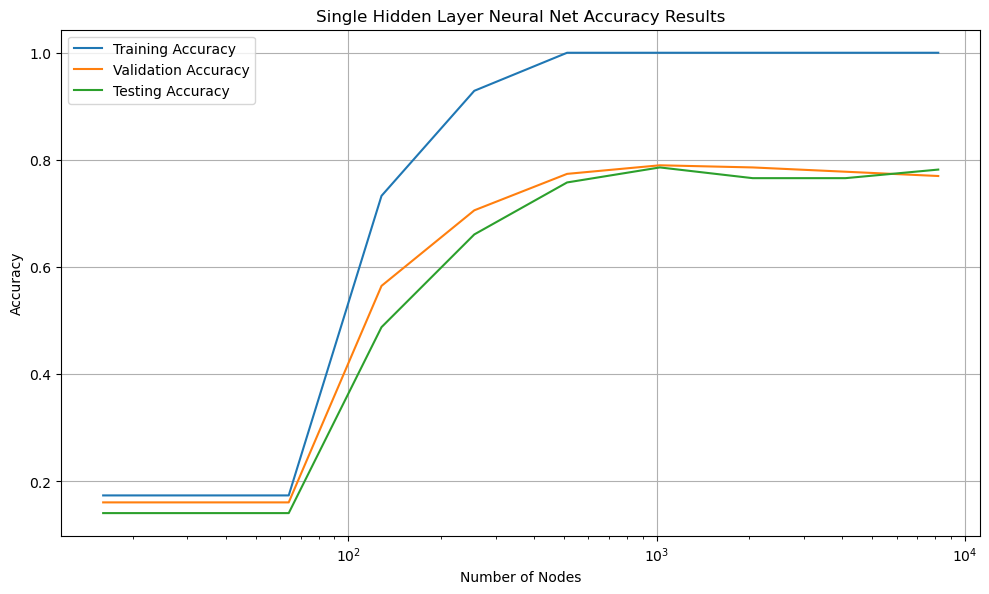

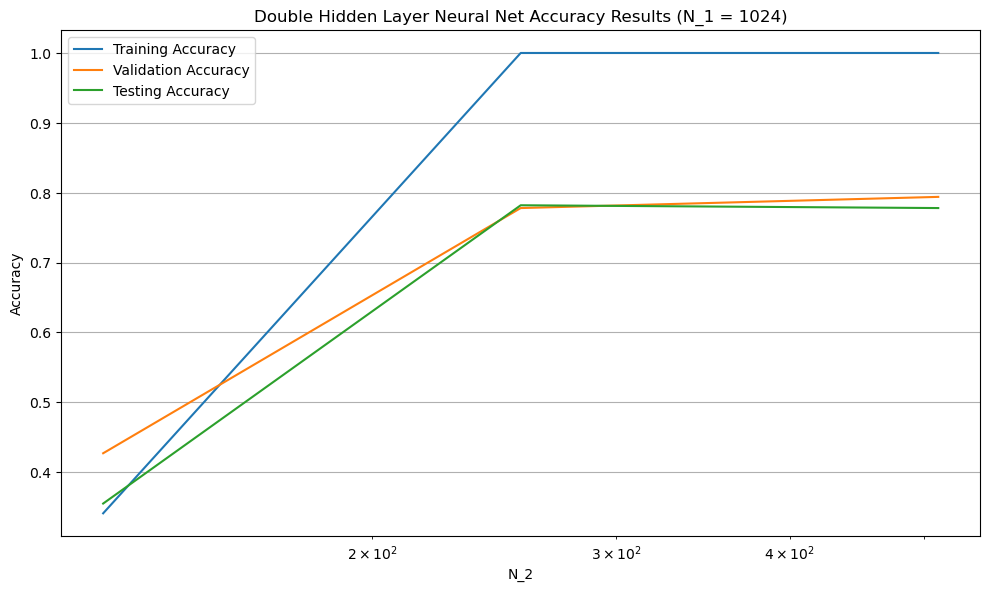

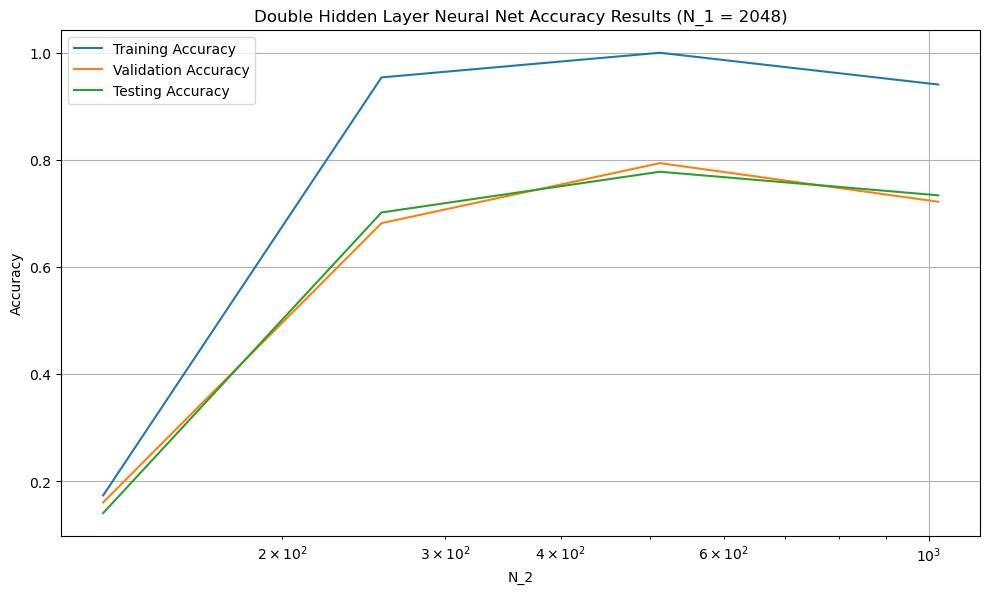

In [91]:
plot_accuracies([16,32,64,128,256,512,1024,2048,4096,8192],[0.174,0.174,0.174,0.733,0.929,1,1,1,1,1],[0.161,0.161,0.161,0.565,0.706,0.774,0.790,0.786,0.778,0.770],[0.141,0.141,0.141,0.488,0.661,0.758,0.786,0.766,0.766,0.782],"Number of Nodes", "Single Hidden Layer Neural Net Accuracy Results")
plot_accuracies([128,256,512],[0.341,1,1], [0.427, 0.778, 0.794],[0.355,0.782,0.778],"N_2", "Double Hidden Layer Neural Net Accuracy Results (N_1 = 1024)")
plot_accuracies([128,256,512, 1024],[0.174,0.954,1,0.9407], [0.161, 0.682, 0.794,0.722],[0.141,0.702,0.778,0.734],"N_2", "Double Hidden Layer Neural Net Accuracy Results (N_1 = 2048)")

In [94]:
relevant_genes = ["TSPAN6 (7105)", "FGR (2268)", "CFH (3075)", "FUCA2 (2519)", "ENPP4 (22875)", "SEMA3F (6405)", "CFTR (1080)", "CD99 (4267)", "HS3ST1 (9957)", "AOC1 (26)", "TMEM176A (55365)", "KLHL13 (90293)", "CYP26B1 (56603)", "ICA1 (3382)", "DBNDD1 (79007)", "CASP10 (843)", "CFLAR (8837)", "TFPI (7035)", "RBM5 (10181)", "SARM1 (23098)", "PLXND1 (23129)", "CD38 (952)", "HSPB6 (126393)", "PDK4 (5166)", "SLC22A16 (85413)", "ABCB5 (340273)", "PRSS22 (64063)", "SKAP2 (8935)", "SLC25A5 (292)", "HOXA11 (3207)", "MEOX1 (4222)", "COPZ2 (51226)", "TSPOAP1 (9256)", "SOX8 (30812)", "ITGAL (3683)", "ITGA3 (3675)", "ITGA2B (3674)", "CRLF1 (9244)", "TMEM98 (26022)", "YBX2 (51087)", "MAP3K14 (9020)", "TMEM132A (54972)", "AP2B1 (163)", "CX3CL1 (6376)", "TNFRSF12A (51330)", "DLX6 (1750)", "MAP3K9 (4293)", "BAIAP2L1 (55971)", "CCL26 (10344)", "USH1C (10083)", "PRSS21 (10942)", "PROM1 (8842)", "CEACAM21 (90273)", "GAS7 (8522)", "MATK (4145)", "CD79B (974)", "PAX6 (5080)", "RHBDF1 (64285)", "NOX1 (27035)", "JARID2 (3720)", "TFAP2B (7021)", "CYB561 (1534)", "CELSR3 (1951)", "AASS (10157)", "PLEKHG6 (55200)", "MGST1 (4257)", "NFIX (4784)", "ST3GAL1 (6482)", "IL32 (9235)", "PKD1 (5310)", "MAPK8IP2 (23542)", "RPS20 (6224)", "TENM1 (10178)", "PAX7 (5081)", "TRAF3IP3 (80342)", "MLXIPL (51085)", "CD9 (928)", "IFFO1 (25900)", "FUZ (80199)", "PRSS3 (5646)", "CD4 (920)", "BTK (695)", "FYN (2534)", "MRC2 (9902)", "TSPAN9 (10867)", "SYT7 (9066)", "PLAUR (5329)", "DCN (1634)", "ZBTB32 (27033)", "TYROBP (7305)", "CD22 (933)", "PRICKLE3 (4007)", "NR1H4 (9971)", "ELOVL5 (60481)", "ALOX5 (240)", "KDM5D (8284)", "CLDN11 (5010)", "DDX11 (1663)", "GPRC5A (9052)", "MTMR11 (10903)", "CCDC88C (440193)", "WAS (7454)", "DPEP1 (1800)", "NPC1L1 (29881)", "STMN4 (81551)", "ISL1 (3670)", "SLC38A5 (92745)", "CNTN1 (1272)", "WWTR1 (25937)", "VSIG2 (23584)", "CYP24A1 (1591)", "SYT13 (57586)", "SNAI2 (6591)", "CD74 (972)", "HGF (3082)", "ADGRA2 (25960)", "RUNX3 (864)", "PLEKHB1 (58473)", "SERPINB1 (1992)", "NRXN3 (9369)", "FHL1 (2273)", "NLRP2 (55655)", "GRAMD1B (57476)", "ERP44 (23071)", "BIRC3 (330)", "ABCC2 (1244)", "DEF6 (50619)", "PLEKHO1 (51177)", "EHD2 (30846)", "RRAGD (58528)", "NR1H3 (10062)", "TYMP (1890)", "VIM (7431)", "FAS (355)", "RNASET2 (8635)", "CD44 (960)", "KCNG1 (3755)", "SLAMF7 (57823)", "PRKCH (5583)", "SH2D2A (9047)", "VRK2 (7444)", "TNFRSF1B (7133)", "ARNTL2 (56938)", "ANK1 (286)", "HMGB3 (3149)", "APBA2 (321)", "MYOC (4653)", "VCL (7414)", "STAP1 (26228)", "TIMP2 (7077)", "MYOM2 (9172)", "TUBG2 (27175)", "AGA (175)", "TRIO (7204)", "VCAN (1462)", "CDH1 (999)", "DNAH5 (1767)", "RAI14 (26064)", "INPP4A (3631)", "TNC (3371)", "CAPG (822)", "ADAM28 (10863)", "ZIC2 (7546)", "LCP2 (3937)", "ADRB1 (153)", "EPHA3 (2042)", "DSG2 (1829)", "GPM6B (2824)", "MAGEC2 (51438)", "PREX2 (80243)", "CP (1356)", "XK (7504)", "SCML1 (6322)", "TNFRSF17 (608)", "LMO3 (55885)", "CELF2 (10659)", "KITLG (4254)", "UTS2 (10911)", "EPN3 (55040)", "LTBP1 (4052)", "RCN1 (5954)", "ELN (2006)", "CLPTM1L (81037)", "NEDD4L (23327)", "DKK3 (27122)", "ARHGEF5 (7984)", "NFE2L3 (9603)", "LIMA1 (51474)", "PTGER3 (5733)", "BCAR1 (9564)", "HERPUD1 (9709)", "CYBA (1535)", "PRSS8 (5652)", "ALX4 (60529)", "NNAT (4826)", "LAMA3 (3909)", "KCNQ1 (3784)", "ENTPD2 (954)", "PTPRN (5798)", "GALC (2581)", "KCNH2 (3757)", "CYFIP2 (26999)", "MCOLN3 (55283)", "NPFFR2 (10886)", "PHF21B (112885)", "TRAF1 (7185)", "IL17RB (55540)", "GYG2 (8908)", "DCBLD2 (131566)", "SERPINB3 (6317)", "PKP2 (5318)", "PRDM1 (639)", "LAMC2 (3918)", "CDK14 (5218)", "CROCC (9696)", "DGKG (1608)", "UNKL (64718)", "TBXAS1 (6916)", "SLC2A3 (6515)", "YBX3 (8531)", "GNA15 (2769)", "CREB3L3 (84699)", "RIMBP2 (23504)", "COL11A1 (1301)", "MPC1 (51660)", "BCAT1 (586)", "HDAC7 (51564)", "LZTS1 (11178)", "NCKAP1 (10787)", "GUCY1B1 (2983)", "CDH3 (1001)", "LTK (4058)", "POLD1 (5424)", "RPL18 (6141)", "CA11 (770)", "EPN1 (29924)", "GPC1 (2817)", "LIMCH1 (22998)", "TM7SF3 (51768)", "DLX3 (1747)", "ST3GAL6 (10402)", "NGFR (4804)", "CDON (50937)", "SLC12A2 (6558)", "CNN2 (1265)", "FAR2 (55711)", "CHI3L2 (1117)", "CALCRL (10203)", "SLC9A3R2 (9351)", "OAT (4942)", "TRAM2 (9697)", "ERBB3 (2065)", "ROPN1 (54763)", "MYLK (4638)", "SNAP91 (9892)", "COL17A1 (1308)", "GSTO2 (119391)", "PRKCQ (5588)", "TLE2 (7089)", "FAM107B (83641)", "ME1 (4199)", "MTHFD2 (10797)", "CTNNA2 (1496)", "TIE1 (7075)", "NGEF (25791)", "SPI1 (6688)", "CLDN18 (51208)", "FGFR2 (2263)", "EML1 (2009)", "KIF26A (26153)", "STAG3 (10734)", "FECH (2235)", "DDX3Y (8653)", "KLF6 (1316)", "NEO1 (4756)", "PKM (5315)", "TRO (7216)", "RRP15 (51018)", "PRKCZ (5590)", "SYT1 (6857)", "NAV3 (89795)", "PDZD4 (57595)", "FGFR3 (2261)", "IFI35 (3430)", "ACSL4 (2182)", "ATP11A (23250)", "RASGRP2 (10235)", "PITX1 (5307)", "ADGRF5 (221395)", "KCNAB2 (8514)", "GAL (51083)", "CLEC2D (29121)", "MAOB (4129)", "GUCY2C (2984)", "NUCB2 (4925)", "PFN2 (5217)", "SPTB (6710)", "DAPP1 (27071)", "ASNS (440)", "ST6GALNAC2 (10610)", "OSBPL3 (26031)", "RPL31 (6160)", "RPS6KA2 (6196)", "LMCD1 (29995)", "TCF3 (6929)", "TRIB2 (28951)", "HLTF (6596)", "CYBRD1 (79901)", "CDH19 (28513)", "SLC6A15 (55117)", "ADGRL1 (22859)", "ACTN1 (87)", "RPS6KA6 (27330)", "EPN2 (22905)", "PTPN18 (26469)", "LIMS2 (55679)", "TFRC (7037)", "P4HA2 (8974)", "ACAP1 (9744)", "CRMP1 (1400)", "EVC (2121)", "IRAG1 (10335)", "PVR (5817)", "CYP2W1 (54905)", "MCM2 (4171)", "PANX2 (56666)", "TP63 (8626)", "LLGL2 (3993)", "FERMT2 (10979)", "DHRS9 (10170)", "PTGS2 (5743)", "IGF2BP2 (10644)", "ST6GAL1 (6480)", "NOTCH3 (4854)", "PPP2R2C (5522)", "TEAD2 (8463)", "ATP2A3 (489)", "CA12 (771)", "MGLL (11343)", "NTN4 (59277)", "ZNF532 (55205)", "SCARF1 (8578)", "ENO1 (2023)", "KCNQ2 (3785)", "SEMA3A (10371)", "SEMA3C (10512)", "CELSR1 (9620)", "CACNG4 (27092)", "FSCN1 (6624)", "MOCOS (55034)", "SEC31B (25956)", "ARHGAP15 (55843)", "PAX2 (5076)", "TPD52 (7163)", "ICAM3 (3385)", "MCAM (4162)", "GPC4 (2239)", "STXBP2 (6813)", "DGKD (8527)", "ACTL6B (51412)", "RARB (5915)", "TOP2B (7155)", "IL4R (3566)", "DCX (1641)", "EXOSC5 (56915)", "APBB1IP (54518)", "TYR (7299)", "ACTN2 (88)", "GPR137B (7107)", "FGFR1 (2260)", "FBLN1 (2192)", "CST7 (8530)", "MAP2 (4133)", "AMPH (273)", "FAP (2191)", "NEBL (10529)", "HOXA9 (3205)", "EDN1 (1906)", "ADCYAP1R1 (117)", "ITM2A (9452)", "CDH17 (1015)", "SLC1A3 (6507)", "LXN (56925)", "SP140 (11262)", "TNS1 (7145)", "RAPGEF3 (10411)", "CEACAM1 (634)", "DUSP13 (51207)", "EPB41L2 (2037)", "MOXD1 (26002)", "PTPRH (5794)", "DCT (1638)", "SLC4A4 (8671)", "SMARCA2 (6595)", "CHRNA3 (1136)", "IGSF9B (22997)", "CXCL2 (2920)", "AFP (174)", "TCF7 (6932)", "IMPG2 (50939)", "MEF2C (4208)", "PTPRC (5788)", "PKP1 (5317)", "ZNF506 (440515)", "ATP8B1 (5205)", "SMARCD3 (6604)", "FYB1 (2533)", "ME2 (4200)", "EPB41L3 (23136)", "COBLL1 (22837)", "KCNK2 (3776)", "SERTAD4 (56256)", "ITGB5 (3693)", "GRHL2 (79977)", "P2RX5 (5026)", "SLC27A5 (10998)", "RPS5 (6193)", "FAT1 (2195)", "GSTP1 (2950)", "APLP2 (334)", "NKAIN1 (79570)", "COL16A1 (1307)", "APOB (338)", "EFR3B (22979)", "GCKR (2646)", "CAD (790)", "CD82 (3732)", "IGSF9 (57549)", "ABCB1 (5243)", "AKR1B1 (231)", "CTTN (2017)", "WNT11 (7481)", "TTC39A (22996)", "MGST2 (4258)", "EPDR1 (54749)", "SNX10 (29887)", "HBQ1 (3049)", "CEACAM6 (4680)", "FAT2 (2196)", "LAT2 (7462)", "MYBPC2 (4606)", "PPP1R15A (23645)", "HSD17B14 (51171)", "TRIP6 (7205)", "FTL (2512)", "MMP2 (4313)", "MT3 (4504)", "LPCAT2 (54947)", "GNAO1 (2775)", "NID2 (22795)", "PTHLH (5744)", "PHACTR3 (116154)", "TFAP2C (7022)", "PIR (8544)", "KHSRP (8570)", "ASAP3 (55616)", "DNMT3B (1789)", "TPX2 (22974)", "EPB41L1 (2036)", "SLC15A1 (6564)", "DOCK9 (23348)", "TMEM40 (55287)", "ARHGAP28 (79822)", "CPXM1 (56265)", "TESC (54997)", "RPL6 (6128)", "P2RX7 (5027)", "OAS1 (4938)", "RPLP0 (6175)", "CHGB (1114)", "FXYD5 (53827)", "FXYD3 (5349)", "HEPH (9843)", "CDIP1 (29965)", "ARHGAP4 (393)", "PCBP4 (57060)", "RGS1 (5996)", "YPEL3 (83719)", "ICAM1 (3383)", "IRAK3 (11213)", "LYZ (4069)", "P3H2 (55214)", "CERS4 (79603)", "EFNB1 (1947)", "NRCAM (4897)", "LAMB1 (3912)", "ITGA6 (3655)", "SEL1L3 (23231)", "TF (7018)", "APOH (350)", "NLRP1 (22861)", "ESR1 (2099)", "ANGPT2 (285)", "TMEM101 (84336)", "CD200 (4345)", "CCDC80 (151887)", "JPH4 (84502)", "SLC7A8 (23428)", "CAPN3 (825)", "TBX15 (6913)", "PHGDH (26227)", "COL9A3 (1299)", "EZR (7430)", "UNC13D (201294)", "TGFB2 (7042)", "EPB41L4B (54566)", "PSMD5 (5711)", "PTGS1 (5742)", "CRAT (1384)", "SH2D3C (10044)", "SORBS1 (10580)", "BAMBI (25805)", "CREM (1390)", "SMIM24 (284422)", "FKBP5 (2289)", "HSP90AB1 (3326)", "ITPR3 (3710)", "DSP (1832)", "IL12RB1 (3594)", "PCSK5 (5125)", "SCD (6319)", "NRP1 (8829)", "PRTFDC1 (56952)", "TSPAN15 (23555)", "MACROH2A2 (55506)", "HSD3B7 (80270)", "MAGEB2 (4113)", "CIRBP (1153)", "MTAP (4507)", "MISP (126353)", "HCN2 (610)", "GADD45B (4616)", "PALM (5064)", "ZDHHC8 (29801)", "SMARCB1 (6598)", "DERL3 (91319)", "SUSD2 (56241)", "GGT5 (2687)", "GGT1 (2678)", "PRODH (5625)", "CYTH4 (27128)", "MFNG (4242)", "GRK3 (157)", "SH3BP1 (23616)", "LGALS1 (3956)", "SOX10 (6663)", "SEPTIN3 (55964)", "KDELR3 (11015)", "XBP1 (7494)", "TIMP3 (7078)", "PACSIN2 (11252)", "NEFH (4744)", "BIK (638)", "HMOX1 (3162)", "PDGFB (5155)", "CABP7 (164633)", "RPL3 (6122)", "SYNGR1 (9145)", "APOL1 (8542)", "PNPLA3 (80339)", "GRAP2 (9402)", "NCF4 (4689)", "IL2RB (3560)", "MLC1 (23209)", "CTSG (1511)", "GZMB (3002)", "COCH (1690)", "PYGL (5836)", "TRIM9 (114088)", "CCDC198 (55195)", "PLEK2 (26499)", "LGMN (5641)", "CHGA (1113)", "SIX4 (51804)", "ASB2 (51676)", "HIF1A (3091)", "TCL1A (8115)", "EFS (10278)", "DHRS2 (10202)", "PCK2 (5106)", "REC8 (9985)", "NFATC4 (4776)", "PLTP (5360)", "PROCR (10544)", "CD40 (958)", "SGK2 (10110)", "MYBL2 (4605)", "HNF4A (3172)", "RIMS4 (140730)", "SALL4 (57167)", "BMP7 (655)", "CTSZ (1522)", "SLCO4A1 (28231)", "NTSR1 (4923)", "SLC17A9 (63910)", "BIRC7 (79444)", "EEF1A2 (1917)", "RASSF2 (9770)", "SIRPB1 (10326)", "FERMT1 (55612)", "PLCB4 (5332)", "MYL9 (10398)", "NOP56 (10528)", "JAG1 (182)", "CST3 (1471)", "WFDC2 (10406)", "AHCY (191)", "MAP1LC3A (84557)", "CELF4 (56853)", "MYL12A (10627)", "LIPG (9388)", "LAMA1 (284217)", "RNF125 (54941)", "TBL1X (6907)", "GPR143 (4935)", "MID1 (4281)", "CHRDL1 (91851)", "SRPX (8406)", "SYP (6855)", "PLP2 (5355)", "PLS3 (5358)", "RENBP (5973)", "SMARCA1 (6594)", "PIM2 (11040)", "PCSK1N (27344)", "VGLL1 (51442)", "TIMP1 (7076)", "GABRE (2564)", "PORCN (64840)", "MAGED2 (10916)", "SRPX2 (27286)", "SYTL4 (94121)", "BEX4 (56271)", "RUBCNL (80183)", "NALCN (259232)", "CAB39L (81617)", "KLF5 (688)", "ACP5 (54)", "FGF9 (2254)", "FLT1 (2321)", "RGCC (28984)", "MEDAG (84935)", "TSC22D1 (8848)", "OLFM4 (10562)", "MSLN (10232)", "CORO1A (11151)", "PLLP (51090)", "MMP15 (4324)", "CYB5B (80777)", "NDRG4 (65009)", "SETD6 (79918)", "HAS3 (3038)", "ESRP2 (80004)", "WFDC1 (58189)", "COTL1 (23406)", "NME4 (4833)", "FOXF1 (2294)", "SLC7A5 (8140)", "METRN (79006)", "CPPED1 (55313)", "SALL1 (6299)", "QPRT (23475)", "PYCARD (29108)", "IL21R (50615)", "SYT17 (51760)", "TMC5 (79838)", "SLC6A2 (6530)", "CORO2B (10391)", "CTSH (1512)", "CD276 (80381)", "CEMIP (57214)", "HOMER2 (9455)", "OCA2 (4948)", "TJP1 (7082)", "SCG3 (29106)", "RHOV (171177)", "MYEF2 (50804)", "PDGFRL (5157)", "ZDHHC2 (51201)", "CA2 (760)", "EYA1 (2138)", "CPQ (10404)", "DECR1 (1666)", "CALB1 (793)", "SFRP1 (6422)", "LAPTM4B (55353)", "PLAT (5327)", "JPH1 (56704)", "ESRP1 (54845)", "CCN4 (8840)", "NDRG1 (10397)", "STMN2 (11075)", "TRPS1 (7227)", "NCALD (83988)", "GSDMD (79792)", "SH2D4A (63898)", "SLC39A14 (23516)", "TNFRSF10A (8797)", "NEFM (4741)", "TUSC3 (7991)", "FGL1 (2267)", "ASAH1 (427)", "KCNN4 (3783)", "MAP4K1 (11184)", "ECH1 (1891)", "RELB (5971)", "FCGRT (2217)", "SLC17A7 (57030)", "CD37 (951)", "AMH (268)", "LYL1 (4066)", "FCER2 (2208)", "IL27RA (9466)", "TNNT1 (7138)", "OLFM2 (93145)", "RASAL3 (64926)", "CASP14 (23581)", "CCNE1 (898)", "RPS16 (6217)", "TIMM50 (92609)", "FBL (2091)", "EBI3 (10148)", "SHD (56961)", "FSD1 (79187)", "CLIP3 (25999)", "SLC1A5 (6510)", "TJP3 (27134)", "APLP1 (333)", "DENND3 (22898)", "MYH14 (79784)", "CD79A (973)", "ICAM4 (3386)", "RPS19 (6223)", "NKG7 (4818)", "CD33 (945)", "CEACAM5 (1048)", "ATP1A3 (478)", "MEIS3 (56917)", "PTPRS (5802)", "GRIN2D (2906)", "CLEC11A (6320)", "CAPS (828)", "RASIP1 (54922)", "PLEKHA4 (57664)", "CACNG7 (59284)", "DNASE2 (1777)", "TFPT (29844)", "JAK3 (3718)", "RPL18A (6142)", "ISYNA1 (51477)", "COMP (1311)", "LSR (51599)", "HPN (3249)", "SCN1B (6324)", "GRIK5 (2901)", "ZNF85 (7639)", "ETHE1 (23474)", "CADM4 (199731)", "CDK6 (1021)", "TFPI2 (7980)", "NAMPT (10135)", "PON3 (5446)", "ITGB8 (3696)", "DLX5 (1749)", "STEAP1B (256227)", "PTN (5764)", "ADAP1 (11033)", "CAV2 (858)", "CAV1 (857)", "MET (4233)", "HOXA2 (3199)", "HOXA3 (3200)", "LFNG (3955)", "TSPAN12 (23554)", "HOXA13 (3209)", "CPED1 (79974)", "CPVL (54504)", "CHN2 (1124)", "GRB10 (2887)", "COBL (23242)", "STX1A (6804)", "EPHB6 (2051)", "HSPB1 (3315)", "NPTX2 (4885)", "CYP3A5 (1577)", "PTPRZ1 (5803)", "AIMP2 (7965)", "TFR2 (7036)", "PCOLCE (5118)", "IMPDH1 (3614)", "SERPINE1 (5054)", "C1GALT1 (56913)", "PLOD3 (8985)", "GLCCI1 (113263)", "MEST (4232)", "TSPAN13 (27075)", "RARRES2 (5919)", "AGR2 (10551)", "AHR (196)", "GIMAP2 (26157)", "TMEM176B (28959)", "GLI3 (2737)", "AEBP1 (165)", "LHX2 (9355)", "TRIM14 (9830)", "TLE4 (7091)", "PTGR1 (22949)", "SUSD1 (64420)", "AMBP (259)", "AKNA (80709)", "TNFSF8 (944)", "ENG (2022)", "DOCK8 (81704)", "KANK1 (23189)", "ELAVL2 (1993)", "NCS1 (23413)", "CA9 (768)", "TYRP1 (7306)", "MPDZ (8777)", "PIP5K1B (8395)", "NPDC1 (56654)", "PTGDS (5730)", "PDLIM1 (9124)", "DNTT (1791)", "GATA3 (2625)", "HPS1 (3257)", "RASSF4 (83937)", "CXCL12 (6387)", "CUBN (8029)", "PLEKHA1 (59338)", "PALD1 (27143)", "UNC5B (219699)", "VSIR (64115)", "SPOCK2 (9806)", "BMPR1A (657)", "ACTA2 (59)", "SFXN3 (81855)", "KAZALD1 (81621)", "MAP3K8 (1326)", "DKK1 (22943)", "EBF3 (253738)", "SORCS1 (114815)", "RPL28 (6158)", "DNAJC12 (56521)", "KRT23 (25984)", "RPL19 (6143)", "RUNDC3A (10900)", "CSF3 (1440)", "RNF43 (54894)", "SEPTIN4 (5414)", "P2RX1 (5023)", "TRIM16L (147166)", "HOXB6 (3216)", "ENO3 (2027)", "RASD1 (51655)", "ALDH3A1 (218)", "ICAM2 (3384)", "LGALS3BP (3959)", "CCL2 (6347)", "HSD17B1 (3292)", "ABI3 (51225)", "DLX4 (1748)", "COL1A1 (1277)", "SGCA (6442)", "VAT1 (10493)", "ABCC3 (8714)", "SMURF2 (64750)", "SLC16A6 (9120)", "EFNB3 (1949)", "VTN (7448)", "TMEM97 (27346)", "PMP22 (5376)", "ALDOC (230)", "RAB34 (83871)", "PHOX2B (8929)", "ODAM (54959)", "NMU (10874)", "AREG (374)", "INPP4B (8821)", "CPE (1363)", "WFS1 (7466)", "ANXA10 (11199)", "SOD3 (6649)", "GLRB (2743)", "BST1 (683)", "KLF3 (51274)", "FAM149A (25854)", "CRYAB (1410)", "HTATIP2 (10553)", "B3GAT1 (27087)", "P2RX3 (5024)", "VWA5A (4013)", "LPXN (9404)", "DTX4 (23220)", "UNC93B1 (81622)", "NRXN2 (9379)", "CCND1 (595)", "HPX (3263)", "TRIM3 (10612)", "FOLR1 (2348)", "IL10RA (3587)", "UPK2 (7379)", "SCGB2A2 (4250)", "MDK (4192)", "CD81 (975)", "SLC35F2 (54733)", "C11orf21 (29125)", "ELMOD1 (55531)", "SOX6 (55553)", "RPS13 (6207)", "TCIRG1 (10312)", "CHKA (1119)", "POU2AF1 (5450)", "P3H3 (10536)", "CD69 (969)", "CLEC2B (9976)", "SELPLG (6404)", "CAPRIN2 (65981)", "BIN2 (51411)", "MYF5 (4617)", "KRT18 (3875)", "GLI1 (2735)", "PPM1H (57460)", "SLC6A12 (6539)", "WNT5B (81029)", "ALDH2 (217)", "GPRC5D (55507)", "SCNN1A (6337)", "LTBR (4055)", "OAS3 (4940)", "OAS2 (4939)", "MGP (4256)", "RASAL1 (8437)", "ARHGDIB (397)", "SLC38A1 (81539)", "TBC1D30 (23329)", "IL26 (55801)", "TIMELESS (8914)", "GAPDH (2597)", "GNB3 (2784)", "ENO2 (2026)", "C12orf57 (113246)", "PTPN6 (5777)", "LPCAT3 (10162)", "SLCO1B3 (28234)", "LDHB (3945)", "ST8SIA1 (6489)", "COL12A1 (1303)", "GCNT2 (2651)", "NEDD9 (4739)", "MAN1A1 (4121)", "TPD52L1 (7164)", "NCOA7 (135112)", "RIPOR2 (9750)", "SASH1 (23328)", "PHACTR1 (221692)", "BMP5 (653)", "BACH2 (60468)", "BAG2 (9532)", "PTP4A1 (7803)", "CRYBG1 (202)", "VNN2 (8875)", "RPS12 (6206)", "EYA4 (2070)", "PERP (64065)", "ADGRG6 (57211)", "QKI (9444)", "PDE10A (10846)", "MDFI (4188)", "CCND3 (896)", "PTK7 (5754)", "DUSP22 (56940)", "TMEM30A (55754)", "GMDS (2762)", "SLC29A1 (2030)", "LAMA4 (3910)", "CLIC5 (53405)", "FBRSL1 (57666)", "LY86 (9450)", "TBX18 (9096)", "NUDT12 (83594)", "SEMA5A (9037)", "NNT (23530)", "HSPA9 (3313)", "HBEGF (1839)", "LOX (4015)", "SPARC (6678)", "HAND1 (9421)", "HAVCR1 (26762)", "RNF130 (55819)", "CCNG1 (900)", "CDH6 (1004)", "LMNB1 (4001)", "IRX4 (50805)", "PDE4D (5144)", "PRLR (5618)", "NR3C1 (2908)", "LIFR (3977)", "WWC1 (23286)", "DPYSL3 (1809)", "PDGFRB (5159)", "CDX1 (1044)", "STC2 (8614)", "DBN1 (1627)", "BCL6 (604)", "HGD (3081)", "CLDN16 (10686)", "CD86 (942)", "AMOTL2 (51421)", "RBP1 (5947)", "BCHE (590)", "WNT5A (7474)", "PFKFB4 (5210)", "COL7A1 (1294)", "HES1 (3280)", "USP9Y (8287)", "RPL24 (6152)", "C3orf14 (57415)", "GNB4 (59345)", "FRMD4B (23150)", "ROPN1B (152015)", "PODXL2 (50512)", "UPK1B (7348)", "CISH (1154)", "AADAC (13)", "VIPR1 (7433)", "TNNC1 (7134)", "NKTR (4820)", "FOXP1 (27086)", "ADAM23 (8745)", "IL1A (3552)", "CCL20 (6364)", "KCNIP3 (30818)", "ZAP70 (7535)", "STEAP3 (55240)", "CYTIP (9595)", "ITGB6 (3694)", "FNDC4 (64838)", "ITGA4 (3676)", "RPS15 (6209)", "CLIP4 (79745)", "TLX2 (3196)", "LOXL3 (84695)", "GALNT3 (2591)", "EVA1A (84141)", "EFEMP1 (2202)", "FN1 (2335)", "GLS (2744)", "IGFBP2 (3485)", "IGFBP5 (3488)", "EFHD1 (80303)", "ST3GAL5 (8869)", "CHST10 (9486)", "HSPE1 (3336)", "IL1R2 (7850)", "IL1R1 (3554)", "FHL2 (2274)", "MLPH (79083)", "ID2 (3398)", "HPCAL1 (3241)", "ODC1 (4953)", "QPCT (25797)", "SDC1 (6382)", "SLC1A4 (6509)", "SOS1 (6654)", "KYNU (8942)", "WIPF1 (7456)", "PLEK (5341)", "RND3 (390)", "EPAS1 (2034)", "ATP6V1B1 (525)", "PRRX1 (5396)", "GPX7 (2882)", "QSOX1 (5768)", "ERRFI1 (54206)", "ELAPOR1 (57535)", "RHOU (58480)", "ARHGEF2 (9181)", "FBXO2 (26232)", "C1orf21 (81563)", "NCF2 (4688)", "PLA2G4A (5321)", "WLS (79971)", "RGS2 (5997)", "AMPD1 (270)", "OLFML3 (56944)", "NR5A2 (2494)", "KIF21B (23046)", "NID1 (4811)", "BMP8B (656)", "SIPA1L2 (57568)", "KMO (8564)", "RIMS3 (9783)", "SLAMF1 (6504)", "CD48 (962)", "ADGRL2 (23266)", "PADI2 (11240)", "MFAP2 (4237)", "KDM5B (10765)", "RGS4 (5999)", "GBP1 (2633)", "ID3 (3399)", "SLC2A1 (6513)", "CDC20 (991)", "ARTN (9048)", "PIK3R3 (8503)", "TSPAN1 (10103)", "FAAH (2166)", "CNN3 (1266)", "F3 (2152)", "IRF6 (3664)", "PLPPR5 (163404)", "PLPPR4 (9890)", "RPS6KA1 (6195)", "CHRNB4 (1143)", "MUC5B (727897)", "MMP8 (4317)", "APOA1 (335)", "RPS25 (6230)", "TNNT2 (7139)", "NRP2 (8828)", "TTR (7276)", "C1orf54 (79630)", "CA14 (23632)", "IRAG2 (4033)", "ATP10B (23120)", "CNR1 (1268)", "SGIP1 (84251)", "PLAGL1 (5325)", "AKAP7 (9465)", "RAB32 (10981)", "MYB (4602)", "SGK1 (6446)", "CCN2 (1490)", "VAMP8 (8673)", "PKD2 (5311)", "ABCG2 (9429)", "SPP1 (6696)", "RARRES1 (5918)", "PPL (5493)", "LDAH (60526)", "CCND2 (894)", "ELL2 (22936)", "GDA (9615)", "KLF9 (687)", "BSPRY (54836)", "GALNT12 (79695)", "PGF (5228)", "IFI27L2 (83982)", "NPC2 (10577)", "ACOT2 (10965)", "LTBP2 (4053)", "TGFB3 (7043)", "FKBP1B (2281)", "CNRIP1 (25927)", "EPCAM (4072)", "OGFRL1 (79627)", "IFIT2 (3433)", "PPP1R3C (5507)", "AVPI1 (60370)", "CPN1 (1369)", "HOXB8 (3218)", "HOXB5 (3215)", "HOXB3 (3213)", "DUSP1 (1843)", "MSX2 (4488)", "MLANA (2315)", "CD274 (29126)", "CXorf21 (80231)", "CYSTM1 (84418)", "PLXDC2 (84898)", "DNAJC15 (29103)", "SMAD9 (4093)", "TGFBI (7045)", "EGR1 (1958)", "PLS1 (5357)", "GLT8D2 (83468)", "SOCS2 (8835)", "DUSP4 (1846)", "CLU (1191)", "SORBS3 (10174)", "PTK2B (2185)", "PDLIM2 (64236)", "NPPB (4879)", "TNFRSF8 (943)", "RDH10 (157506)", "TBX2 (6909)", "FAM117A (81558)", "ABCC11 (85320)", "ADCY7 (113)", "TSHZ3 (57616)", "ECHDC2 (55268)", "PLBD1 (79887)", "A1BG (1)", "ZSCAN18 (65982)", "PDZRN3 (23024)", "CSTA (1475)", "DEPDC7 (91614)", "PILRB (29990)", "GJB6 (10804)", "FABP3 (2170)", "TNFSF10 (8743)", "TMEM156 (80008)", "TMEM54 (113452)", "CSMD2 (114784)", "CXCR4 (7852)", "FLT3 (2322)", "RPL21 (6144)", "GTF3A (2971)", "RASL11A (387496)", "SASH3 (54440)", "PAEP (5047)", "MYOG (4656)", "LAX1 (54900)", "LY9 (4063)", "PRXL2A (84293)", "RPL5 (6125)", "LRRC39 (127495)", "NPY (4852)", "FAM126A (84668)", "HOXA7 (3204)", "INHBA (3624)", "FKBP9 (11328)", "ARL4A (10124)", "TWIST1 (7291)", "SPINK4 (27290)", "CNTFR (1271)", "CALD1 (800)", "PLAU (5328)", "SRGN (5552)", "BICC1 (80114)", "IFT81 (28981)", "ACADS (35)", "HVCN1 (84329)", "CDKN2C (1031)", "RASSF8 (11228)", "BHLHE41 (79365)", "ITIH5 (80760)", "ARHGAP9 (64333)", "NCKAP1L (3071)", "MMP19 (4327)", "NR4A1 (3164)", "PDE1B (5153)", "HOXC13 (3229)", "CDK2 (1017)", "LRP1 (4035)", "HOXC11 (3227)", "NFE2 (4778)", "HOXC12 (3228)", "TUBA1B (10376)", "DBH (1621)", "IL13RA2 (3598)", "PLP1 (5354)", "NMI (9111)", "TNFAIP6 (7130)", "BATF3 (55509)", "G0S2 (50486)", "C4BPB (725)", "RAB38 (23682)", "CHPF (79586)", "OBSL1 (23363)", "FAM210B (116151)", "PI3 (5266)", "SLPI (6590)", "PREX1 (57580)", "SLC12A5 (57468)", "SDC4 (6385)", "PLCG1 (5335)", "TOX2 (84969)", "GDAP1L1 (78997)", "PTGIS (5740)", "PMEPA1 (56937)", "BCAS4 (55653)", "ZBP1 (81030)", "XG (7499)", "POF1B (79983)", "LYPD3 (27076)", "NDP (4693)", "SLC17A3 (10786)", "SERPINB6 (5269)", "RPS10 (6204)", "SPDEF (25803)", "CDKN1A (1026)", "NRN1 (51299)", "RAB17 (64284)", "EREG (2069)", "MYRF (745)", "SCGB1D2 (10647)", "AHNAK (79026)", "MT1G (4495)", "MT2A (4502)", "DOK4 (55715)", "GPR18 (2841)", "ABCC4 (10257)", "EFNB2 (1948)", "SEPTIN6 (23157)", "TMEM255A (55026)", "BMP4 (652)", "SOX9 (6662)", "SLC2A4RG (56731)", "IL1B (3553)", "PAX8 (7849)", "TNFSF9 (8744)", "CD70 (970)", "C3 (718)", "SH2D3A (10045)", "FOSB (2354)", "RTN2 (6253)", "FOXA2 (3170)", "NKX2-2 (4821)", "SNRPB (6628)", "NRSN2 (80023)", "PCSK2 (5126)", "LAMP5 (24141)", "LRRN4 (164312)", "S1PR4 (8698)", "CITED1 (4435)", "MMP24 (10893)", "ID1 (3397)", "BPIFB1 (92747)", "CEP250 (11190)", "MCF2L (23263)", "F10 (2159)", "HCST (10870)", "CCR7 (1236)", "RRAS (6237)", "HTN1 (3346)", "STAT5A (6776)", "IFI6 (2537)", "CFP (5199)", "SIX1 (6495)", "RHOJ (57381)", "L3HYPDH (112849)", "HSPA2 (3306)", "EVI2A (2123)", "AIF1L (83543)", "FAM78A (286336)", "CTAG2 (30848)", "ARMCX1 (51309)", "ZC4H2 (55906)", "RGS13 (6003)", "EDN2 (1907)", "BCL11B (64919)", "MASP1 (5648)", "TSPAN8 (7103)", "LRRC61 (65999)", "KLF2 (10365)", "FBXL16 (146330)", "TUBA4A (7277)", "VIL1 (7429)", "TNFRSF19 (55504)", "GNG11 (2791)", "STEAP4 (79689)", "GNAI1 (2770)", "SGCE (8910)", "RASL11B (65997)", "VPREB3 (29802)", "GAL3ST1 (9514)", "MGAT3 (4248)", "ADORA2A (135)", "BAIAP2L2 (80115)", "IGLL1 (3543)", "RAC2 (5880)", "LIF (3976)", "RIBC2 (26150)", "KRT17 (3872)", "RNF112 (7732)", "CPA4 (51200)", "VGF (7425)", "PODXL (5420)", "FOXP2 (93986)", "FLNC (2318)", "CCDC136 (64753)", "SMO (6608)", "LRRC17 (10234)", "FEZF1 (389549)", "MYO1B (4430)", "CHN1 (1123)", "GAD1 (2571)", "HOXD9 (3235)", "HOXD10 (3236)", "HOXD11 (3237)", "HOXD13 (3239)", "SNRPN (6638)", "ARHGAP22 (58504)", "WDFY4 (57705)", "MYO5C (55930)", "ELL3 (80237)", "ISLR (3671)", "LOXL1 (4016)", "MYOD1 (4654)", "SOX15 (6665)", "PIMREG (54478)", "CD68 (968)", "SLC44A2 (57153)", "AP1M2 (10053)", "KLK10 (5655)", "KLK8 (11202)", "AJUBA (84962)", "FOXA1 (3169)", "EGLN3 (112399)", "RNASE1 (6035)", "FOXJ1 (2302)", "ARHGEF6 (9459)", "MAP7D3 (79649)", "FGF13 (2258)", "CDKN1C (1028)", "RPS4Y1 (6192)", "CDH15 (1013)", "PGAP6 (58986)", "PLPPR3 (79948)", "TNNI3 (7137)", "CBFA2T3 (863)", "GAMT (2593)", "CRACR2A (84766)", "NXNL2 (158046)", "SAT1 (6303)", "SH3BP4 (23677)", "CNN1 (1264)", "NECTIN2 (5819)", "APOE (348)", "APOC1 (341)", "RPL36 (25873)", "KIF1A (547)", "BST2 (684)", "STK33 (65975)", "CACNG6 (59285)", "FCHO1 (23149)", "UNC13A (23025)", "KLHDC7B (113730)", "PXDN (7837)", "GDF15 (9518)", "JUND (3727)", "CRB3 (92359)", "OLFM1 (10439)", "LSP1 (4046)", "TNNT3 (7140)", "TNNI2 (7136)", "COL5A1 (1289)", "LAMA5 (3911)", "ASS1 (445)", "FIBCD1 (84929)", "TRIM28 (10155)", "GMFG (9535)", "ARHGEF16 (27237)", "SMPDL3B (27293)", "ATP5IF1 (93974)", "THEMIS2 (9473)", "SHFL (55337)", "DUSP9 (1852)", "MPP1 (4354)", "ZNF331 (55422)", "LRP3 (4037)", "CASZ1 (54897)", "SLC35D2 (11046)", "PRRG1 (5638)", "RGN (9104)", "ULBP2 (80328)", "AKAP12 (9590)", "ULBP3 (79465)", "EPS8L1 (54869)", "GGT7 (2686)", "EDA2R (60401)", "C1QL1 (10882)", "SH3BGRL (6451)", "F12 (2161)", "RFTN1 (23180)", "KCNC3 (3748)", "NAPSA (9476)", "PDLIM4 (8572)", "GFPT2 (9945)", "ANO1 (55107)", "TMEM204 (79652)", "KREMEN2 (79412)", "BARX1 (56033)", "MAP1B (4131)", "IL13RA1 (3597)", "TNS4 (84951)", "PPP1R1B (84152)", "KHDRBS3 (10656)", "ZNF304 (57343)", "RHPN2 (85415)", "ABHD12B (145447)", "GCH1 (2643)", "LGALS3 (3958)", "MATN3 (4148)", "SLC6A11 (6538)", "PPARG (5468)", "NUP210 (23225)", "FCRLA (84824)", "ENOSF1 (55556)", "TRIM22 (10346)", "RAMP1 (10267)", "SERPINF1 (5176)", "POPDC3 (64208)", "LANCL2 (55915)", "DDC (1644)", "JCHAIN (3512)", "ITGB4 (3691)", "SLC52A1 (55065)", "XAF1 (54739)", "DLG4 (1742)", "REEP2 (51308)", "MTSS2 (92154)", "SNAP25 (6616)", "BTBD3 (22903)", "ATP1A4 (480)", "NES (10763)", "RAB25 (57111)", "APCS (325)", "SYT11 (23208)", "ALDH3B2 (222)", "TESMIN (9633)", "NASP (4678)", "LPIN3 (64900)", "RBM38 (55544)", "VSTM2L (128434)", "DMGDH (29958)", "BHMT2 (23743)", "KANK4 (163782)", "SYT4 (6860)", "ALOX5AP (241)", "MYH10 (4628)", "CHI3L1 (1116)", "LGR6 (59352)", "TMCC2 (9911)", "DCLK1 (9201)", "CCNA1 (8900)", "SPART (23111)", "EPSTI1 (94240)", "POSTN (10631)", "TPT1 (7178)", "STARD13 (90627)", "BEX2 (84707)", "RNF128 (79589)", "TCEAL4 (79921)", "BEX1 (55859)", "PDE6B (5158)", "PLAAT4 (5920)", "PLAAT2 (54979)", "LARGE1 (9215)", "GSTT2B (653689)", "MYO18B (84700)", "FAM83F (113828)", "GIMAP6 (474344)", "AGAP3 (116988)", "NTS (4922)", "BTG1 (694)", "TMTC1 (83857)", "E2F5 (1875)", "MICAL2 (9645)", "DUSP26 (78986)", "EIF2S1 (1965)", "LOXL2 (4017)", "MBD2 (8932)", "IRAK2 (3656)", "CAMK1 (8536)", "CHL1 (10752)", "MEIS2 (4212)", "TRPM1 (4308)", "GSTM1 (2944)", "TSPAN2 (10100)", "GSTM3 (2947)", "VAV3 (10451)", "PTPN22 (26191)", "SORT1 (6272)", "PTGFRN (5738)", "VTCN1 (79679)", "NGF (4803)", "FKBP11 (51303)", "MYCN (4613)", "SAA2 (6289)", "FST (10468)", "RPS15A (6210)", "NARS1 (4677)", "GRP (2922)", "IL2RA (3559)", "ECHDC3 (79746)", "DOCK2 (1794)", "EMP1 (2012)", "SOX5 (6660)", "RERG (85004)", "LRP4 (4038)", "RTL8C (8933)", "RAB33A (9363)", "STK26 (51765)", "SPOCD1 (90853)", "HOOK1 (51361)", "DSG3 (1830)", "DSC3 (1825)", "DTNA (1837)", "FHOD3 (80206)", "SLC43A3 (29015)", "FADS2 (9415)", "TCN1 (6947)", "PDGFRA (5156)", "COL4A2 (1284)", "CLDN10 (9071)", "DZIP1 (22873)", "STT3A (3703)", "ETS1 (2113)", "SLC37A2 (219855)", "NREP (9315)", "ANXA1 (301)", "CTSL (1514)", "CEMIP2 (23670)", "PSAT1 (29968)", "CCNJL (79616)", "TBX3 (6926)", "OASL (8638)", "BICDL1 (92558)", "DTX1 (1840)", "CD36 (948)", "TES (26136)", "MDFIC (29969)", "KHDC1 (80759)", "NT5E (4907)", "EPHA7 (2045)", "PRR5L (79899)", "LMO2 (4005)", "EHF (26298)", "PRPH (5630)", "GLS2 (27165)", "ITGA7 (3679)", "TESPA1 (9840)", "AGAP2 (116986)", "CDK4 (1019)", "PPP1R1A (5502)", "B4GALNT1 (2583)", "FAIM2 (23017)", "KRT7 (3855)", "HNRNPA1 (3178)", "MAP7 (9053)", "PKIB (5570)", "MDM2 (4193)", "AGT (183)", "KCNK1 (3775)", "GLUL (2752)", "LAMC1 (3915)", "CHRND (1144)", "PAX3 (5077)", "HTR2B (3357)", "ITM2C (81618)", "SERPINE2 (5270)", "WNT10A (80326)", "TMBIM1 (64114)", "CYP27A1 (1593)", "ARMC9 (80210)", "EDAR (10913)", "ARHGEF4 (50649)", "ALDH1L2 (160428)", "CKAP4 (10970)", "PLXNC1 (10154)", "VILL (50853)", "NEK3 (4752)", "RNASEH2B (79621)", "LMO7 (4008)", "SCEL (8796)", "SPRY2 (10253)", "EDNRB (1910)", "LCP1 (3936)", "SCRN1 (9805)", "TNS3 (64759)", "IGF2BP3 (10643)", "GPNMB (10457)", "IL6 (3569)", "AOAH (313)", "BZW2 (28969)", "NACAD (23148)", "MYO1G (64005)", "TTYH3 (80727)", "NKX2-1 (7080)", "ADAMTS7 (11173)", "TM6SF1 (53346)", "LIMD2 (80774)", "GALNT5 (11227)", "BLK (640)", "GATA4 (2626)", "HLX (3142)", "IL10 (3586)", "IL1RN (3557)", "HS6ST1 (9394)", "GYPC (2995)", "KLF4 (9314)", "NIBAN2 (64855)", "TMOD1 (7111)", "DAB2IP (153090)", "ANGPTL2 (23452)", "TLR4 (7099)", "KIF12 (113220)", "RPL35 (11224)", "CTSV (1515)", "ENPP2 (5168)", "MYC (4609)", "SIT1 (27240)", "CD72 (971)", "IGFBPL1 (347252)", "RPS6 (6194)", "KIF13A (63971)", "GMPR (2766)", "TFAP2A (7020)", "TINAG (27283)", "KIAA0319 (9856)", "IRF4 (3662)", "SLC22A23 (63027)", "TUBB2A (7280)", "TUBB2B (347733)", "HMGA1 (3159)", "FLOT1 (10211)", "IER3 (8870)", "RNF144B (255488)", "FGFBP1 (9982)", "FGFBP2 (83888)", "TLR2 (7097)", "MGARP (84709)", "ARRB1 (408)", "SLCO2B1 (11309)", "SYTL2 (54843)", "GGH (8836)", "SLCO5A1 (81796)", "SULF1 (23213)", "SORL1 (6653)", "TMPRSS4 (56649)", "MMP7 (4316)", "YAP1 (10413)", "TRIM29 (23650)", "FXYD6 (53826)", "FXYD2 (486)", "MMP13 (4322)", "TMPRSS13 (84000)", "CASP1 (834)", "UNC13C (440279)", "SQOR (58472)", "THBS1 (7057)", "ITGA11 (22801)", "PARP6 (56965)", "ITPKA (3706)", "UACA (55075)", "PLCB2 (5330)", "PAK6 (56924)", "ADAM10 (102)", "DUOX1 (53905)", "STRA6 (64220)", "BCAR3 (8412)", "TTLL7 (79739)", "FNBP1L (54874)", "ARHGAP29 (9411)", "IFI44 (10561)", "SLC44A5 (204962)", "CGREF1 (10669)", "ADCY3 (109)", "CYP1B1 (1545)", "SLC5A6 (8884)", "EMILIN1 (11117)", "MYOF (26509)", "LOXL4 (84171)", "STAMBPL1 (57559)", "TACC2 (10579)", "DUSP5 (1847)", "ENTPD1 (953)", "RBP4 (5950)", "GPR87 (53836)", "RPS24 (6229)", "AOX1 (316)", "MSTN (2660)", "CHRNA1 (1134)", "SLC40A1 (30061)", "SEMA7A (8482)", "ARHGAP24 (83478)", "HERC5 (51191)", "NDST4 (64579)", "FGF5 (2250)", "GPAT3 (84803)", "FGF2 (2247)", "BMP2K (55589)", "ANXA3 (306)", "LEF1 (51176)", "EGF (1950)", "PPP3CA (5530)", "SLC39A8 (64116)", "FBN2 (2201)", "PARVG (64098)", "B4GALNT3 (283358)", "ERP27 (121506)", "GABARAPL1 (23710)", "KIF21A (55605)", "CPNE8 (144402)", "SINHCAF (58516)", "VAMP1 (6843)", "CD27 (939)", "PIANP (196500)", "AMIGO2 (347902)", "COL2A1 (1280)", "LRIG3 (121227)", "INHBE (83729)", "GLIPR1 (11010)", "PHLDA1 (22822)", "LGR5 (8549)", "LUM (4060)", "ASCL1 (429)", "PDX1 (3651)", "N4BP2L1 (90634)", "MAP3K12 (7786)", "ITGB7 (3695)", "GALNT6 (11226)", "CSAD (51380)", "LPAR6 (10161)", "VPS37B (79720)", "RHOF (54509)", "SLAIN1 (122060)", "RAB20 (55647)", "GRTP1 (79774)", "NOVA1 (4857)", "FITM1 (161247)", "FRMD6 (122786)", "RTN1 (6252)", "FBLN5 (10516)", "SLC27A2 (11001)", "FGF7 (2252)", "GCNT3 (9245)", "PSTPIP1 (9051)", "BCL2A1 (597)", "NEIL1 (79661)", "DNAJA4 (55466)", "TPM1 (7168)", "ARRDC4 (91947)", "PCSK6 (5046)", "HAPLN3 (145864)", "ABHD2 (11057)", "MFGE8 (4240)", "ST8SIA2 (8128)", "MCTP2 (55784)", "SH3GL3 (6457)", "TGFB1I1 (7041)", "NKD1 (85407)", "MARVELD3 (91862)", "NLRC5 (84166)", "KIFC3 (3801)", "CMTM3 (123920)", "CDH11 (1009)", "CDH13 (1012)", "OSGIN1 (29948)", "IRF8 (3394)", "RPS2 (6187)", "PCTP (58488)", "SKAP1 (8631)", "RHBDL3 (162494)", "IMPA2 (3613)", "GATA6 (2627)", "SLC14A1 (6563)", "SAT2 (112483)", "ASGR1 (432)", "PIK3R5 (23533)", "TMC6 (11322)", "SLC16A3 (9123)", "TTYH2 (94015)", "SECTM1 (6398)", "MAPK4 (5596)", "SMAD4 (4089)", "CBLN2 (147381)", "PMAIP1 (5366)", "ERBB2 (2064)", "GRB7 (2886)", "PNMT (5409)", "IGFBP4 (3487)", "FKBP10 (60681)", "CACNA1A (773)", "PLPP2 (8612)", "PRDM15 (63977)", "VAV1 (7409)", "IFITM3 (10410)", "COL6A1 (1291)", "COL6A2 (1292)", "SIK1 (150094)", "TRPM2 (7226)", "APP (351)", "URB1 (9875)", "EMP3 (2014)", "CBLC (23624)", "ADAMTS10 (81794)", "MYO1F (4542)", "TM4SF5 (9032)", "KLK3 (354)", "RPS11 (6205)", "RPL13A (23521)", "RCN3 (57333)", "PRDM16 (63976)", "PADI3 (51702)", "PADI1 (29943)", "EPHA2 (1969)", "PGD (5226)", "MYOM3 (127294)", "CNKSR1 (10256)", "RPL11 (6135)", "DMRTA2 (63950)", "MAP3K6 (9064)", "CCN1 (3491)", "PRKACB (5567)", "TINAGL1 (64129)", "RPS8 (6202)", "PTPRF (5792)", "CYP4B1 (1580)", "LMO4 (8543)", "BARHL2 (343472)", "IGSF3 (3321)", "CD53 (963)", "ATP1B1 (481)", "GPA33 (10223)", "RXRG (6258)", "ILDR2 (387597)", "NECTIN4 (81607)", "FCGR2A (2212)", "RGS5 (8490)", "CRABP2 (1382)", "RGS16 (6004)", "FAM163A (148753)", "HMCN1 (83872)", "RGL1 (23179)", "LYPLAL1 (127018)", "RORC (6097)", "ECM1 (1893)", "CTSK (1513)", "SELENBP1 (8991)", "SEMA6C (10500)", "VASH2 (79805)", "SUSD4 (55061)", "DUSP10 (11221)", "HHIPL2 (79802)", "ATP8B2 (57198)", "RAB13 (5872)", "S100A8 (6279)", "S100A7 (6278)", "CREB3L4 (148327)", "KCNN3 (3782)", "LYST (1130)", "MAP3K21 (84451)", "PARP1 (142)", "WNT9A (7483)", "EPHX1 (2052)", "ETNK2 (55224)", "PLEKHA6 (22874)", "PTPN7 (5778)", "OSR1 (130497)", "RHOB (388)", "GALM (130589)", "RPS27A (6233)", "MEIS1 (4211)", "DQX1 (165545)", "MALL (7851)", "SLC20A1 (6574)", "FBLN7 (129804)", "FAHD2B (151313)", "GALNT13 (114805)", "TMEFF2 (23671)", "CDCA7 (83879)", "DLX1 (1745)", "GULP1 (51454)", "HSPD1 (3329)", "ACKR3 (57007)", "HES6 (55502)", "MARCHF4 (57574)", "RBMS3 (27303)", "OSBPL10 (114884)", "ACKR2 (1238)", "CTDSPL (10217)", "STAC (6769)", "RPL32 (6161)", "LRIG1 (26018)", "NFKBIZ (64332)", "COL8A1 (1295)", "PHLDB2 (90102)", "TAGLN3 (29114)", "IGSF11 (152404)", "TMEM108 (66000)", "AGTR1 (185)", "UCN2 (90226)", "TM4SF19 (116211)", "MUC4 (4585)", "AHSG (197)", "OCIAD2 (132299)", "SLC10A4 (201780)", "PLAC8 (51316)", "SNCA (6622)", "CAMK2D (817)", "DDIT4L (115265)", "ANK2 (287)", "PDGFC (56034)", "NKD2 (85409)", "RPL37 (6167)", "OSMR (9180)", "PLK2 (10769)", "SHISAL2B (100132916)", "HAPLN1 (1404)", "LHFPL2 (10184)", "SSBP2 (23635)", "IQGAP2 (10788)", "LIX1 (167410)", "GTF2H2 (2966)", "ARHGAP26 (23092)", "CXCL14 (9547)", "TIMD4 (91937)", "CPLX2 (10814)", "TENM2 (57451)", "TBC1D7 (51256)", "DCDC2 (51473)", "TNFRSF21 (27242)", "DOK3 (79930)", "DAAM2 (23500)", "LGSN (51557)", "SCUBE3 (222663)", "TPBG (7162)", "PRSS35 (167681)", "CLVS2 (134829)", "RSPO3 (84870)", "ABRACL (58527)", "VIP (7432)", "SLC22A3 (6581)", "VWDE (221806)", "EGFR (1956)", "IGFBP3 (3486)", "IGFBP1 (3484)", "TRIM4 (89122)", "ZC3HAV1L (92092)", "EPHA1 (2041)", "NLGN4X (57502)", "SHROOM2 (357)", "DENND2A (27147)", "TMEM47 (83604)", "MSN (4478)", "SLC16A2 (6567)", "IL2RG (3561)", "ZNF711 (7552)", "NXF3 (56000)", "DOCK11 (139818)", "ARHGAP36 (158763)", "GPC3 (2719)", "MFHAS1 (9258)", "MAGEA4 (4103)", "ZNF185 (7739)", "RPL10 (6134)", "CSGALNACT1 (55790)", "DOK2 (9046)", "DOCK5 (80005)", "ST18 (9705)", "CRH (1392)", "TRIM55 (84675)", "RPL7 (6129)", "SYBU (55638)", "LRP12 (29967)", "MAL2 (114569)", "NDUFB9 (4715)", "FAM83A (84985)", "GSDMC (56169)", "VLDLR (7436)", "PLIN2 (123)", "CDKN2B (1030)", "CDKN2A (1029)", "STOM (2040)", "GSN (2934)", "GBGT1 (26301)", "RPL7A (6130)", "PTGES (9536)", "LCN2 (3934)", "FAM171A1 (221061)", "RSU1 (6251)", "PARD3 (56288)", "A1CF (29974)", "ADIRF (10974)", "ANKRD1 (27063)", "HTR7 (3363)", "ADD3 (120)", "PLEKHS1 (79949)", "INA (9118)", "FUOM (282969)", "GSTO1 (9446)", "ADAM12 (8038)", "RGS10 (6001)", "ADM (133)", "GAS2 (2620)", "SCGB1A1 (7356)", "SYT8 (90019)", "ZNF215 (7762)", "HSD17B12 (51144)", "PAMR1 (25891)", "SERPING1 (710)", "SLC43A1 (8501)", "PTPRJ (5795)", "KLHL35 (283212)", "TENM4 (26011)", "SERPINH1 (871)", "RPS3 (6188)", "ZC3H12C (85463)", "TTC12 (54970)", "NCAM1 (4684)", "ATM (472)", "GLB1L2 (89944)", "P4HA3 (283208)", "ST14 (6768)", "ADAM33 (80332)", "FADS1 (3992)", "MS4A3 (932)", "FEZ1 (9638)", "ESAM (90952)", "MPZL2 (10205)", "TMEM25 (84866)", "TAGLN (6876)", "JPH2 (57158)", "FERMT3 (83706)", "FAU (2197)", "TLCD3B (83723)", "HMGA2 (8091)", "CNKSR2 (22866)", "CDH8 (1006)", "HNMT (3176)", "LYPD1 (116372)", "LYPD6B (130576)", "PDCD4 (27250)", "GPM6A (2823)", "VEGFC (7424)", "DLG2 (1740)", "PRSS23 (11098)", "PPP1R1C (151242)", "DOCK1 (1793)", "IL18 (3606)", "CRIM1 (51232)", "RILPL2 (196383)", "ITPR1 (3708)", "SLC7A11 (23657)", "CACNA2D4 (93589)", "MIPOL1 (145282)", "KCTD14 (65987)", "ME3 (10873)", "ADAMTS12 (81792)", "FRMD4A (55691)", "EPS8 (2059)", "EDNRA (1909)", "AKR1C2 (1646)", "DPYSL4 (10570)", "ADAM8 (101)", "ITIH2 (3698)", "INPP1 (3628)", "FLI1 (2313)", "TMEM45B (120224)", "ACSL1 (2180)", "ZNF385D (79750)", "CCL28 (56477)", "GFRA1 (2674)", "DST (667)", "SCHIP1 (29970)", "KCNE4 (23704)", "AP1S3 (130340)", "HSPB8 (26353)", "PSTPIP2 (9050)", "TCF7L1 (83439)", "SPOCK1 (6695)", "CAMK4 (814)", "SPARCL1 (8404)", "GPD1L (23171)", "GJA1 (2697)", "RASGRP3 (25780)", "FARP1 (10160)", "PRDM8 (56978)", "HHEX (3087)", "PTPRK (5796)", "MARVELD2 (153562)", "PLOD2 (5352)", "STK32B (55351)", "NRSN1 (140767)", "ZIC1 (7545)", "TXNDC11 (51061)", "DAB2 (1601)", "SCOC (60592)", "CLGN (1047)", "SYCP2L (221711)", "BMP6 (654)", "NR4A2 (4929)", "RBMS1 (5937)", "CD96 (10225)", "ADGRF1 (266977)", "LPCAT1 (79888)", "PLEKHG4B (153478)", "CMTM7 (112616)", "PTPRD (5789)", "KCNJ16 (3773)", "MCOLN2 (255231)", "DDAH1 (23576)", "MSI2 (124540)", "CACNA2D1 (781)", "HS3ST3A1 (9955)", "CABYR (26256)", "THY1 (7070)", "ANKH (56172)", "GPR15 (2838)", "ABI3BP (25890)", "CEP112 (201134)", "UCHL1 (7345)", "FAM167A (83648)", "OBSCN (84033)", "LONRF1 (91694)", "ENAH (55740)", "C10orf90 (118611)", "MAGED4 (728239)", "PDLIM3 (27295)", "LY96 (23643)", "CXADR (1525)", "PDE1C (5137)", "JAM2 (58494)", "ADAMTS1 (9510)", "SLFN13 (146857)", "WNT7A (7476)", "APCDD1 (147495)", "PIEZO2 (63895)", "ACSS1 (84532)", "DKK2 (27123)", "PROM2 (150696)", "MARVELD1 (83742)", "GOLGA7B (401647)", "GPR78 (27201)", "SAMSN1 (64092)", "SLC16A1 (6566)", "SLC7A7 (9056)", "MAGEC1 (9947)", "GRIA1 (2890)", "PIK3AP1 (118788)", "DEPTOR (64798)", "FMN2 (56776)", "ELMO1 (9844)", "CLIC2 (1193)", "KIF5A (3798)", "PSD3 (23362)", "GNAQ (2776)", "UGT2B4 (7363)", "KCNMA1 (3778)", "BATF (10538)", "ADAMTSL3 (57188)", "TSPAN7 (7102)", "TIAM1 (7074)", "FGF18 (8817)", "PCDH1 (5097)", "SH3RF2 (153769)", "GDF6 (392255)", "PPP2R2B (5521)", "RPL30 (6156)", "EEF1A1 (1915)", "HKDC1 (80201)", "CD109 (135228)", "UBE2L6 (9246)", "RAB11FIP1 (80223)", "GLYATL2 (219970)", "MAPK13 (5603)", "MS4A1 (931)", "FBXO32 (114907)", "NMNAT2 (23057)", "RBPMS (11030)", "TIMP4 (7079)", "SYN2 (6854)", "NRG1 (3084)", "STEAP2 (261729)", "MMP14 (4323)", "FZD1 (8321)", "SUSD3 (203328)", "ARSL (415)", "KIT (3815)", "TSC22D3 (1831)", "KCNJ15 (3772)", "ERG (2078)", "ETS2 (2114)", "TSPAN18 (90139)", "CREB3L1 (90993)", "PALM2AKAP2 (445815)", "SLC34A2 (10568)", "ACAN (176)", "DPYSL5 (56896)", "TNFRSF14 (8764)", "LDLRAP1 (26119)", "AGAP1 (116987)", "KRTCAP3 (200634)", "EXTL1 (2134)", "TRIM63 (84676)", "CFAP251 (144406)", "DUSP2 (1844)", "GALNT14 (79623)", "HPD (3242)", "RHPN1 (114822)", "TMSB15A (11013)", "TENT5B (115572)", "RNF207 (388591)", "AUTS2 (26053)", "TMSB15B (286527)", "NCF1 (653361)", "DYNC1I1 (1780)", "PAGE5 (90737)", "TAGLN2 (8407)", "DUSP23 (54935)", "NBL1 (4681)", "F11R (50848)", "CDA (978)", "B4GALT3 (8703)", "DMTN (2039)", "APOA2 (336)", "SV2A (9900)", "LAD1 (3898)", "STC1 (6781)", "TNNI1 (7135)", "PRAC1 (84366)", "HOXB13 (10481)", "CIART (148523)", "RUNX1 (861)", "IGF2BP1 (10642)", "CBR1 (873)", "CBR3 (874)", "ACTC1 (70)", "SIM2 (6493)", "ARHGAP27 (201176)", "PTMS (5763)", "M1AP (130951)", "BTG2 (7832)", "C1R (715)", "CELF3 (11189)", "ISL2 (64843)", "SPON2 (10417)", "TPPP3 (51673)", "CARMIL2 (146206)", "PIP (5304)", "FAM131B (9715)", "GNE (10020)", "CCDC28B (79140)", "ATAD3B (83858)", "FNDC5 (252995)", "CPAMD8 (27151)", "ANKLE1 (126549)", "KALRN (8997)", "ABCG1 (9619)", "TFF3 (7033)", "TFF2 (7032)", "TFF1 (7031)", "TMPRSS3 (64699)", "SLC37A1 (54020)", "PDE9A (5152)", "CBS (875)", "U2AF1 (7307)", "G6PD (2539)", "ITGB2 (3689)", "PCNT (5116)", "S100B (6285)", "SLC2A6 (11182)", "ST6GALNAC6 (30815)", "JAML (120425)", "S100A1 (6271)", "CXCR5 (643)", "SHC1 (6464)", "IL6R (3570)", "CHRNB2 (1141)", "AZGP1 (563)", "FGFR4 (2264)", "LY6K (54742)", "IER2 (9592)", "LY6E (4061)", "COL26A1 (136227)", "PPP1R16A (84988)", "SH2B2 (10603)", "RPL8 (6132)", "FBXL13 (222235)", "MFSD12 (126321)", "USP41 (373856)", "FBXO27 (126433)", "DMKN (93099)", "BDH1 (622)", "COX7A1 (1346)", "IKZF3 (22806)", "CYGB (114757)", "ITGA5 (3678)", "ZNF385A (25946)", "SHANK1 (50944)", "PLCD3 (113026)", "AQP5 (362)", "IP6K3 (117283)", "CXCL16 (58191)", "ASGR2 (433)", "RPL26 (6154)", "MEIOB (254528)", "BICDL2 (146439)", "ZG16B (124220)", "ASRGL1 (80150)", "GNG3 (2785)", "RPL29 (6159)", "RPS6KA4 (8986)", "FGF19 (9965)", "PDZK1IP1 (10158)", "TAL1 (6886)", "BEND5 (79656)", "ELAVL4 (1996)", "SLC1A7 (6512)", "SLC45A1 (50651)", "JAK1 (3716)", "FBLIM1 (54751)", "AKR7A3 (22977)", "PDPN (10630)", "DHRS3 (9249)", "LAPTM5 (7805)", "SDC3 (9672)", "SYNC (81493)", "CAMK2N1 (55450)", "ALPL (249)", "MXRA8 (54587)", "MEGF6 (1953)", "DIRAS3 (9077)", "NEXN (91624)", "ADGRL4 (64123)", "SNX7 (51375)", "NTNG1 (22854)", "HENMT1 (113802)", "GBP2 (2634)", "GBP4 (115361)", "BRINP3 (339479)", "GFI1 (2672)", "VCAM1 (7412)", "CADM3 (57863)", "TRIM58 (25893)", "DDR2 (4921)", "OLFML2B (25903)", "ATF3 (467)", "DENND2D (79961)", "SNED1 (25992)", "PKDCC (91461)", "HAAO (23498)", "IL24 (11009)", "FCMR (9214)", "CAPN2 (824)", "CAPN13 (92291)", "FRZB (2487)", "ACTG2 (72)", "VSNL1 (7447)", "EN1 (2019)", "SPATA18 (132671)", "SGPP2 (130367)", "INHBB (3625)", "PDLIM5 (10611)", "TNFAIP8L2 (79626)", "S100A11 (6282)", "IVL (3713)", "SPRR3 (6707)", "SPRR2D (6703)", "ARHGAP25 (9938)", "S100A9 (6280)", "TGFA (7039)", "ALPP (250)", "ALPG (251)", "ANTXR2 (118429)", "CLDN1 (9076)", "COL6A3 (1293)", "INAVA (55765)", "IGFN1 (91156)", "FSTL1 (11167)", "LMOD1 (25802)", "ELF3 (1999)", "IGFBP7 (3490)", "ADORA1 (134)", "FEV (54738)", "IHH (3549)", "TGFBR2 (7048)", "FBLN2 (2199)", "NFASC (23114)", "NUAK2 (81788)", "SPTA1 (6708)", "PYHIN1 (149628)", "IFI16 (3428)", "AIM2 (9447)", "RPL22L1 (200916)", "FABP1 (2168)", "CADPS (8618)", "NKX6-1 (4825)", "PTPN13 (5783)", "ALB (213)", "ADAMTS9 (56999)", "PPM1K (152926)", "PTX3 (5806)", "RPL9 (6133)", "RBM47 (54502)", "APBB2 (323)", "CXCL5 (6374)", "CXCL1 (2919)", "GYG1 (2992)", "TM4SF18 (116441)", "CDCP1 (64866)", "CLEC3B (7123)", "SLC6A20 (54716)", "LIPH (200879)", "HEYL (26508)", "RPL39L (116832)", "PRKCD (5580)", "MELTF (4241)", "S100P (6286)", "H2AZ1 (3015)", "EMCN (51705)", "SLC9B2 (133308)", "SPRY1 (10252)", "CAMKV (79012)", "MST1R (4486)", "PITX2 (5308)", "PRSS12 (8492)", "HMGB2 (3148)", "HAND2 (9464)", "MAP9 (79884)", "GUCY1A1 (2982)", "CEP44 (80817)", "HPGD (3248)", "ASB5 (140458)", "GASK1B (51313)", "NPY1R (4886)", "HHIP (64399)", "ITGA2 (3673)", "SLC45A2 (51151)", "EDIL3 (10085)", "ADGRV1 (84059)", "F2RL2 (2151)", "ANKRD33B (651746)", "CMBL (134147)", "SPINK1 (6690)", "ESM1 (11082)", "RHOBTB3 (22836)", "GPX8 (493869)", "SERINC5 (256987)", "EGFLAM (133584)", "FOXQ1 (94234)", "CGAS (115004)", "FABP7 (2173)", "CITED2 (10370)", "TMEM200A (114801)", "KIAA0895 (23366)", "GALNT10 (55568)", "NEUROD6 (63974)", "PTTG1 (9232)", "KCNK5 (8645)", "STEAP1 (26872)", "CDCA7L (55536)", "SYTL3 (94120)", "HEY1 (23462)", "ZNF704 (619279)", "FABP5 (2171)", "TAGAP (117289)", "COL1A2 (1278)", "CHMP4C (92421)", "SOX17 (64321)", "ADCY1 (107)", "HNF4G (3174)", "TNFRSF11B (4982)", "DEFB1 (1672)", "SUN1 (23353)", "TMEM184A (202915)", "NOS3 (4846)", "MICALL2 (79778)", "SLC4A2 (6522)", "ALDH7A1 (501)", "COX6C (1345)", "BAALC (79870)", "FZD6 (8323)", "CTHRC1 (115908)", "TP53INP1 (94241)", "CCDC171 (203238)", "SYK (6850)", "LETM2 (137994)", "NKX6-3 (157848)", "ALDH1A1 (216)", "RASEF (158158)", "TRPV6 (55503)", "FBP1 (2203)", "PGAP4 (84302)", "MID1IP1 (58526)", "STRBP (55342)", "CLDN3 (1365)", "WNK2 (65268)", "AQP3 (360)", "CLDN2 (9075)", "CFL2 (1073)", "PHYHIPL (84457)", "PHOX2A (401)", "GJB2 (2706)", "PKNOX2 (63876)", "DEPP1 (11067)", "EML5 (161436)", "TMEM63C (57156)", "CDX2 (1045)", "AMER2 (219287)", "AKR1E2 (83592)", "OTX2 (5015)", "ZNF503 (84858)", "DIPK1B (138311)", "RET (5979)", "NDRG2 (57447)", "NSMF (26012)", "SALL2 (6297)", "PRAP1 (118471)", "ANKRD2 (26287)", "ARHGAP42 (143872)", "LARGE2 (120071)", "TTC7B (145567)", "RAPSN (5913)", "TC2N (123036)", "IFI27 (3429)", "PTER (9317)", "HACD1 (9200)", "SMCO4 (56935)", "AMOTL1 (154810)", "HTRA1 (5654)", "GPR176 (11245)", "JAM3 (83700)", "ADAMTS15 (170689)", "AMN (81693)", "PPP1R14D (54866)", "SPINT1 (6692)", "FBN1 (2200)", "CKB (1152)", "LARP6 (55323)", "ALKBH3 (221120)", "GABRB3 (2562)", "CLMP (79827)", "C2 (717)", "PLEKHF1 (79156)", "TMEM100 (55273)", "DCHS1 (8642)", "CYB5A (1528)", "RAG1 (5896)", "IFTAP (119710)", "SERPINB7 (8710)", "TUB (7275)", "WDR72 (256764)", "CRABP1 (1381)", "RPL27A (6157)", "DENND2B (6764)", "MFAP4 (4239)", "PRKCB (5579)", "HDGFL3 (50810)", "CCDC68 (80323)", "CLEC4E (26253)", "RIMKLB (57494)", "A2ML1 (144568)", "SEC11C (90701)", "IQCD (115811)", "CENPV (201161)", "CDH16 (1014)", "RRAD (6236)", "ATF7IP2 (80063)", "MMP10 (4319)", "BEX3 (27018)", "ZNF606 (80095)", "NNMT (4837)", "SLFN5 (162394)", "BMERB1 (89927)", "KIF7 (374654)", "ANPEP (290)", "SCNN1G (6340)", "NAV2 (89797)", "STAT6 (6778)", "ELFN2 (114794)", "STX3 (6809)", "C15orf48 (84419)", "SCG5 (6447)", "GREM1 (26585)", "MAP1A (4130)", "EVA1C (59271)", "MEI1 (150365)", "PBX3 (5090)", "GNGT2 (2793)", "SAMD14 (201191)", "CERCAM (51148)", "UGT1A6 (54578)", "PRR15L (79170)", "GPRC5B (51704)", "SNX20 (124460)", "LOXHD1 (125336)", "ZNF91 (7644)", "IGF2 (3481)", "CD3D (915)", "TBC1D16 (125058)", "MYO5B (4645)", "ACAA2 (10449)", "TRIM68 (55128)", "CA4 (762)", "JSRP1 (126306)", "RPL13 (6137)", "KMT2D (8085)", "TUBA1A (7846)", "ZNF528 (84436)", "ZNF701 (55762)", "CYP2S1 (29785)", "AXL (558)", "TMC4 (147798)", "LAIR1 (3903)", "CDC42EP5 (148170)", "PPP1R14A (94274)", "SPINT2 (10653)", "C19orf33 (64073)", "PSCA (8000)", "ATCAY (85300)", "LY6D (8581)", "EEF2 (1938)", "CHAF1A (10036)", "SEMA6B (10501)", "NXN (64359)", "MFSD3 (113655)", "KIFC2 (90990)", "GGT6 (124975)", "KLK1 (3816)", "KLK2 (3817)", "KLK5 (25818)", "KLK6 (5653)", "KLK11 (11012)", "ZNF83 (55769)", "KRT80 (144501)", "RCOR2 (283248)", "ANGPTL4 (51129)", "IGFBP6 (3489)", "PRDX2 (7001)", "CD300A (11314)", "HID1 (283987)", "EVPL (2125)", "MGAT5B (146664)", "TMC8 (147138)", "SOST (50964)", "ABCA3 (21)", "BEST1 (7439)", "TRANK1 (9881)", "RPSA (3921)", "CTNNB1 (1499)", "NAALADL1 (10004)", "SCARA3 (51435)", "SCARA5 (286133)", "PNOC (5368)", "VASN (114990)", "DDIT4 (54541)", "GNG4 (2786)", "KIF5C (3800)", "FAM107A (11170)", "FILIP1L (11259)", "TAP1 (6890)", "RHOH (399)", "SCNN1B (6338)", "HR (55806)", "RAB31 (11031)", "CAVIN2 (8436)", "MTCL1 (23255)", "SERINC2 (347735)", "MYL1 (4632)", "COL3A1 (1281)", "GFRA2 (2675)", "AXIN2 (8313)", "UGT3A2 (167127)", "LRATD2 (157638)", "LDLRAD4 (753)", "SLC16A4 (9122)", "IL7R (3575)", "NPNT (255743)", "GSTM4 (2948)", "SHOX2 (6474)", "TSPAN5 (10098)", "NSG1 (27065)", "ATOH8 (84913)", "VAMP5 (10791)", "ZNF608 (57507)", "SLC35G2 (80723)", "INPP5D (3635)", "PPIC (5480)", "STXBP6 (29091)", "LGALS9 (3965)", "CPLX1 (10815)", "PXDC1 (221749)", "KLK7 (5650)", "HNRNPH1 (3187)", "PARM1 (25849)", "ARMC4 (55130)", "AFAP1L2 (84632)", "ATF5 (22809)", "CPT1C (126129)", "PCSK9 (255738)", "RAB3B (5865)", "THBS3 (7059)", "EFNA1 (1942)", "SH3TC2 (79628)", "ADRB2 (154)", "B3GALNT1 (8706)", "NR0B1 (190)", "PTK2 (5747)", "CXCL8 (3576)", "SCN9A (6335)", "RASSF6 (166824)", "SDC2 (6383)", "CD52 (1043)", "SPRR1B (6699)", "SPRR1A (6698)", "PLEKHA2 (59339)", "CCDC8 (83987)", "ZEB2 (9839)", "GJB1 (2705)", "BNC1 (646)", "ANTXR1 (84168)", "GKN1 (56287)", "AGPAT2 (10555)", "MT1E (4493)", "LDB2 (9079)", "LINGO1 (84894)", "PCDH7 (5099)", "ROBO1 (6091)", "MUC17 (140453)", "MUC3A (4584)", "TM4SF4 (7104)", "TM4SF1 (4071)", "ALCAM (214)", "NSG2 (51617)", "SERPINA6 (866)", "RNF150 (57484)", "VGLL2 (245806)", "HOXD4 (3233)", "CHRNB1 (1140)", "SLC16A5 (9121)", "FABP6 (2172)", "HSPB2 (3316)", "SLN (6588)", "UBB (7314)", "FABP4 (2167)", "B3GNT2 (10678)", "FOS (2353)", "TMED10 (10972)", "EMX2 (2018)", "CST1 (1469)", "SEMA3E (9723)", "GPRC5C (55890)", "KRT8 (3856)", "ADORA2B (136)", "MGMT (4255)", "METTL7B (196410)", "KRT86 (3892)", "RIOX1 (79697)", "MZB1 (51237)", "KRT4 (3851)", "NPAS2 (4862)", "COX7B2 (170712)", "SERPINB9 (5272)", "SMAGP (57228)", "CDH2 (1000)", "IRX2 (153572)", "EMB (133418)", "SIX2 (10736)", "FOXA3 (3171)", "SGCD (6444)", "GTSF1 (121355)", "HOXB9 (3219)", "GPR37 (2861)", "SDR16C5 (195814)", "GPR27 (2850)", "PSG6 (5675)", "RPS9 (6203)", "CYTL1 (54360)", "GSTA4 (2941)", "TANC2 (26115)", "ZNF160 (90338)", "CAVIN3 (112464)", "S1PR1 (1901)", "HS6ST2 (90161)", "PKIA (5569)", "ALK (238)", "INSR (3643)", "ATP6V0E2 (155066)", "C9orf16 (79095)", "NETO2 (81831)", "JUNB (3726)", "FAM241B (219738)", "TMEM37 (140738)", "UGT2B7 (7364)", "LRG1 (116844)", "NPTX1 (4884)", "CHST11 (50515)", "CHD7 (55636)", "KRT19 (3880)", "KRT15 (3866)", "TPPP (11076)", "KRT13 (3860)", "KRT20 (54474)", "MCC (4163)", "CDK5R2 (8941)", "DLK2 (65989)", "LPAR3 (23566)", "PTGER4 (5734)", "MAP6 (4135)", "FGG (2266)", "FGA (2243)", "FGB (2244)", "PIK3CD (5293)", "ENC1 (8507)", "P2RY6 (5031)", "ZIK1 (284307)", "TCEA2 (6919)", "VAT1L (57687)", "TMEM51 (55092)", "LGALS4 (3960)", "PAH (5053)", "GATM (2628)", "BCL2 (596)", "NINJ2 (4815)", "RPS21 (6227)", "RPS7 (6201)", "PRNP (5621)", "ADRA1D (146)", "FRMD5 (84978)", "CYP4F11 (57834)", "SRGAP2C (653464)", "SCG2 (7857)", "CYP4F22 (126410)", "SYNPO (11346)", "MAL (4118)", "THOP1 (7064)", "GAP43 (2596)", "EPHX4 (253152)", "LAMB2 (3913)", "QARS1 (5859)", "LRRC15 (131578)", "SLFN12 (55106)", "CALB2 (794)", "SNTB1 (6641)", "ISG20 (3669)", "ID4 (3400)", "AZU1 (566)", "NEGR1 (257194)", "SPTLC3 (55304)", "STARD5 (80765)", "IL16 (3603)", "ARNT2 (9915)", "GNG12 (55970)", "SYNPO2 (171024)", "TCEAL1 (9338)", "MAB21L4 (79919)", "MUCL1 (118430)", "KLHL6 (89857)", "EFEMP2 (30008)", "ZNF738 (148203)", "SLFN11 (91607)", "RPL38 (6169)", "SSH3 (54961)", "EGFL7 (51162)", "NBEA (26960)", "MYEOV (26579)", "MRGPRF (116535)", "GXYLT2 (727936)", "ARPP21 (10777)", "HPSE (10855)", "LRRN3 (54674)", "RHOD (29984)", "PARP15 (165631)", "CKS1B (1163)", "ABLIM3 (22885)", "GLRX (2745)", "SYT12 (91683)", "SNCG (6623)", "TRIB1 (10221)", "OLR1 (4973)", "INSM1 (3642)", "SAA1 (6288)", "AGR3 (155465)", "PTPRM (5797)", "TNFRSF10D (8793)", "CSPG4 (1464)", "NABP1 (64859)", "LRFN4 (78999)", "HSPB7 (27129)", "MUC13 (56667)", "HEG1 (57493)", "JUP (3728)", "DPY19L1 (23333)", "PHOSPHO1 (162466)", "GPR160 (26996)", "CBX2 (84733)", "HOXB2 (3212)", "C1QTNF1 (114897)", "MARCHF3 (115123)", "NRROS (375387)", "CTSF (8722)", "MSRB3 (253827)", "ADCY6 (112)", "PHLDA3 (23612)", "CHRNA9 (55584)", "PODN (127435)", "RPL4 (6124)", "TTC9B (148014)", "IL20RB (53833)", "GOLT1A (127845)", "UGT8 (7368)", "FGFBP3 (143282)", "RPL15 (6138)", "CD248 (57124)", "PDZK1 (5174)", "CNIH2 (254263)", "SEZ6L2 (26470)", "ASPHD1 (253982)", "CTBP2 (1488)", "CHST2 (9435)", "UBE2C (11065)", "DES (1674)", "RAG2 (5897)", "CADM2 (253559)", "ABO (28)", "CSRP2 (1466)", "GOLGA8A (23015)", "TP53I11 (9537)", "PHYHD1 (254295)", "CATSPER1 (117144)", "CST6 (1474)", "GRAMD2A (196996)", "CHRNA7 (1139)", "PCSK1 (5122)", "LPL (4023)", "TBC1D10C (374403)", "DPP10 (57628)", "CLCF1 (23529)", "KCNE3 (10008)", "LONRF3 (79836)", "UCP2 (7351)", "FOSL1 (8061)", "MTLN (205251)", "NR2F1 (7025)", "SFN (2810)", "MSRA (4482)", "ETV4 (2118)", "BAIAP2 (10458)", "CALCB (797)", "HOXD8 (3234)", "A2M (2)", "ARL4D (379)", "ORAI3 (93129)", "DENND2C (163259)", "NUPR1 (26471)", "JAKMIP2 (9832)", "YES1 (7525)", "GPX2 (2877)", "FOXG1 (2290)", "BNIP3 (664)", "ACBD7 (414149)", "SLCO3A1 (28232)", "PLAAT3 (11145)", "PRR15 (222171)", "GNG7 (2788)", "B3GNT5 (84002)", "MYO1D (4642)", "FOXL1 (2300)", "BDNF (627)", "BASP1 (10409)", "LRRC37A3 (374819)", "IRX5 (10265)", "METRNL (284207)", "SOX11 (6664)", "TYMS (7298)", "TCIM (56892)", "MAMSTR (284358)", "FUT2 (2524)", "MUC20 (200958)", "DPP7 (29952)", "MTX3 (345778)", "POLE (5426)", "PHETA2 (150368)", "EPS8L2 (64787)", "TRIM72 (493829)", "KCNA3 (3738)", "ZBTB38 (253461)", "PPFIA3 (8541)", "SAMD9L (219285)", "PAWR (5074)", "TGIF1 (7050)", "CD19 (930)", "CAVIN1 (284119)", "ZBED2 (79413)", "IRX3 (79191)", "JUN (3725)", "C12orf54 (121273)", "CD163L1 (283316)", "CRACR2B (283229)", "FAM20C (56975)", "NECTIN3 (25945)", "PCDHB9 (56127)", "ZNF354C (30832)", "CENPBD1 (92806)", "RPS27 (6232)", "ADAMTSL1 (92949)", "MLF1 (4291)", "STAP2 (55620)", "ZNF518B (85460)", "SPINK6 (404203)", "POGLUT3 (143888)", "RNF212 (285498)", "SHISA3 (152573)", "CALML3 (810)", "CALML5 (51806)", "GLDC (2731)", "P4HTM (54681)", "DTX3 (196403)", "CTXN1 (404217)", "CA8 (767)", "CD28 (940)", "ERN1 (2081)", "GPR35 (2859)", "RPP25 (54913)", "GRINA (2907)", "THBD (7056)", "ERFE (151176)", "CPNE7 (27132)", "C5orf46 (389336)", "TMEM139 (135932)", "MSC (9242)", "FOXE1 (2304)", "PFAS (5198)", "CYBC1 (79415)", "LGALS7B (653499)", "KLHDC7A (127707)", "TMEM125 (128218)", "MAGED1 (9500)", "CDH4 (1002)", "NSUN7 (79730)", "FAM156B (727866)", "WSCD1 (23302)", "RAB39A (54734)", "HLA-DQB1 (3119)", "GATA2 (2624)", "EGR3 (1960)", "MKRN3 (7681)", "CIITA (4261)", "CDC42EP4 (23580)", "ARL14 (80117)", "CDH5 (1003)", "MYADM (91663)", "CITED4 (163732)", "B3GNT3 (10331)", "SEPHS2 (22928)", "ANKRD18A (253650)", "SEPTIN1 (1731)", "TDRP (157695)", "MYLPF (29895)", "F2 (2147)", "FGD6 (55785)", "ALX1 (8092)", "MEIOC (284071)", "HCLS1 (3059)", "GAS1 (2619)", "ARHGAP45 (23526)", "BHLHA15 (168620)", "RNF182 (221687)", "TSPYL5 (85453)", "FUT7 (2529)", "PRF1 (5551)", "MAB21L1 (4081)", "SHISA2 (387914)", "CLRN3 (119467)", "SLC36A4 (120103)", "HOXC10 (3226)", "GREM2 (64388)", "CUEDC1 (404093)", "OXTR (5021)", "FAM83H (286077)", "TCEAL8 (90843)", "C1orf105 (92346)", "NQO1 (1728)", "RPH3AL (9501)", "CHRM2 (1129)", "MAPK15 (225689)", "F2R (2149)", "MUC16 (94025)", "DHTKD1 (55526)", "PENK (5179)", "H2AW (92815)", "TMEM132C (92293)", "LRRC75A (388341)", "SYNE4 (163183)", "UTS2R (2837)", "ZNF467 (168544)", "SOX2 (6657)", "RNF135 (84282)", "MAB21L2 (10586)", "PHLDA2 (7262)", "CLDN7 (1366)", "SNRPE (6635)", "PNMA8A (55228)", "IDH2 (3418)", "TMEM30B (161291)", "FAM89A (375061)", "P2RY8 (286530)", "UNC5C (8633)", "UBA7 (7318)", "LDOC1 (23641)", "EXT1 (2131)", "BACE2 (25825)", "UBE2E2 (7325)", "SYNM (23336)", "B4GALNT4 (338707)", "AP1S2 (8905)", "C1S (716)", "NXPH4 (11247)", "BGN (633)", "FES (2242)", "MXRA7 (439921)", "SPNS3 (201305)", "SATB1 (6304)", "EPHB3 (2049)", "EPGN (255324)", "HS3ST4 (9951)", "TSPAN10 (83882)", "NDN (4692)", "NTM (50863)", "ANXA2 (302)", "HOXB4 (3214)", "RPS17 (6218)", "HCAR2 (338442)", "C1orf116 (79098)", "CRIP2 (1397)", "VMO1 (284013)", "LCK (3932)", "COL18A1 (80781)", "RPL35A (6165)", "TCEAL7 (56849)", "MTA1 (9112)", "CADM1 (23705)", "ZNF320 (162967)", "SPNS2 (124976)", "ABAT (18)", "CAMK1D (57118)", "GAS6 (2621)", "TMEM119 (338773)", "CCBE1 (147372)", "MAGEA2B (266740)", "EPHA10 (284656)", "C19orf71 (100128569)", "RIPK4 (54101)", "GPR132 (29933)", "MX2 (4600)", "TENT5C (54855)", "PCBP3 (54039)", "ZNRF3 (84133)", "FBXL7 (23194)", "MARCHF11 (441061)", "GPR1 (2825)", "UPP1 (7378)", "LHFPL6 (10186)", "ASCL2 (430)", "MACC1 (346389)", "KREMEN1 (83999)", "B3GALT5 (10317)", "ZNF703 (80139)", "OLFML1 (283298)", "KIRREL1 (55243)", "DNAH2 (146754)", "SH2D1A (4068)", "NPW (283869)", "TMPRSS2 (7113)", "DENND5A (23258)", "CTAG1B (1485)", "TBX1 (6899)", "GPR173 (54328)", "TSPYL2 (64061)", "ALDH1A3 (220)", "TACSTD2 (4070)", "CLECL1 (160365)", "SLIT3 (6586)", "KRTAP19-1 (337882)", "PKP3 (11187)", "MAP7D2 (256714)", "CCR10 (2826)", "WDR27 (253769)", "POU3F2 (5454)", "PTP4A3 (11156)", "PROS1 (5627)", "CEND1 (51286)", "SOCS3 (9021)", "STING1 (340061)", "PDE4B (5142)", "NELL2 (4753)", "CLDN6 (9074)", "SEPTIN5 (5413)", "LRRC26 (389816)", "RNLS (55328)", "APOBR (55911)", "OSBP2 (23762)", "PRR16 (51334)", "ARMCX2 (9823)", "BTBD6 (90135)", "JAG2 (3714)", "FMNL1 (752)", "WT1 (7490)", "LRRC14B (389257)", "SEMA4B (10509)", "SLC24A3 (57419)", "FLRT2 (23768)", "RPS27L (51065)", "MANEAL (149175)", "ANO9 (338440)", "SIGIRR (59307)", "NRBP2 (340371)", "PRSS57 (400668)", "IFITM2 (10581)", "TNFAIP2 (7127)", "TCEAL9 (51186)", "NOTUM (147111)", "RBM11 (54033)", "IL3RA (3563)", "RGPD2 (729857)", "SOCS1 (8651)", "SH3BGR (6450)", "FAM174B (400451)", "GPRIN3 (285513)", "KRT6B (3854)", "STAC3 (246329)", "MUC1 (4582)", "NR2F2 (7026)", "DLK1 (8788)", "OLFML2A (169611)", "INKA1 (389119)", "PBX1 (5087)", "NDUFA4L2 (56901)", "ZFP36L1 (677)", "PMEL (6490)", "POU3F1 (5453)", "PRAME (23532)", "KCNQ5 (56479)", "IKZF1 (10320)", "NAT8L (339983)", "ARL17A (51326)", "DNAH14 (127602)", "EVI2B (2124)", "IFITM1 (8519)", "C16orf54 (283897)", "KLHDC8B (200942)", "PTCH1 (5727)", "RTN4RL1 (146760)", "LEMD1 (93273)", "KRT5 (3852)", "BCL9L (283149)", "SAPCD2 (89958)", "EDARADD (128178)", "CYP4F12 (66002)", "MTARC1 (64757)", "GPAT2 (150763)", "THBS2 (7058)", "ANKRD37 (353322)", "RPS23 (6228)", "GNG2 (54331)", "PCLO (27445)", "C5orf38 (153571)", "ARHGAP30 (257106)", "SEPTIN10 (151011)", "CYP4F3 (4051)", "HPDL (84842)", "PDE2A (5138)", "PRG2 (5553)", "PRR5 (55615)", "LILRB4 (11006)", "KRT16 (3868)", "KRT14 (3861)", "TRABD2A (129293)", "QRFPR (84109)", "MAPT (4137)", "TNFRSF18 (8784)", "EMID1 (129080)", "ESPN (83715)", "TEAD1 (7003)", "CCK (885)", "MITF (4286)", "LYPD6 (130574)", "AKR1C1 (1645)", "MT1X (4501)", "SESTD1 (91404)", "MAGED4B (81557)", "BCAM (4059)", "DCC (1630)", "C11orf96 (387763)", "COL4A1 (1282)", "PTMA (5757)", "MAGEH1 (28986)", "ISG15 (9636)", "MYMK (389827)", "SAMD11 (148398)", "SPRY4 (81848)", "TRPV2 (51393)", "THSD4 (79875)", "FANCA (2175)", "LIN28B (389421)", "PEAR1 (375033)", "PALM3 (342979)", "DMBT1 (1755)", "COL14A1 (7373)", "DNER (92737)", "RINL (126432)", "ARL4C (10123)", "WNT7B (7477)", "C6orf132 (647024)", "COL4A5 (1287)", "AGRN (375790)", "HEPACAM2 (253012)", "PRKAR1B (5575)", "NCR3LG1 (374383)", "ZNF793 (390927)", "PLA2G2A (5320)", "HES4 (57801)", "IGFL1 (374918)", "SELL (6402)", "SLC24A5 (283652)", "SERPINA5 (5104)", "LCTL (197021)", "FAM83G (644815)", "HBA2 (3040)", "CCDC9B (388115)", "FBLL1 (345630)", "FAM72B (653820)", "NANOS1 (340719)", "IGFL3 (388555)", "DPYD (1806)", "S100A16 (140576)", "ZBED6CL (113763)", "BCL2L15 (440603)", "ZDHHC11 (79844)", "CALHM6 (441168)", "FAM78B (149297)", "GJB3 (2707)", "LIPI (149998)", "RELN (5649)", "APOD (347)", "H1-0 (3005)", "GAGE2A (729447)", "SP6 (80320)", "PLAC9 (219348)", "CLDN4 (1364)", "S100A13 (6284)", "PCDH18 (54510)", "MAOA (4128)", "GJB5 (2709)", "S100A14 (57402)", "KAZN (23254)", "ALG1L (200810)", "GSPT2 (23708)", "SYCP2 (10388)", "IL1RAP (3556)", "PAX5 (5079)", "HLA-DRB1 (3123)", "SERPINA3 (12)", "AKR1C3 (8644)", "SPATS2L (26010)", "S100A4 (6275)", "PLEKHG4 (25894)", "FAT4 (79633)", "TMEM63A (9725)", "CTSE (1510)", "SEMA4A (64218)", "GREB1 (9687)", "RYR1 (6261)", "SFTA2 (389376)", "PPIA (5478)", "STK31 (56164)", "CD55 (1604)", "ELAVL3 (1995)", "NUDT11 (55190)", "FUT4 (2526)", "EVL (51466)", "RFX8 (731220)", "MYL6B (140465)", "SULT1A1 (6817)", "TCEAL3 (85012)", "TPK1 (27010)", "AFAP1 (60312)", "SPTSSB (165679)", "MME (4311)", "CACNA1H (8912)", "SULF2 (55959)", "HBG2 (3048)", "MMP1 (4312)", "TCF4 (6925)", "ZNF512B (57473)", "DAPK1 (1612)", "HLA-DQA1 (3117)", "COL27A1 (85301)", "S100A2 (6273)", "TLE1 (7088)", "ADA (100)", "ZFP28 (140612)", "LAMB3 (3914)", "HCAR1 (27198)", "PDLIM7 (9260)", "CASP4 (837)", "ANXA6 (309)", "SIGLEC15 (284266)", "MAFG (4097)", "SRC (6714)", "ZNF772 (400720)", "ACSL5 (51703)", "MAGEA6 (4105)", "NOL4L (140688)", "H4C11 (8363)", "SERPINA1 (5265)", "C6orf141 (135398)", "PELI1 (57162)", "ZNF655 (79027)", "VEPH1 (79674)", "OGDHL (55753)", "STMN3 (50861)", "PDGFA (5154)", "SPN (6693)", "SLC2A10 (81031)", "COL4A6 (1288)", "HOXA4 (3201)", "FAR1 (84188)", "MFAP5 (8076)", "SERPINB2 (5055)", "DPP4 (1803)", "SERPINB13 (5275)", "PDCD1LG2 (80380)", "NMB (4828)", "PARVA (55742)", "KLHL14 (57565)", "FAM114A1 (92689)", "S100A10 (6281)", "RPL37A (6168)", "CFD (1675)", "OCLN (100506658)", "CYRIA (81553)", "MYO1C (4641)", "H2BC12 (85236)", "TEAD4 (7004)", "ZNF677 (342926)", "ZNF347 (84671)", "PLCG2 (5336)", "ZNF71 (58491)", "S100A6 (6277)", "RPL12 (6136)", "MBP (4155)", "ELOVL2 (54898)", "SPANXA1 (30014)", "SIRPA (140885)", "AKR1B10 (57016)", "SULT1C4 (27233)", "TOR4A (54863)", "LPAR1 (1902)", "MB (4151)", "ZNF544 (27300)", "TMEM229B (161145)", "HMGN5 (79366)", "SVIP (258010)", "HSD17B11 (51170)", "SULT1C2 (6819)", "RPS6KL1 (83694)", "CSF2RA (1438)", "CARD11 (84433)", "PEG3 (5178)", "MYL4 (4635)", "HOXC4 (3221)", "ASPH (444)", "NTRK1 (4914)", "MT1F (4494)", "TXNRD1 (7296)", "NRARP (441478)", "TPM2 (7169)", "SH3BGRL2 (83699)", "HLA-DRB5 (3127)", "ATL1 (51062)", "MAFK (7975)", "ARMH1 (339541)", "ZNF43 (7594)", "ITGBL1 (9358)", "CTNND1 (1500)", "MMP17 (4326)", "CCDC69 (26112)", "TUSC1 (286319)", "MAGEA1 (4100)", "PAPSS2 (9060)", "EIF1AY (9086)", "MT-ND6 (4541)", "MT-CO2 (4513)", "GLMP (112770)", "DLL1 (28514)", "MT-CYB (4519)", "PPP1R14C (81706)", "SMOC1 (64093)", "SLC5A3 (6526)", "PLXNB3 (5365)", "RPL10A (4736)", "EPS8L3 (79574)", "MT-ND2 (4536)", "SYCP1 (6847)", "APCDD1L (164284)", "RCSD1 (92241)", "MT-ND5 (4540)", "SCAMP5 (192683)", "ZNF521 (25925)", "ALPK2 (115701)", "MT-CO1 (4512)", "PNP (4860)", "PAX9 (5083)", "ZNF358 (140467)", "CD247 (919)", "INPP5F (22876)", "SELENOM (140606)", "UBE2J1 (51465)", "MT-ND3 (4537)", "STYXL2 (92235)", "CES1 (1066)", "SFMBT2 (57713)", "ITPRIPL1 (150771)", "MT-ND4 (4538)", "MT-ND1 (4535)", "MT-ATP6 (4508)", "L1CAM (3897)", "POU3F3 (5455)", "RASGEF1A (221002)", "RPL39 (6170)", "CSAG1 (158511)", "MT-CO3 (4514)", "TGM2 (7052)", "IQANK1 (642574)", "CAPN8 (388743)", "SAMD5 (389432)", "PRR9 (574414)", "SPRR2E (6704)", "DDO (8528)", "PLPP4 (196051)", "H2AC18 (8337)", "PNLIPRP3 (119548)", "RIPPLY2 (134701)", "LIME1 (54923)", "SPANXA2 (728712)", "ZYG11A (440590)", "CT83 (203413)", "TCEAL5 (340543)", "MAFB (9935)", "CHIC1 (53344)", "TMEM273 (170371)", "AGAP9 (642517)", "TCEA3 (6920)", "HLA-DOA (3111)", "HLA-DMA (3108)", "COL5A2 (1290)", "PSMB8 (5696)", "HLA-DRA (3122)", "SP5 (389058)", "XAGE1A (653220)", "LAYN (143903)", "XAGE1B (653067)", "SLC44A4 (80736)", "NEU1 (4758)", "HSPA1A (3303)", "CARD16 (114769)", "LY6G6C (80740)", "AIF1 (199)", "LST1 (7940)", "MICA (100507436)", "HLA-C (3107)", "POU5F1 (5460)", "DDR1 (780)", "HLA-E (3133)", "ZNF468 (90333)", "TRIM15 (89870)", "TRIM31 (11074)", "RACK1 (10399)", "HLA-F (3134)", "RANBP17 (64901)", "INSYN2B (100131897)", "MROH6 (642475)", "IGFL2 (147920)", "IGFL4 (444882)", "PSG5 (5673)", "PRSS1 (5644)", "SPIRE2 (84501)", "AARD (441376)", "LGALS7 (3963)", "LGR4 (55366)", "ADGRG1 (9289)", "MT1A (4489)", "CFI (3426)", "KRT6A (3853)", "KRT81 (3887)", "CCDC85C (317762)", "RGL3 (57139)", "TMSB4X (7114)", "CPT1B (1375)", "MUC19 (283463)", "DENND1C (79958)", "ONECUT3 (390874)", "SERPINB5 (5268)", "ZDHHC11B (653082)", "HBA1 (3039)", "ATP10A (57194)", "HLA-A (3105)", "VGLL3 (389136)", "GPX3 (2878)", "DIO2 (1734)", "SLC48A1 (55652)", "KRTAP2-3 (730755)", "RTL8B (441518)", "KRTAP3-1 (83896)", "MT-ND4L (4539)", "ZNF254 (9534)", "CRIP1 (1396)", "KLHL23 (151230)", "MLLT11 (10962)", "GSTM2 (2946)", "MAGEA12 (4111)", "PTPRCAP (5790)", "PVRIG (79037)", "GPC2 (221914)", "LBH (81606)", "SULT1A4 (445329)", "GPSM3 (63940)", "LAT (27040)", "TREX1 (11277)", "S1PR3 (1903)", "DDAH2 (23564)", "RPS29 (6235)", "ZNF134 (7693)", "KLRK1 (22914)", "EMP2 (2013)", "UBD (10537)", "HBE1 (3046)", "ZNF726 (730087)", "MEF2B (4207)", "TTLL3 (26140)", "REPIN1 (29803)", "PRCD (768206)", "NEURL1B (54492)", "SEC14L6 (730005)", "STARD10 (10809)", "CPEB1 (64506)", "EML6 (400954)", "NPIPA8 (101059953)", "TSTD1 (100131187)", "ATAD3C (219293)", "IFI30 (10437)", "CKLF (51192)", "TENM3 (55714)", "KRTAP1-5 (83895)", "MAGEA3 (4102)", "NPTXR (23467)", "ZNF880 (400713)", "SLC12A8 (84561)", "FADS3 (3995)", "CKMT1A (548596)", "CERS1 (10715)", "HLA-DPB1 (3115)", "C1QTNF5 (114902)", "C4B (721)", "PRRT4 (401399)", "TMEM233 (387890)", "LTA (4049)", "C14orf132 (56967)", "ZNF717 (100131827)", "MT-ATP8 (4509)", "ORM2 (5005)", "ORM1 (5004)", "PRAC2 (360205)", "HLA-DPA1 (3113)", "RPS18 (6222)", "PSG1 (5669)", "SMIM26 (388789)", "TNF (7124)", "PHGR1 (644844)", "PAGE2 (203569)", "TMEM229A (730130)", "PINLYP (390940)", "HLA-B (3106)", "APOC2 (344)", "ANKRD65 (441869)", "ZSCAN31 (64288)", "C12orf75 (387882)", "SPAAR (158376)", "KIAA0040 (9674)", "GAGE12F (2574)", "B3GNT9 (84752)", "CKMT1B (1159)", "RGL2 (5863)", "SHISA9 (729993)", "C2orf74 (339804)", "TXNDC5 (81567)", "KLHL41 (10324)", "STPG4 (285051)", "APOBEC3G (60489)", "LILRA2 (11027)", "PSMB9 (5698)", "PCDHGC3 (5098)", "SMKR1 (100287482)", "TNFRSF13B (23495)", "L1TD1 (54596)", "PNMA2 (10687)", "KRBOX1 (100506243)", "PLCXD2 (257068)", "MIF (4282)", "HLA-DOB (3112)", "UGT1A9 (54600)", "TDGF1 (6997)", "RPL36A (6173)", "ARHGAP8 (23779)", "UGT1A1 (54658)", "SPRR2A (6700)", "HOGA1 (112817)", "PEG10 (23089)", "UGT1A8 (54576)", "UGT1A10 (54575)", "HLA-DMB (3109)", "CCDC169 (728591)", "EIF4EBP3 (8637)", "PSG4 (5672)", "C4orf48 (401115)", "TNFRSF6B (8771)", "UPK3B (105375355)", "CFB (629)", "NPIPB5 (100132247)", "GSTA1 (2938)", "IFITM10 (402778)", "DBNDD2 (55861)", "LY6G6D (58530)", "ETV5 (2119)", "SCARF2 (91179)", "APOBEC3C (27350)", "C4A (720)", "HBB (3043)", "CEBPA (1050)", "H2AJ (55766)", "ADH1C (126)", "PCDHAC1 (56135)", "FMN1 (342184)", "ECSCR (641700)", "TMEM158 (25907)", "TRMT9B (57604)", "ZNF718 (255403)", "CHCHD10 (400916)", "GPR162 (27239)", "SELENOP (6414)", "HOXA10 (3206)", "TRNP1 (388610)", "IGLL5 (100423062)", "MEX3A (92312)", "EID3 (493861)", "HCAR3 (8843)", "TRIL (9865)", "SMIM3 (85027)", "LIMS4 (100288695)", "CAPNS2 (84290)", "KHDC1L (100129128)", "RPL36A-HNRNPH2 (100529097)", "TUBB3 (10381)", "SMIM6 (100130933)", "ITGB3 (3690)", "SLC22A31 (146429)", "HOXB7 (3217)", "TMEM178B (100507421)", "EPPK1 (83481)", "PECAM1 (5175)", "GOLGA8S (653061)", "MIA (8190)", "GFY (100507003)", "MYMX (101929726)", "SPON1 (10418)", "FAM72C (554282)", "RHEX (440712)", "ANXA8L1 (728113)", "ANXA8 (653145)", "RPL17 (6139)", "TXNIP (10628)", "BAHCC1 (57597)", "RASSF5 (83593)", "NBPF15 (284565)", "MYO15B (80022)", "SMIM22 (440335)", "MAGEA9B (728269)", "GABRQ (55879)", "MAGEA2 (4101)", "CTAG1A (246100)", "CSAG3 (389903)", "FBXO17 (115290)", "SPIB (6689)", "CT45A10 (102723631)", "FMC1-LUC7L2 (100996928)", "HSPE1-MOB4 (100529241)", "SRXN1 (140809)", "MMP28 (79148)", "H2AC19 (723790)", "CD24 (100133941)", "ZNF595 (152687)", "SNURF (8926)", "H3-2 (440686)", "CYFIP1 (23191)", "H2AB1 (474382)", "CBSL (102724560)", "GAGE2E (729428)", "PRAG1 (157285)", "HNF1B (6928)", "FP565260.1 (102724159)", "CCL15 (6359)", "ARHGAP23 (57636)", "PRSS2 (5645)", "SIK1B (102724428)", "AC004556.3 (107987373)", "PCDHGB5 (56101)", "RAB7B (338382)", "H2AC8 (3012)", "AC007325.2 (102724788)", "SRCIN1 (80725)", "MARCKS (4082)", "NEFL (4747)", "CCL3 (6348)", "AC007906.2 (105371267)", "ZNF229 (7772)", "TMEM265 (100862671)", "FAM95C (100289137)", "AC055839.2 (728392)"]
X_rel = X_exp[relevant_genes]

KeyError: "['IRAG1 (10335)', 'MACROH2A2 (55506)', 'SEPTIN3 (55964)', 'CCN4 (8840)', 'SEPTIN4 (5414)', 'ELAPOR1 (57535)', 'IRAG2 (4033)', 'CCN2 (1490)', 'SEPTIN6 (23157)', 'PGAP6 (58986)', 'SHFL (55337)', 'MTSS2 (92154)', 'PLAAT4 (5920)', 'PLAAT2 (54979)', 'NARS1 (4677)', 'NIBAN2 (64855)', 'CCN1 (3491)', 'MARCHF4 (57574)', 'TLCD3B (83723)', 'ARSL (415)', 'PALM2AKAP2 (445815)', 'CFAP251 (144406)', 'H2AZ1 (3015)', 'GASK1B (51313)', 'PGAP4 (84302)', 'DIPK1B (138311)', 'IFTAP (119710)', 'DENND2B (6764)', 'BMERB1 (89927)', 'UGT1A6 (54578)', 'LRATD2 (157638)', 'QARS1 (5859)', 'MARCHF3 (115123)', 'PLAAT3 (11145)', 'PCDHB9 (56127)', 'POGLUT3 (143888)', 'SEPTIN1 (1731)', 'H2AW (92815)', 'MARCHF11 (441061)', 'STING1 (340061)', 'SEPTIN5 (5413)', 'MTARC1 (64757)', 'SEPTIN10 (151011)', 'H1-0 (3005)', 'H4C11 (8363)', 'CYRIA (81553)', 'H2BC12 (85236)', 'STYXL2 (92235)', 'H2AC18 (8337)', 'MEF2B (4207)', 'GAGE12F (2574)', 'PCDHGC3 (5098)', 'UGT1A9 (54600)', 'UGT1A1 (54658)', 'UGT1A8 (54576)', 'UGT1A10 (54575)', 'H2AJ (55766)', 'PCDHAC1 (56135)', 'RPL36A-HNRNPH2 (100529097)', 'CSAG3 (389903)', 'FMC1-LUC7L2 (100996928)', 'HSPE1-MOB4 (100529241)', 'H2AC19 (723790)', 'H3-2 (440686)', 'H2AB1 (474382)', 'GAGE2E (729428)', 'FP565260.1 (102724159)', 'AC004556.3 (107987373)', 'PCDHGB5 (56101)', 'H2AC8 (3012)', 'AC007325.2 (102724788)', 'AC007906.2 (105371267)', 'FAM95C (100289137)', 'AC055839.2 (728392)'] not in index"

In [100]:
CCLE_exp

,DepMap_ID,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),...,SCYGR7 (112441438),OR8S1 (341568),SCYGR6 (112441431),OR4F29 (729759),EEF1AKMT4 (110599564),TBCE (6905),OOSP4A (112577462),ARHGAP11B (89839),OOSP3 (112577461),primary_disease
0,ACH-001097,0.000000,0.000000,4.667324,1.761285,3.554589,4.358959,0.641546,2.201634,1.941106,...,0.0,0.000000,0.0,0.000000,2.980025,5.132988,0.000000,0.443607,0.000000,Lymphoma
1,ACH-001804,4.934988,0.000000,6.635464,1.929791,2.503349,0.000000,4.883621,6.772546,3.889474,...,0.0,0.000000,0.0,0.000000,2.283922,4.288359,0.000000,0.475085,0.000000,Liposarcoma
2,ACH-000534,0.839960,0.000000,5.376082,2.687061,4.440288,4.938286,0.536053,3.584963,2.935460,...,0.0,0.000000,0.0,0.000000,1.333424,4.841470,0.000000,3.904966,0.000000,Lymphoma
3,ACH-000742,3.722466,0.000000,6.029674,2.192194,2.533563,0.150560,5.933809,6.973382,5.192194,...,0.0,0.000000,0.0,0.000000,1.526069,4.494416,0.000000,0.941106,0.000000,Non-Cancerous
4,ACH-000836,4.632268,0.000000,6.704180,2.792855,4.079805,0.097611,1.150560,5.729553,4.802193,...,0.0,0.000000,0.0,0.000000,2.983678,4.743623,0.000000,2.650765,0.765535,Head and Neck Cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238,ACH-000904,4.316870,0.028569,5.990955,3.185867,4.846493,0.286881,0.111031,4.799087,4.995485,...,0.0,0.000000,0.0,0.000000,3.831877,5.882888,0.000000,3.063503,0.000000,Lung Cancer
1239,ACH-000110,5.227279,0.070389,6.764341,3.537296,4.491212,0.150560,1.150560,5.537296,5.776894,...,0.0,0.000000,0.0,0.014355,4.644433,4.605850,0.000000,1.906891,0.000000,Gastric Cancer
1240,ACH-000261,4.447579,0.028569,6.748864,2.650765,4.607626,0.042644,0.687061,6.400367,4.274262,...,0.0,0.097611,0.0,0.000000,2.615887,4.613532,0.000000,2.411426,0.042644,Lung Cancer
1241,ACH-000031,4.714795,0.028569,6.745910,2.776104,3.621759,0.056584,3.095924,6.936049,4.976822,...,0.0,0.263034,0.0,0.070389,4.476382,4.425594,0.422233,2.014355,0.084064,Pancreatic Cancer


In [101]:
X_exp

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,SCYGR3 (112441429),SCYGR7 (112441438),OR8S1 (341568),SCYGR6 (112441431),OR4F29 (729759),EEF1AKMT4 (110599564),TBCE (6905),OOSP4A (112577462),ARHGAP11B (89839),OOSP3 (112577461)
0,0.000000,0.000000,4.667324,1.761285,3.554589,4.358959,0.641546,2.201634,1.941106,2.150560,...,0.0,0.0,0.000000,0.0,0.000000,2.980025,5.132988,0.000000,0.443607,0.000000
1,4.934988,0.000000,6.635464,1.929791,2.503349,0.000000,4.883621,6.772546,3.889474,4.139961,...,0.0,0.0,0.000000,0.0,0.000000,2.283922,4.288359,0.000000,0.475085,0.000000
2,0.839960,0.000000,5.376082,2.687061,4.440288,4.938286,0.536053,3.584963,2.935460,3.157044,...,0.0,0.0,0.000000,0.0,0.000000,1.333424,4.841470,0.000000,3.904966,0.000000
3,3.722466,0.000000,6.029674,2.192194,2.533563,0.150560,5.933809,6.973382,5.192194,3.258519,...,0.0,0.0,0.000000,0.0,0.000000,1.526069,4.494416,0.000000,0.941106,0.000000
4,4.632268,0.000000,6.704180,2.792855,4.079805,0.097611,1.150560,5.729553,4.802193,4.372256,...,0.0,0.0,0.000000,0.0,0.000000,2.983678,4.743623,0.000000,2.650765,0.765535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238,4.316870,0.028569,5.990955,3.185867,4.846493,0.286881,0.111031,4.799087,4.995485,4.660495,...,0.0,0.0,0.000000,0.0,0.000000,3.831877,5.882888,0.000000,3.063503,0.000000
1239,5.227279,0.070389,6.764341,3.537296,4.491212,0.150560,1.150560,5.537296,5.776894,4.766065,...,0.0,0.0,0.000000,0.0,0.014355,4.644433,4.605850,0.000000,1.906891,0.000000
1240,4.447579,0.028569,6.748864,2.650765,4.607626,0.042644,0.687061,6.400367,4.274262,4.828835,...,0.0,0.0,0.097611,0.0,0.000000,2.615887,4.613532,0.000000,2.411426,0.042644
1241,4.714795,0.028569,6.745910,2.776104,3.621759,0.056584,3.095924,6.936049,4.976822,4.451541,...,0.0,0.0,0.263034,0.0,0.070389,4.476382,4.425594,0.422233,2.014355,0.084064


In [104]:
CCLE_exp_new = pd.read_csv("CCLE_expression_new.csv")

In [105]:
CCLE_exp_new

,Unnamed: 0,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
0,ACH-001113,4.331992,0.000000,7.364397,2.792855,4.470537,0.028569,1.226509,3.042644,6.499686,...,2.689299,0.189034,0.201634,2.130931,0.555816,0.000000,0.275007,0.0,0.000000,0.000000
1,ACH-001289,4.566815,0.584963,7.106537,2.543496,3.504620,0.000000,0.189034,3.813525,4.221104,...,1.286881,1.049631,0.321928,1.464668,0.632268,0.000000,0.014355,0.0,0.000000,0.000000
2,ACH-001339,3.150560,0.000000,7.379032,2.333424,4.227279,0.056584,1.310340,6.687061,3.682573,...,0.594549,1.097611,0.831877,2.946731,0.475085,0.000000,0.084064,0.0,0.000000,0.042644
3,ACH-001538,5.085340,0.000000,7.154109,2.545968,3.084064,0.000000,5.868143,6.165309,4.489928,...,0.214125,0.632268,0.298658,1.641546,0.443607,0.000000,0.028569,0.0,0.000000,0.000000
4,ACH-000242,6.729145,0.000000,6.537607,2.456806,3.867896,0.799087,7.208381,5.569856,7.127014,...,1.117695,2.358959,0.084064,1.910733,0.000000,0.000000,0.464668,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,ACH-000285,0.056584,0.000000,6.604071,3.264536,4.972693,0.411426,0.097611,0.704872,4.829850,...,2.229588,0.084064,1.310340,3.039138,0.344828,0.000000,0.000000,0.0,0.475085,0.042644
1402,ACH-002669,3.109361,0.000000,7.031219,1.541019,3.664483,0.014355,3.624101,6.805292,4.472488,...,0.189034,0.400538,0.356144,1.327687,0.000000,0.000000,0.014355,0.0,0.000000,0.000000
1403,ACH-001858,4.390943,0.000000,7.013127,1.887525,3.252476,0.028569,3.286881,6.902074,5.410748,...,1.097611,0.400538,0.613532,1.992768,0.704872,0.000000,1.464668,0.0,0.000000,0.526069
1404,ACH-001997,5.057017,0.000000,7.814935,2.538538,3.893362,0.028569,4.078951,6.971429,4.469886,...,0.831877,0.847997,1.292782,2.153805,0.687061,0.000000,0.000000,0.0,0.000000,0.000000


In [106]:
CCLE_exp = CCLE_exp_new.rename(columns={'Unnamed: 0':'DepMap_ID'})
CCLE_exp = pd.merge(CCLE_exp,diseases, on = 'DepMap_ID')

In [107]:
print(CCLE_exp['primary_disease'].value_counts())

Lung Cancer                   206
Leukemia                      104
Skin Cancer                    86
Brain Cancer                   83
Lymphoma                       83
Colon/Colorectal Cancer        73
Ovarian Cancer                 64
Breast Cancer                  62
Head and Neck Cancer           56
Pancreatic Cancer              53
Non-Cancerous                  51
Gastric Cancer                 41
Bone Cancer                    40
Endometrial/Uterine Cancer     40
Bladder Cancer                 37
Sarcoma                        37
Kidney Cancer                  36
Bile Duct Cancer               35
Esophageal Cancer              32
Neuroblastoma                  31
Myeloma                        30
Liver Cancer                   24
Rhabdoid                       19
Cervical Cancer                18
Thyroid Cancer                 17
Eye Cancer                     11
Prostate Cancer                11
Liposarcoma                    10
Unknown                         7
Gallbladder Ca

In [110]:
z_CCLE_exp = (CCLE_exp['primary_disease'] != 'Teratoma') & (CCLE_exp['primary_disease'] != 'Adrenal Cancer') & (CCLE_exp['primary_disease'] != 'Unknown') & (CCLE_exp['primary_disease'] != 'Embryonal Cancer')

CCLE_exp = CCLE_exp[z_CCLE_exp]
CCLE_exp = CCLE_exp.dropna(axis='rows')
X_exp = CCLE_exp.drop(columns = ['DepMap_ID','primary_disease'])
y_exp = CCLE_exp['primary_disease'].replace(mapping_dis)

In [115]:
relevant_genes = ["TSPAN6 (7105)", "FGR (2268)", "CFH (3075)", "FUCA2 (2519)", "ENPP4 (22875)", "SEMA3F (6405)", "CFTR (1080)", "CD99 (4267)", "HS3ST1 (9957)", "AOC1 (26)", "TMEM176A (55365)", "KLHL13 (90293)", "CYP26B1 (56603)", "ICA1 (3382)", "DBNDD1 (79007)", "CASP10 (843)", "CFLAR (8837)", "TFPI (7035)", "RBM5 (10181)", "SARM1 (23098)", "PLXND1 (23129)", "CD38 (952)", "HSPB6 (126393)", "PDK4 (5166)", "SLC22A16 (85413)", "ABCB5 (340273)", "PRSS22 (64063)", "SKAP2 (8935)", "SLC25A5 (292)", "HOXA11 (3207)", "MEOX1 (4222)", "COPZ2 (51226)", "TSPOAP1 (9256)", "SOX8 (30812)", "ITGAL (3683)", "ITGA3 (3675)", "ITGA2B (3674)", "CRLF1 (9244)", "TMEM98 (26022)", "YBX2 (51087)", "MAP3K14 (9020)", "TMEM132A (54972)", "AP2B1 (163)", "CX3CL1 (6376)", "TNFRSF12A (51330)", "DLX6 (1750)", "MAP3K9 (4293)", "BAIAP2L1 (55971)", "CCL26 (10344)", "USH1C (10083)", "PRSS21 (10942)", "PROM1 (8842)", "CEACAM21 (90273)", "GAS7 (8522)", "MATK (4145)", "CD79B (974)", "PAX6 (5080)", "RHBDF1 (64285)", "NOX1 (27035)", "JARID2 (3720)", "TFAP2B (7021)", "CYB561 (1534)", "CELSR3 (1951)", "AASS (10157)", "PLEKHG6 (55200)", "MGST1 (4257)", "NFIX (4784)", "ST3GAL1 (6482)", "IL32 (9235)", "PKD1 (5310)", "MAPK8IP2 (23542)", "RPS20 (6224)", "TENM1 (10178)", "PAX7 (5081)", "TRAF3IP3 (80342)", "MLXIPL (51085)", "CD9 (928)", "IFFO1 (25900)", "FUZ (80199)", "PRSS3 (5646)", "CD4 (920)", "BTK (695)", "FYN (2534)", "MRC2 (9902)", "TSPAN9 (10867)", "SYT7 (9066)", "PLAUR (5329)", "DCN (1634)", "ZBTB32 (27033)", "TYROBP (7305)", "CD22 (933)", "PRICKLE3 (4007)", "NR1H4 (9971)", "ELOVL5 (60481)", "ALOX5 (240)", "KDM5D (8284)", "CLDN11 (5010)", "DDX11 (1663)", "GPRC5A (9052)", "MTMR11 (10903)", "CCDC88C (440193)", "WAS (7454)", "DPEP1 (1800)", "NPC1L1 (29881)", "STMN4 (81551)", "ISL1 (3670)", "SLC38A5 (92745)", "CNTN1 (1272)", "WWTR1 (25937)", "VSIG2 (23584)", "CYP24A1 (1591)", "SYT13 (57586)", "SNAI2 (6591)", "CD74 (972)", "HGF (3082)", "ADGRA2 (25960)", "RUNX3 (864)", "PLEKHB1 (58473)", "SERPINB1 (1992)", "NRXN3 (9369)", "FHL1 (2273)", "NLRP2 (55655)", "GRAMD1B (57476)", "ERP44 (23071)", "BIRC3 (330)", "ABCC2 (1244)", "DEF6 (50619)", "PLEKHO1 (51177)", "EHD2 (30846)", "RRAGD (58528)", "NR1H3 (10062)", "TYMP (1890)", "VIM (7431)", "FAS (355)", "RNASET2 (8635)", "CD44 (960)", "KCNG1 (3755)", "SLAMF7 (57823)", "PRKCH (5583)", "SH2D2A (9047)", "VRK2 (7444)", "TNFRSF1B (7133)", "ARNTL2 (56938)", "ANK1 (286)", "HMGB3 (3149)", "APBA2 (321)", "MYOC (4653)", "VCL (7414)", "STAP1 (26228)", "TIMP2 (7077)", "MYOM2 (9172)", "TUBG2 (27175)", "AGA (175)", "TRIO (7204)", "VCAN (1462)", "CDH1 (999)", "DNAH5 (1767)", "RAI14 (26064)", "INPP4A (3631)", "TNC (3371)", "CAPG (822)", "ADAM28 (10863)", "ZIC2 (7546)", "LCP2 (3937)", "ADRB1 (153)", "EPHA3 (2042)", "DSG2 (1829)", "GPM6B (2824)", "MAGEC2 (51438)", "PREX2 (80243)", "CP (1356)", "XK (7504)", "SCML1 (6322)", "TNFRSF17 (608)", "LMO3 (55885)", "CELF2 (10659)", "KITLG (4254)", "UTS2 (10911)", "EPN3 (55040)", "LTBP1 (4052)", "RCN1 (5954)", "ELN (2006)", "CLPTM1L (81037)", "NEDD4L (23327)", "DKK3 (27122)", "ARHGEF5 (7984)", "NFE2L3 (9603)", "LIMA1 (51474)", "PTGER3 (5733)", "BCAR1 (9564)", "HERPUD1 (9709)", "CYBA (1535)", "PRSS8 (5652)", "ALX4 (60529)", "NNAT (4826)", "LAMA3 (3909)", "KCNQ1 (3784)", "ENTPD2 (954)", "PTPRN (5798)", "GALC (2581)", "KCNH2 (3757)", "CYFIP2 (26999)", "MCOLN3 (55283)", "NPFFR2 (10886)", "PHF21B (112885)", "TRAF1 (7185)", "IL17RB (55540)", "GYG2 (8908)", "DCBLD2 (131566)", "SERPINB3 (6317)", "PKP2 (5318)", "PRDM1 (639)", "LAMC2 (3918)", "CDK14 (5218)", "CROCC (9696)", "DGKG (1608)", "UNKL (64718)", "TBXAS1 (6916)", "SLC2A3 (6515)", "YBX3 (8531)", "GNA15 (2769)", "CREB3L3 (84699)", "RIMBP2 (23504)", "COL11A1 (1301)", "MPC1 (51660)", "BCAT1 (586)", "HDAC7 (51564)", "LZTS1 (11178)", "NCKAP1 (10787)", "GUCY1B1 (2983)", "CDH3 (1001)", "LTK (4058)", "POLD1 (5424)", "RPL18 (6141)", "CA11 (770)", "EPN1 (29924)", "GPC1 (2817)", "LIMCH1 (22998)", "TM7SF3 (51768)", "DLX3 (1747)", "ST3GAL6 (10402)", "NGFR (4804)", "CDON (50937)", "SLC12A2 (6558)", "CNN2 (1265)", "FAR2 (55711)", "CHI3L2 (1117)", "CALCRL (10203)", "SLC9A3R2 (9351)", "OAT (4942)", "TRAM2 (9697)", "ERBB3 (2065)", "ROPN1 (54763)", "MYLK (4638)", "SNAP91 (9892)", "COL17A1 (1308)", "GSTO2 (119391)", "PRKCQ (5588)", "TLE2 (7089)", "FAM107B (83641)", "ME1 (4199)", "MTHFD2 (10797)", "CTNNA2 (1496)", "TIE1 (7075)", "NGEF (25791)", "SPI1 (6688)", "CLDN18 (51208)", "FGFR2 (2263)", "EML1 (2009)", "KIF26A (26153)", "STAG3 (10734)", "FECH (2235)", "DDX3Y (8653)", "KLF6 (1316)", "NEO1 (4756)", "PKM (5315)", "TRO (7216)", "RRP15 (51018)", "PRKCZ (5590)", "SYT1 (6857)", "NAV3 (89795)", "PDZD4 (57595)", "FGFR3 (2261)", "IFI35 (3430)", "ACSL4 (2182)", "ATP11A (23250)", "RASGRP2 (10235)", "PITX1 (5307)", "ADGRF5 (221395)", "KCNAB2 (8514)", "GAL (51083)", "CLEC2D (29121)", "MAOB (4129)", "GUCY2C (2984)", "NUCB2 (4925)", "PFN2 (5217)", "SPTB (6710)", "DAPP1 (27071)", "ASNS (440)", "ST6GALNAC2 (10610)", "OSBPL3 (26031)", "RPL31 (6160)", "RPS6KA2 (6196)", "LMCD1 (29995)", "TCF3 (6929)", "TRIB2 (28951)", "HLTF (6596)", "CYBRD1 (79901)", "CDH19 (28513)", "SLC6A15 (55117)", "ADGRL1 (22859)", "ACTN1 (87)", "RPS6KA6 (27330)", "EPN2 (22905)", "PTPN18 (26469)", "LIMS2 (55679)", "TFRC (7037)", "P4HA2 (8974)", "ACAP1 (9744)", "CRMP1 (1400)", "EVC (2121)", "IRAG1 (10335)", "PVR (5817)", "CYP2W1 (54905)", "MCM2 (4171)", "PANX2 (56666)", "TP63 (8626)", "LLGL2 (3993)", "FERMT2 (10979)", "DHRS9 (10170)", "PTGS2 (5743)", "IGF2BP2 (10644)", "ST6GAL1 (6480)", "NOTCH3 (4854)", "PPP2R2C (5522)", "TEAD2 (8463)", "ATP2A3 (489)", "CA12 (771)", "MGLL (11343)", "NTN4 (59277)", "ZNF532 (55205)", "SCARF1 (8578)", "ENO1 (2023)", "KCNQ2 (3785)", "SEMA3A (10371)", "SEMA3C (10512)", "CELSR1 (9620)", "CACNG4 (27092)", "FSCN1 (6624)", "MOCOS (55034)", "SEC31B (25956)", "ARHGAP15 (55843)", "PAX2 (5076)", "TPD52 (7163)", "ICAM3 (3385)", "MCAM (4162)", "GPC4 (2239)", "STXBP2 (6813)", "DGKD (8527)", "ACTL6B (51412)", "RARB (5915)", "TOP2B (7155)", "IL4R (3566)", "DCX (1641)", "EXOSC5 (56915)", "APBB1IP (54518)", "TYR (7299)", "ACTN2 (88)", "GPR137B (7107)", "FGFR1 (2260)", "FBLN1 (2192)", "CST7 (8530)", "MAP2 (4133)", "AMPH (273)", "FAP (2191)", "NEBL (10529)", "HOXA9 (3205)", "EDN1 (1906)", "ADCYAP1R1 (117)", "ITM2A (9452)", "CDH17 (1015)", "SLC1A3 (6507)", "LXN (56925)", "SP140 (11262)", "TNS1 (7145)", "RAPGEF3 (10411)", "CEACAM1 (634)", "DUSP13 (51207)", "EPB41L2 (2037)", "MOXD1 (26002)", "PTPRH (5794)", "DCT (1638)", "SLC4A4 (8671)", "SMARCA2 (6595)", "CHRNA3 (1136)", "IGSF9B (22997)", "CXCL2 (2920)", "AFP (174)", "TCF7 (6932)", "IMPG2 (50939)", "MEF2C (4208)", "PTPRC (5788)", "PKP1 (5317)", "ZNF506 (440515)", "ATP8B1 (5205)", "SMARCD3 (6604)", "FYB1 (2533)", "ME2 (4200)", "EPB41L3 (23136)", "COBLL1 (22837)", "KCNK2 (3776)", "SERTAD4 (56256)", "ITGB5 (3693)", "GRHL2 (79977)", "P2RX5 (5026)", "SLC27A5 (10998)", "RPS5 (6193)", "FAT1 (2195)", "GSTP1 (2950)", "APLP2 (334)", "NKAIN1 (79570)", "COL16A1 (1307)", "APOB (338)", "EFR3B (22979)", "GCKR (2646)", "CAD (790)", "CD82 (3732)", "IGSF9 (57549)", "ABCB1 (5243)", "AKR1B1 (231)", "CTTN (2017)", "WNT11 (7481)", "TTC39A (22996)", "MGST2 (4258)", "EPDR1 (54749)", "SNX10 (29887)", "HBQ1 (3049)", "CEACAM6 (4680)", "FAT2 (2196)", "LAT2 (7462)", "MYBPC2 (4606)", "PPP1R15A (23645)", "HSD17B14 (51171)", "TRIP6 (7205)", "FTL (2512)", "MMP2 (4313)", "MT3 (4504)", "LPCAT2 (54947)", "GNAO1 (2775)", "NID2 (22795)", "PTHLH (5744)", "PHACTR3 (116154)", "TFAP2C (7022)", "PIR (8544)", "KHSRP (8570)", "ASAP3 (55616)", "DNMT3B (1789)", "TPX2 (22974)", "EPB41L1 (2036)", "SLC15A1 (6564)", "DOCK9 (23348)", "TMEM40 (55287)", "ARHGAP28 (79822)", "CPXM1 (56265)", "TESC (54997)", "RPL6 (6128)", "P2RX7 (5027)", "OAS1 (4938)", "RPLP0 (6175)", "CHGB (1114)", "FXYD5 (53827)", "FXYD3 (5349)", "HEPH (9843)", "CDIP1 (29965)", "ARHGAP4 (393)", "PCBP4 (57060)", "RGS1 (5996)", "YPEL3 (83719)", "ICAM1 (3383)", "IRAK3 (11213)", "LYZ (4069)", "P3H2 (55214)", "CERS4 (79603)", "EFNB1 (1947)", "NRCAM (4897)", "LAMB1 (3912)", "ITGA6 (3655)", "SEL1L3 (23231)", "TF (7018)", "APOH (350)", "NLRP1 (22861)", "ESR1 (2099)", "ANGPT2 (285)", "TMEM101 (84336)", "CD200 (4345)", "CCDC80 (151887)", "JPH4 (84502)", "SLC7A8 (23428)", "CAPN3 (825)", "TBX15 (6913)", "PHGDH (26227)", "COL9A3 (1299)", "EZR (7430)", "UNC13D (201294)", "TGFB2 (7042)", "EPB41L4B (54566)", "PSMD5 (5711)", "PTGS1 (5742)", "CRAT (1384)", "SH2D3C (10044)", "SORBS1 (10580)", "BAMBI (25805)", "CREM (1390)", "SMIM24 (284422)", "FKBP5 (2289)", "HSP90AB1 (3326)", "ITPR3 (3710)", "DSP (1832)", "IL12RB1 (3594)", "PCSK5 (5125)", "SCD (6319)", "NRP1 (8829)", "PRTFDC1 (56952)", "TSPAN15 (23555)", "MACROH2A2 (55506)", "HSD3B7 (80270)", "MAGEB2 (4113)", "CIRBP (1153)", "MTAP (4507)", "MISP (126353)", "HCN2 (610)", "GADD45B (4616)", "PALM (5064)", "ZDHHC8 (29801)", "SMARCB1 (6598)", "DERL3 (91319)", "SUSD2 (56241)", "GGT5 (2687)", "GGT1 (2678)", "PRODH (5625)", "CYTH4 (27128)", "MFNG (4242)", "GRK3 (157)", "SH3BP1 (23616)", "LGALS1 (3956)", "SOX10 (6663)", "SEPTIN3 (55964)", "KDELR3 (11015)", "XBP1 (7494)", "TIMP3 (7078)", "PACSIN2 (11252)", "NEFH (4744)", "BIK (638)", "HMOX1 (3162)", "PDGFB (5155)", "CABP7 (164633)", "RPL3 (6122)", "SYNGR1 (9145)", "APOL1 (8542)", "PNPLA3 (80339)", "GRAP2 (9402)", "NCF4 (4689)", "IL2RB (3560)", "MLC1 (23209)", "CTSG (1511)", "GZMB (3002)", "COCH (1690)", "PYGL (5836)", "TRIM9 (114088)", "CCDC198 (55195)", "PLEK2 (26499)", "LGMN (5641)", "CHGA (1113)", "SIX4 (51804)", "ASB2 (51676)", "HIF1A (3091)", "TCL1A (8115)", "EFS (10278)", "DHRS2 (10202)", "PCK2 (5106)", "REC8 (9985)", "NFATC4 (4776)", "PLTP (5360)", "PROCR (10544)", "CD40 (958)", "SGK2 (10110)", "MYBL2 (4605)", "HNF4A (3172)", "RIMS4 (140730)", "SALL4 (57167)", "BMP7 (655)", "CTSZ (1522)", "SLCO4A1 (28231)", "NTSR1 (4923)", "SLC17A9 (63910)", "BIRC7 (79444)", "EEF1A2 (1917)", "RASSF2 (9770)", "SIRPB1 (10326)", "FERMT1 (55612)", "PLCB4 (5332)", "MYL9 (10398)", "NOP56 (10528)", "JAG1 (182)", "CST3 (1471)", "WFDC2 (10406)", "AHCY (191)", "MAP1LC3A (84557)", "CELF4 (56853)", "MYL12A (10627)", "LIPG (9388)", "LAMA1 (284217)", "RNF125 (54941)", "TBL1X (6907)", "GPR143 (4935)", "MID1 (4281)", "CHRDL1 (91851)", "SRPX (8406)", "SYP (6855)", "PLP2 (5355)", "PLS3 (5358)", "RENBP (5973)", "SMARCA1 (6594)", "PIM2 (11040)", "PCSK1N (27344)", "VGLL1 (51442)", "TIMP1 (7076)", "GABRE (2564)", "PORCN (64840)", "MAGED2 (10916)", "SRPX2 (27286)", "SYTL4 (94121)", "BEX4 (56271)", "RUBCNL (80183)", "NALCN (259232)", "CAB39L (81617)", "KLF5 (688)", "ACP5 (54)", "FGF9 (2254)", "FLT1 (2321)", "RGCC (28984)", "MEDAG (84935)", "TSC22D1 (8848)", "OLFM4 (10562)", "MSLN (10232)", "CORO1A (11151)", "PLLP (51090)", "MMP15 (4324)", "CYB5B (80777)", "NDRG4 (65009)", "SETD6 (79918)", "HAS3 (3038)", "ESRP2 (80004)", "WFDC1 (58189)", "COTL1 (23406)", "NME4 (4833)", "FOXF1 (2294)", "SLC7A5 (8140)", "METRN (79006)", "CPPED1 (55313)", "SALL1 (6299)", "QPRT (23475)", "PYCARD (29108)", "IL21R (50615)", "SYT17 (51760)", "TMC5 (79838)", "SLC6A2 (6530)", "CORO2B (10391)", "CTSH (1512)", "CD276 (80381)", "CEMIP (57214)", "HOMER2 (9455)", "OCA2 (4948)", "TJP1 (7082)", "SCG3 (29106)", "RHOV (171177)", "MYEF2 (50804)", "PDGFRL (5157)", "ZDHHC2 (51201)", "CA2 (760)", "EYA1 (2138)", "CPQ (10404)", "DECR1 (1666)", "CALB1 (793)", "SFRP1 (6422)", "LAPTM4B (55353)", "PLAT (5327)", "JPH1 (56704)", "ESRP1 (54845)", "CCN4 (8840)", "NDRG1 (10397)", "STMN2 (11075)", "TRPS1 (7227)", "NCALD (83988)", "GSDMD (79792)", "SH2D4A (63898)", "SLC39A14 (23516)", "TNFRSF10A (8797)", "NEFM (4741)", "TUSC3 (7991)", "FGL1 (2267)", "ASAH1 (427)", "KCNN4 (3783)", "MAP4K1 (11184)", "ECH1 (1891)", "RELB (5971)", "FCGRT (2217)", "SLC17A7 (57030)", "CD37 (951)", "AMH (268)", "LYL1 (4066)", "FCER2 (2208)", "IL27RA (9466)", "TNNT1 (7138)", "OLFM2 (93145)", "RASAL3 (64926)", "CASP14 (23581)", "CCNE1 (898)", "RPS16 (6217)", "TIMM50 (92609)", "FBL (2091)", "EBI3 (10148)", "SHD (56961)", "FSD1 (79187)", "CLIP3 (25999)", "SLC1A5 (6510)", "TJP3 (27134)", "APLP1 (333)", "DENND3 (22898)", "MYH14 (79784)", "CD79A (973)", "ICAM4 (3386)", "RPS19 (6223)", "NKG7 (4818)", "CD33 (945)", "CEACAM5 (1048)", "ATP1A3 (478)", "MEIS3 (56917)", "PTPRS (5802)", "GRIN2D (2906)", "CLEC11A (6320)", "CAPS (828)", "RASIP1 (54922)", "PLEKHA4 (57664)", "CACNG7 (59284)", "DNASE2 (1777)", "TFPT (29844)", "JAK3 (3718)", "RPL18A (6142)", "ISYNA1 (51477)", "COMP (1311)", "LSR (51599)", "HPN (3249)", "SCN1B (6324)", "GRIK5 (2901)", "ZNF85 (7639)", "ETHE1 (23474)", "CADM4 (199731)", "CDK6 (1021)", "TFPI2 (7980)", "NAMPT (10135)", "PON3 (5446)", "ITGB8 (3696)", "DLX5 (1749)", "STEAP1B (256227)", "PTN (5764)", "ADAP1 (11033)", "CAV2 (858)", "CAV1 (857)", "MET (4233)", "HOXA2 (3199)", "HOXA3 (3200)", "LFNG (3955)", "TSPAN12 (23554)", "HOXA13 (3209)", "CPED1 (79974)", "CPVL (54504)", "CHN2 (1124)", "GRB10 (2887)", "COBL (23242)", "STX1A (6804)", "EPHB6 (2051)", "HSPB1 (3315)", "NPTX2 (4885)", "CYP3A5 (1577)", "PTPRZ1 (5803)", "AIMP2 (7965)", "TFR2 (7036)", "PCOLCE (5118)", "IMPDH1 (3614)", "SERPINE1 (5054)", "C1GALT1 (56913)", "PLOD3 (8985)", "GLCCI1 (113263)", "MEST (4232)", "TSPAN13 (27075)", "RARRES2 (5919)", "AGR2 (10551)", "AHR (196)", "GIMAP2 (26157)", "TMEM176B (28959)", "GLI3 (2737)", "AEBP1 (165)", "LHX2 (9355)", "TRIM14 (9830)", "TLE4 (7091)", "PTGR1 (22949)", "SUSD1 (64420)", "AMBP (259)", "AKNA (80709)", "TNFSF8 (944)", "ENG (2022)", "DOCK8 (81704)", "KANK1 (23189)", "ELAVL2 (1993)", "NCS1 (23413)", "CA9 (768)", "TYRP1 (7306)", "MPDZ (8777)", "PIP5K1B (8395)", "NPDC1 (56654)", "PTGDS (5730)", "PDLIM1 (9124)", "DNTT (1791)", "GATA3 (2625)", "HPS1 (3257)", "RASSF4 (83937)", "CXCL12 (6387)", "CUBN (8029)", "PLEKHA1 (59338)", "PALD1 (27143)", "UNC5B (219699)", "VSIR (64115)", "SPOCK2 (9806)", "BMPR1A (657)", "ACTA2 (59)", "SFXN3 (81855)", "KAZALD1 (81621)", "MAP3K8 (1326)", "DKK1 (22943)", "EBF3 (253738)", "SORCS1 (114815)", "RPL28 (6158)", "DNAJC12 (56521)", "KRT23 (25984)", "RPL19 (6143)", "RUNDC3A (10900)", "CSF3 (1440)", "RNF43 (54894)", "SEPTIN4 (5414)", "P2RX1 (5023)", "TRIM16L (147166)", "HOXB6 (3216)", "ENO3 (2027)", "RASD1 (51655)", "ALDH3A1 (218)", "ICAM2 (3384)", "LGALS3BP (3959)", "CCL2 (6347)", "HSD17B1 (3292)", "ABI3 (51225)", "DLX4 (1748)", "COL1A1 (1277)", "SGCA (6442)", "VAT1 (10493)", "ABCC3 (8714)", "SMURF2 (64750)", "SLC16A6 (9120)", "EFNB3 (1949)", "VTN (7448)", "TMEM97 (27346)", "PMP22 (5376)", "ALDOC (230)", "RAB34 (83871)", "PHOX2B (8929)", "ODAM (54959)", "NMU (10874)", "AREG (374)", "INPP4B (8821)", "CPE (1363)", "WFS1 (7466)", "ANXA10 (11199)", "SOD3 (6649)", "GLRB (2743)", "BST1 (683)", "KLF3 (51274)", "FAM149A (25854)", "CRYAB (1410)", "HTATIP2 (10553)", "B3GAT1 (27087)", "P2RX3 (5024)", "VWA5A (4013)", "LPXN (9404)", "DTX4 (23220)", "UNC93B1 (81622)", "NRXN2 (9379)", "CCND1 (595)", "HPX (3263)", "TRIM3 (10612)", "FOLR1 (2348)", "IL10RA (3587)", "UPK2 (7379)", "SCGB2A2 (4250)", "MDK (4192)", "CD81 (975)", "SLC35F2 (54733)", "C11orf21 (29125)", "ELMOD1 (55531)", "SOX6 (55553)", "RPS13 (6207)", "TCIRG1 (10312)", "CHKA (1119)", "POU2AF1 (5450)", "P3H3 (10536)", "CD69 (969)", "CLEC2B (9976)", "SELPLG (6404)", "CAPRIN2 (65981)", "BIN2 (51411)", "MYF5 (4617)", "KRT18 (3875)", "GLI1 (2735)", "PPM1H (57460)", "SLC6A12 (6539)", "WNT5B (81029)", "ALDH2 (217)", "GPRC5D (55507)", "SCNN1A (6337)", "LTBR (4055)", "OAS3 (4940)", "OAS2 (4939)", "MGP (4256)", "RASAL1 (8437)", "ARHGDIB (397)", "SLC38A1 (81539)", "TBC1D30 (23329)", "IL26 (55801)", "TIMELESS (8914)", "GAPDH (2597)", "GNB3 (2784)", "ENO2 (2026)", "C12orf57 (113246)", "PTPN6 (5777)", "LPCAT3 (10162)", "SLCO1B3 (28234)", "LDHB (3945)", "ST8SIA1 (6489)", "COL12A1 (1303)", "GCNT2 (2651)", "NEDD9 (4739)", "MAN1A1 (4121)", "TPD52L1 (7164)", "NCOA7 (135112)", "RIPOR2 (9750)", "SASH1 (23328)", "PHACTR1 (221692)", "BMP5 (653)", "BACH2 (60468)", "BAG2 (9532)", "PTP4A1 (7803)", "CRYBG1 (202)", "VNN2 (8875)", "RPS12 (6206)", "EYA4 (2070)", "PERP (64065)", "ADGRG6 (57211)", "QKI (9444)", "PDE10A (10846)", "MDFI (4188)", "CCND3 (896)", "PTK7 (5754)", "DUSP22 (56940)", "TMEM30A (55754)", "GMDS (2762)", "SLC29A1 (2030)", "LAMA4 (3910)", "CLIC5 (53405)", "FBRSL1 (57666)", "LY86 (9450)", "TBX18 (9096)", "NUDT12 (83594)", "SEMA5A (9037)", "NNT (23530)", "HSPA9 (3313)", "HBEGF (1839)", "LOX (4015)", "SPARC (6678)", "HAND1 (9421)", "HAVCR1 (26762)", "RNF130 (55819)", "CCNG1 (900)", "CDH6 (1004)", "LMNB1 (4001)", "IRX4 (50805)", "PDE4D (5144)", "PRLR (5618)", "NR3C1 (2908)", "LIFR (3977)", "WWC1 (23286)", "DPYSL3 (1809)", "PDGFRB (5159)", "CDX1 (1044)", "STC2 (8614)", "DBN1 (1627)", "BCL6 (604)", "HGD (3081)", "CLDN16 (10686)", "CD86 (942)", "AMOTL2 (51421)", "RBP1 (5947)", "BCHE (590)", "WNT5A (7474)", "PFKFB4 (5210)", "COL7A1 (1294)", "HES1 (3280)", "USP9Y (8287)", "RPL24 (6152)", "C3orf14 (57415)", "GNB4 (59345)", "FRMD4B (23150)", "ROPN1B (152015)", "PODXL2 (50512)", "UPK1B (7348)", "CISH (1154)", "AADAC (13)", "VIPR1 (7433)", "TNNC1 (7134)", "NKTR (4820)", "FOXP1 (27086)", "ADAM23 (8745)", "IL1A (3552)", "CCL20 (6364)", "KCNIP3 (30818)", "ZAP70 (7535)", "STEAP3 (55240)", "CYTIP (9595)", "ITGB6 (3694)", "FNDC4 (64838)", "ITGA4 (3676)", "RPS15 (6209)", "CLIP4 (79745)", "TLX2 (3196)", "LOXL3 (84695)", "GALNT3 (2591)", "EVA1A (84141)", "EFEMP1 (2202)", "FN1 (2335)", "GLS (2744)", "IGFBP2 (3485)", "IGFBP5 (3488)", "EFHD1 (80303)", "ST3GAL5 (8869)", "CHST10 (9486)", "HSPE1 (3336)", "IL1R2 (7850)", "IL1R1 (3554)", "FHL2 (2274)", "MLPH (79083)", "ID2 (3398)", "HPCAL1 (3241)", "ODC1 (4953)", "QPCT (25797)", "SDC1 (6382)", "SLC1A4 (6509)", "SOS1 (6654)", "KYNU (8942)", "WIPF1 (7456)", "PLEK (5341)", "RND3 (390)", "EPAS1 (2034)", "ATP6V1B1 (525)", "PRRX1 (5396)", "GPX7 (2882)", "QSOX1 (5768)", "ERRFI1 (54206)", "ELAPOR1 (57535)", "RHOU (58480)", "ARHGEF2 (9181)", "FBXO2 (26232)", "C1orf21 (81563)", "NCF2 (4688)", "PLA2G4A (5321)", "WLS (79971)", "RGS2 (5997)", "AMPD1 (270)", "OLFML3 (56944)", "NR5A2 (2494)", "KIF21B (23046)", "NID1 (4811)", "BMP8B (656)", "SIPA1L2 (57568)", "KMO (8564)", "RIMS3 (9783)", "SLAMF1 (6504)", "CD48 (962)", "ADGRL2 (23266)", "PADI2 (11240)", "MFAP2 (4237)", "KDM5B (10765)", "RGS4 (5999)", "GBP1 (2633)", "ID3 (3399)", "SLC2A1 (6513)", "CDC20 (991)", "ARTN (9048)", "PIK3R3 (8503)", "TSPAN1 (10103)", "FAAH (2166)", "CNN3 (1266)", "F3 (2152)", "IRF6 (3664)", "PLPPR5 (163404)", "PLPPR4 (9890)", "RPS6KA1 (6195)", "CHRNB4 (1143)", "MUC5B (727897)", "MMP8 (4317)", "APOA1 (335)", "RPS25 (6230)", "TNNT2 (7139)", "NRP2 (8828)", "TTR (7276)", "C1orf54 (79630)", "CA14 (23632)", "IRAG2 (4033)", "ATP10B (23120)", "CNR1 (1268)", "SGIP1 (84251)", "PLAGL1 (5325)", "AKAP7 (9465)", "RAB32 (10981)", "MYB (4602)", "SGK1 (6446)", "CCN2 (1490)", "VAMP8 (8673)", "PKD2 (5311)", "ABCG2 (9429)", "SPP1 (6696)", "RARRES1 (5918)", "PPL (5493)", "LDAH (60526)", "CCND2 (894)", "ELL2 (22936)", "GDA (9615)", "KLF9 (687)", "BSPRY (54836)", "GALNT12 (79695)", "PGF (5228)", "IFI27L2 (83982)", "NPC2 (10577)", "ACOT2 (10965)", "LTBP2 (4053)", "TGFB3 (7043)", "FKBP1B (2281)", "CNRIP1 (25927)", "EPCAM (4072)", "OGFRL1 (79627)", "IFIT2 (3433)", "PPP1R3C (5507)", "AVPI1 (60370)", "CPN1 (1369)", "HOXB8 (3218)", "HOXB5 (3215)", "HOXB3 (3213)", "DUSP1 (1843)", "MSX2 (4488)", "MLANA (2315)", "CD274 (29126)", "CXorf21 (80231)", "CYSTM1 (84418)", "PLXDC2 (84898)", "DNAJC15 (29103)", "SMAD9 (4093)", "TGFBI (7045)", "EGR1 (1958)", "PLS1 (5357)", "GLT8D2 (83468)", "SOCS2 (8835)", "DUSP4 (1846)", "CLU (1191)", "SORBS3 (10174)", "PTK2B (2185)", "PDLIM2 (64236)", "NPPB (4879)", "TNFRSF8 (943)", "RDH10 (157506)", "TBX2 (6909)", "FAM117A (81558)", "ABCC11 (85320)", "ADCY7 (113)", "TSHZ3 (57616)", "ECHDC2 (55268)", "PLBD1 (79887)", "A1BG (1)", "ZSCAN18 (65982)", "PDZRN3 (23024)", "CSTA (1475)", "DEPDC7 (91614)", "PILRB (29990)", "GJB6 (10804)", "FABP3 (2170)", "TNFSF10 (8743)", "TMEM156 (80008)", "TMEM54 (113452)", "CSMD2 (114784)", "CXCR4 (7852)", "FLT3 (2322)", "RPL21 (6144)", "GTF3A (2971)", "RASL11A (387496)", "SASH3 (54440)", "PAEP (5047)", "MYOG (4656)", "LAX1 (54900)", "LY9 (4063)", "PRXL2A (84293)", "RPL5 (6125)", "LRRC39 (127495)", "NPY (4852)", "FAM126A (84668)", "HOXA7 (3204)", "INHBA (3624)", "FKBP9 (11328)", "ARL4A (10124)", "TWIST1 (7291)", "SPINK4 (27290)", "CNTFR (1271)", "CALD1 (800)", "PLAU (5328)", "SRGN (5552)", "BICC1 (80114)", "IFT81 (28981)", "ACADS (35)", "HVCN1 (84329)", "CDKN2C (1031)", "RASSF8 (11228)", "BHLHE41 (79365)", "ITIH5 (80760)", "ARHGAP9 (64333)", "NCKAP1L (3071)", "MMP19 (4327)", "NR4A1 (3164)", "PDE1B (5153)", "HOXC13 (3229)", "CDK2 (1017)", "LRP1 (4035)", "HOXC11 (3227)", "NFE2 (4778)", "HOXC12 (3228)", "TUBA1B (10376)", "DBH (1621)", "IL13RA2 (3598)", "PLP1 (5354)", "NMI (9111)", "TNFAIP6 (7130)", "BATF3 (55509)", "G0S2 (50486)", "C4BPB (725)", "RAB38 (23682)", "CHPF (79586)", "OBSL1 (23363)", "FAM210B (116151)", "PI3 (5266)", "SLPI (6590)", "PREX1 (57580)", "SLC12A5 (57468)", "SDC4 (6385)", "PLCG1 (5335)", "TOX2 (84969)", "GDAP1L1 (78997)", "PTGIS (5740)", "PMEPA1 (56937)", "BCAS4 (55653)", "ZBP1 (81030)", "XG (7499)", "POF1B (79983)", "LYPD3 (27076)", "NDP (4693)", "SLC17A3 (10786)", "SERPINB6 (5269)", "RPS10 (6204)", "SPDEF (25803)", "CDKN1A (1026)", "NRN1 (51299)", "RAB17 (64284)", "EREG (2069)", "MYRF (745)", "SCGB1D2 (10647)", "AHNAK (79026)", "MT1G (4495)", "MT2A (4502)", "DOK4 (55715)", "GPR18 (2841)", "ABCC4 (10257)", "EFNB2 (1948)", "SEPTIN6 (23157)", "TMEM255A (55026)", "BMP4 (652)", "SOX9 (6662)", "SLC2A4RG (56731)", "IL1B (3553)", "PAX8 (7849)", "TNFSF9 (8744)", "CD70 (970)", "C3 (718)", "SH2D3A (10045)", "FOSB (2354)", "RTN2 (6253)", "FOXA2 (3170)", "NKX2-2 (4821)", "SNRPB (6628)", "NRSN2 (80023)", "PCSK2 (5126)", "LAMP5 (24141)", "LRRN4 (164312)", "S1PR4 (8698)", "CITED1 (4435)", "MMP24 (10893)", "ID1 (3397)", "BPIFB1 (92747)", "CEP250 (11190)", "MCF2L (23263)", "F10 (2159)", "HCST (10870)", "CCR7 (1236)", "RRAS (6237)", "HTN1 (3346)", "STAT5A (6776)", "IFI6 (2537)", "CFP (5199)", "SIX1 (6495)", "RHOJ (57381)", "L3HYPDH (112849)", "HSPA2 (3306)", "EVI2A (2123)", "AIF1L (83543)", "FAM78A (286336)", "CTAG2 (30848)", "ARMCX1 (51309)", "ZC4H2 (55906)", "RGS13 (6003)", "EDN2 (1907)", "BCL11B (64919)", "MASP1 (5648)", "TSPAN8 (7103)", "LRRC61 (65999)", "KLF2 (10365)", "FBXL16 (146330)", "TUBA4A (7277)", "VIL1 (7429)", "TNFRSF19 (55504)", "GNG11 (2791)", "STEAP4 (79689)", "GNAI1 (2770)", "SGCE (8910)", "RASL11B (65997)", "VPREB3 (29802)", "GAL3ST1 (9514)", "MGAT3 (4248)", "ADORA2A (135)", "BAIAP2L2 (80115)", "IGLL1 (3543)", "RAC2 (5880)", "LIF (3976)", "RIBC2 (26150)", "KRT17 (3872)", "RNF112 (7732)", "CPA4 (51200)", "VGF (7425)", "PODXL (5420)", "FOXP2 (93986)", "FLNC (2318)", "CCDC136 (64753)", "SMO (6608)", "LRRC17 (10234)", "FEZF1 (389549)", "MYO1B (4430)", "CHN1 (1123)", "GAD1 (2571)", "HOXD9 (3235)", "HOXD10 (3236)", "HOXD11 (3237)", "HOXD13 (3239)", "SNRPN (6638)", "ARHGAP22 (58504)", "WDFY4 (57705)", "MYO5C (55930)", "ELL3 (80237)", "ISLR (3671)", "LOXL1 (4016)", "MYOD1 (4654)", "SOX15 (6665)", "PIMREG (54478)", "CD68 (968)", "SLC44A2 (57153)", "AP1M2 (10053)", "KLK10 (5655)", "KLK8 (11202)", "AJUBA (84962)", "FOXA1 (3169)", "EGLN3 (112399)", "RNASE1 (6035)", "FOXJ1 (2302)", "ARHGEF6 (9459)", "MAP7D3 (79649)", "FGF13 (2258)", "CDKN1C (1028)", "RPS4Y1 (6192)", "CDH15 (1013)", "PGAP6 (58986)", "PLPPR3 (79948)", "TNNI3 (7137)", "CBFA2T3 (863)", "GAMT (2593)", "CRACR2A (84766)", "NXNL2 (158046)", "SAT1 (6303)", "SH3BP4 (23677)", "CNN1 (1264)", "NECTIN2 (5819)", "APOE (348)", "APOC1 (341)", "RPL36 (25873)", "KIF1A (547)", "BST2 (684)", "STK33 (65975)", "CACNG6 (59285)", "FCHO1 (23149)", "UNC13A (23025)", "KLHDC7B (113730)", "PXDN (7837)", "GDF15 (9518)", "JUND (3727)", "CRB3 (92359)", "OLFM1 (10439)", "LSP1 (4046)", "TNNT3 (7140)", "TNNI2 (7136)", "COL5A1 (1289)", "LAMA5 (3911)", "ASS1 (445)", "FIBCD1 (84929)", "TRIM28 (10155)", "GMFG (9535)", "ARHGEF16 (27237)", "SMPDL3B (27293)", "ATP5IF1 (93974)", "THEMIS2 (9473)", "SHFL (55337)", "DUSP9 (1852)", "MPP1 (4354)", "ZNF331 (55422)", "LRP3 (4037)", "CASZ1 (54897)", "SLC35D2 (11046)", "PRRG1 (5638)", "RGN (9104)", "ULBP2 (80328)", "AKAP12 (9590)", "ULBP3 (79465)", "EPS8L1 (54869)", "GGT7 (2686)", "EDA2R (60401)", "C1QL1 (10882)", "SH3BGRL (6451)", "F12 (2161)", "RFTN1 (23180)", "KCNC3 (3748)", "NAPSA (9476)", "PDLIM4 (8572)", "GFPT2 (9945)", "ANO1 (55107)", "TMEM204 (79652)", "KREMEN2 (79412)", "BARX1 (56033)", "MAP1B (4131)", "IL13RA1 (3597)", "TNS4 (84951)", "PPP1R1B (84152)", "KHDRBS3 (10656)", "ZNF304 (57343)", "RHPN2 (85415)", "ABHD12B (145447)", "GCH1 (2643)", "LGALS3 (3958)", "MATN3 (4148)", "SLC6A11 (6538)", "PPARG (5468)", "NUP210 (23225)", "FCRLA (84824)", "ENOSF1 (55556)", "TRIM22 (10346)", "RAMP1 (10267)", "SERPINF1 (5176)", "POPDC3 (64208)", "LANCL2 (55915)", "DDC (1644)", "JCHAIN (3512)", "ITGB4 (3691)", "SLC52A1 (55065)", "XAF1 (54739)", "DLG4 (1742)", "REEP2 (51308)", "MTSS2 (92154)", "SNAP25 (6616)", "BTBD3 (22903)", "ATP1A4 (480)", "NES (10763)", "RAB25 (57111)", "APCS (325)", "SYT11 (23208)", "ALDH3B2 (222)", "TESMIN (9633)", "NASP (4678)", "LPIN3 (64900)", "RBM38 (55544)", "VSTM2L (128434)", "DMGDH (29958)", "BHMT2 (23743)", "KANK4 (163782)", "SYT4 (6860)", "ALOX5AP (241)", "MYH10 (4628)", "CHI3L1 (1116)", "LGR6 (59352)", "TMCC2 (9911)", "DCLK1 (9201)", "CCNA1 (8900)", "SPART (23111)", "EPSTI1 (94240)", "POSTN (10631)", "TPT1 (7178)", "STARD13 (90627)", "BEX2 (84707)", "RNF128 (79589)", "TCEAL4 (79921)", "BEX1 (55859)", "PDE6B (5158)", "PLAAT4 (5920)", "PLAAT2 (54979)", "LARGE1 (9215)", "GSTT2B (653689)", "MYO18B (84700)", "FAM83F (113828)", "GIMAP6 (474344)", "AGAP3 (116988)", "NTS (4922)", "BTG1 (694)", "TMTC1 (83857)", "E2F5 (1875)", "MICAL2 (9645)", "DUSP26 (78986)", "EIF2S1 (1965)", "LOXL2 (4017)", "MBD2 (8932)", "IRAK2 (3656)", "CAMK1 (8536)", "CHL1 (10752)", "MEIS2 (4212)", "TRPM1 (4308)", "GSTM1 (2944)", "TSPAN2 (10100)", "GSTM3 (2947)", "VAV3 (10451)", "PTPN22 (26191)", "SORT1 (6272)", "PTGFRN (5738)", "VTCN1 (79679)", "NGF (4803)", "FKBP11 (51303)", "MYCN (4613)", "SAA2 (6289)", "FST (10468)", "RPS15A (6210)", "NARS1 (4677)", "GRP (2922)", "IL2RA (3559)", "ECHDC3 (79746)", "DOCK2 (1794)", "EMP1 (2012)", "SOX5 (6660)", "RERG (85004)", "LRP4 (4038)", "RTL8C (8933)", "RAB33A (9363)", "STK26 (51765)", "SPOCD1 (90853)", "HOOK1 (51361)", "DSG3 (1830)", "DSC3 (1825)", "DTNA (1837)", "FHOD3 (80206)", "SLC43A3 (29015)", "FADS2 (9415)", "TCN1 (6947)", "PDGFRA (5156)", "COL4A2 (1284)", "CLDN10 (9071)", "DZIP1 (22873)", "STT3A (3703)", "ETS1 (2113)", "SLC37A2 (219855)", "NREP (9315)", "ANXA1 (301)", "CTSL (1514)", "CEMIP2 (23670)", "PSAT1 (29968)", "CCNJL (79616)", "TBX3 (6926)", "OASL (8638)", "BICDL1 (92558)", "DTX1 (1840)", "CD36 (948)", "TES (26136)", "MDFIC (29969)", "KHDC1 (80759)", "NT5E (4907)", "EPHA7 (2045)", "PRR5L (79899)", "LMO2 (4005)", "EHF (26298)", "PRPH (5630)", "GLS2 (27165)", "ITGA7 (3679)", "TESPA1 (9840)", "AGAP2 (116986)", "CDK4 (1019)", "PPP1R1A (5502)", "B4GALNT1 (2583)", "FAIM2 (23017)", "KRT7 (3855)", "HNRNPA1 (3178)", "MAP7 (9053)", "PKIB (5570)", "MDM2 (4193)", "AGT (183)", "KCNK1 (3775)", "GLUL (2752)", "LAMC1 (3915)", "CHRND (1144)", "PAX3 (5077)", "HTR2B (3357)", "ITM2C (81618)", "SERPINE2 (5270)", "WNT10A (80326)", "TMBIM1 (64114)", "CYP27A1 (1593)", "ARMC9 (80210)", "EDAR (10913)", "ARHGEF4 (50649)", "ALDH1L2 (160428)", "CKAP4 (10970)", "PLXNC1 (10154)", "VILL (50853)", "NEK3 (4752)", "RNASEH2B (79621)", "LMO7 (4008)", "SCEL (8796)", "SPRY2 (10253)", "EDNRB (1910)", "LCP1 (3936)", "SCRN1 (9805)", "TNS3 (64759)", "IGF2BP3 (10643)", "GPNMB (10457)", "IL6 (3569)", "AOAH (313)", "BZW2 (28969)", "NACAD (23148)", "MYO1G (64005)", "TTYH3 (80727)", "NKX2-1 (7080)", "ADAMTS7 (11173)", "TM6SF1 (53346)", "LIMD2 (80774)", "GALNT5 (11227)", "BLK (640)", "GATA4 (2626)", "HLX (3142)", "IL10 (3586)", "IL1RN (3557)", "HS6ST1 (9394)", "GYPC (2995)", "KLF4 (9314)", "NIBAN2 (64855)", "TMOD1 (7111)", "DAB2IP (153090)", "ANGPTL2 (23452)", "TLR4 (7099)", "KIF12 (113220)", "RPL35 (11224)", "CTSV (1515)", "ENPP2 (5168)", "MYC (4609)", "SIT1 (27240)", "CD72 (971)", "IGFBPL1 (347252)", "RPS6 (6194)", "KIF13A (63971)", "GMPR (2766)", "TFAP2A (7020)", "TINAG (27283)", "KIAA0319 (9856)", "IRF4 (3662)", "SLC22A23 (63027)", "TUBB2A (7280)", "TUBB2B (347733)", "HMGA1 (3159)", "FLOT1 (10211)", "IER3 (8870)", "RNF144B (255488)", "FGFBP1 (9982)", "FGFBP2 (83888)", "TLR2 (7097)", "MGARP (84709)", "ARRB1 (408)", "SLCO2B1 (11309)", "SYTL2 (54843)", "GGH (8836)", "SLCO5A1 (81796)", "SULF1 (23213)", "SORL1 (6653)", "TMPRSS4 (56649)", "MMP7 (4316)", "YAP1 (10413)", "TRIM29 (23650)", "FXYD6 (53826)", "FXYD2 (486)", "MMP13 (4322)", "TMPRSS13 (84000)", "CASP1 (834)", "UNC13C (440279)", "SQOR (58472)", "THBS1 (7057)", "ITGA11 (22801)", "PARP6 (56965)", "ITPKA (3706)", "UACA (55075)", "PLCB2 (5330)", "PAK6 (56924)", "ADAM10 (102)", "DUOX1 (53905)", "STRA6 (64220)", "BCAR3 (8412)", "TTLL7 (79739)", "FNBP1L (54874)", "ARHGAP29 (9411)", "IFI44 (10561)", "SLC44A5 (204962)", "CGREF1 (10669)", "ADCY3 (109)", "CYP1B1 (1545)", "SLC5A6 (8884)", "EMILIN1 (11117)", "MYOF (26509)", "LOXL4 (84171)", "STAMBPL1 (57559)", "TACC2 (10579)", "DUSP5 (1847)", "ENTPD1 (953)", "RBP4 (5950)", "GPR87 (53836)", "RPS24 (6229)", "AOX1 (316)", "MSTN (2660)", "CHRNA1 (1134)", "SLC40A1 (30061)", "SEMA7A (8482)", "ARHGAP24 (83478)", "HERC5 (51191)", "NDST4 (64579)", "FGF5 (2250)", "GPAT3 (84803)", "FGF2 (2247)", "BMP2K (55589)", "ANXA3 (306)", "LEF1 (51176)", "EGF (1950)", "PPP3CA (5530)", "SLC39A8 (64116)", "FBN2 (2201)", "PARVG (64098)", "B4GALNT3 (283358)", "ERP27 (121506)", "GABARAPL1 (23710)", "KIF21A (55605)", "CPNE8 (144402)", "SINHCAF (58516)", "VAMP1 (6843)", "CD27 (939)", "PIANP (196500)", "AMIGO2 (347902)", "COL2A1 (1280)", "LRIG3 (121227)", "INHBE (83729)", "GLIPR1 (11010)", "PHLDA1 (22822)", "LGR5 (8549)", "LUM (4060)", "ASCL1 (429)", "PDX1 (3651)", "N4BP2L1 (90634)", "MAP3K12 (7786)", "ITGB7 (3695)", "GALNT6 (11226)", "CSAD (51380)", "LPAR6 (10161)", "VPS37B (79720)", "RHOF (54509)", "SLAIN1 (122060)", "RAB20 (55647)", "GRTP1 (79774)", "NOVA1 (4857)", "FITM1 (161247)", "FRMD6 (122786)", "RTN1 (6252)", "FBLN5 (10516)", "SLC27A2 (11001)", "FGF7 (2252)", "GCNT3 (9245)", "PSTPIP1 (9051)", "BCL2A1 (597)", "NEIL1 (79661)", "DNAJA4 (55466)", "TPM1 (7168)", "ARRDC4 (91947)", "PCSK6 (5046)", "HAPLN3 (145864)", "ABHD2 (11057)", "MFGE8 (4240)", "ST8SIA2 (8128)", "MCTP2 (55784)", "SH3GL3 (6457)", "TGFB1I1 (7041)", "NKD1 (85407)", "MARVELD3 (91862)", "NLRC5 (84166)", "KIFC3 (3801)", "CMTM3 (123920)", "CDH11 (1009)", "CDH13 (1012)", "OSGIN1 (29948)", "IRF8 (3394)", "RPS2 (6187)", "PCTP (58488)", "SKAP1 (8631)", "RHBDL3 (162494)", "IMPA2 (3613)", "GATA6 (2627)", "SLC14A1 (6563)", "SAT2 (112483)", "ASGR1 (432)", "PIK3R5 (23533)", "TMC6 (11322)", "SLC16A3 (9123)", "TTYH2 (94015)", "SECTM1 (6398)", "MAPK4 (5596)", "SMAD4 (4089)", "CBLN2 (147381)", "PMAIP1 (5366)", "ERBB2 (2064)", "GRB7 (2886)", "PNMT (5409)", "IGFBP4 (3487)", "FKBP10 (60681)", "CACNA1A (773)", "PLPP2 (8612)", "PRDM15 (63977)", "VAV1 (7409)", "IFITM3 (10410)", "COL6A1 (1291)", "COL6A2 (1292)", "SIK1 (150094)", "TRPM2 (7226)", "APP (351)", "URB1 (9875)", "EMP3 (2014)", "CBLC (23624)", "ADAMTS10 (81794)", "MYO1F (4542)", "TM4SF5 (9032)", "KLK3 (354)", "RPS11 (6205)", "RPL13A (23521)", "RCN3 (57333)", "PRDM16 (63976)", "PADI3 (51702)", "PADI1 (29943)", "EPHA2 (1969)", "PGD (5226)", "MYOM3 (127294)", "CNKSR1 (10256)", "RPL11 (6135)", "DMRTA2 (63950)", "MAP3K6 (9064)", "CCN1 (3491)", "PRKACB (5567)", "TINAGL1 (64129)", "RPS8 (6202)", "PTPRF (5792)", "CYP4B1 (1580)", "LMO4 (8543)", "BARHL2 (343472)", "IGSF3 (3321)", "CD53 (963)", "ATP1B1 (481)", "GPA33 (10223)", "RXRG (6258)", "ILDR2 (387597)", "NECTIN4 (81607)", "FCGR2A (2212)", "RGS5 (8490)", "CRABP2 (1382)", "RGS16 (6004)", "FAM163A (148753)", "HMCN1 (83872)", "RGL1 (23179)", "LYPLAL1 (127018)", "RORC (6097)", "ECM1 (1893)", "CTSK (1513)", "SELENBP1 (8991)", "SEMA6C (10500)", "VASH2 (79805)", "SUSD4 (55061)", "DUSP10 (11221)", "HHIPL2 (79802)", "ATP8B2 (57198)", "RAB13 (5872)", "S100A8 (6279)", "S100A7 (6278)", "CREB3L4 (148327)", "KCNN3 (3782)", "LYST (1130)", "MAP3K21 (84451)", "PARP1 (142)", "WNT9A (7483)", "EPHX1 (2052)", "ETNK2 (55224)", "PLEKHA6 (22874)", "PTPN7 (5778)", "OSR1 (130497)", "RHOB (388)", "GALM (130589)", "RPS27A (6233)", "MEIS1 (4211)", "DQX1 (165545)", "MALL (7851)", "SLC20A1 (6574)", "FBLN7 (129804)", "FAHD2B (151313)", "GALNT13 (114805)", "TMEFF2 (23671)", "CDCA7 (83879)", "DLX1 (1745)", "GULP1 (51454)", "HSPD1 (3329)", "ACKR3 (57007)", "HES6 (55502)", "MARCHF4 (57574)", "RBMS3 (27303)", "OSBPL10 (114884)", "ACKR2 (1238)", "CTDSPL (10217)", "STAC (6769)", "RPL32 (6161)", "LRIG1 (26018)", "NFKBIZ (64332)", "COL8A1 (1295)", "PHLDB2 (90102)", "TAGLN3 (29114)", "IGSF11 (152404)", "TMEM108 (66000)", "AGTR1 (185)", "UCN2 (90226)", "TM4SF19 (116211)", "MUC4 (4585)", "AHSG (197)", "OCIAD2 (132299)", "SLC10A4 (201780)", "PLAC8 (51316)", "SNCA (6622)", "CAMK2D (817)", "DDIT4L (115265)", "ANK2 (287)", "PDGFC (56034)", "NKD2 (85409)", "RPL37 (6167)", "OSMR (9180)", "PLK2 (10769)", "SHISAL2B (100132916)", "HAPLN1 (1404)", "LHFPL2 (10184)", "SSBP2 (23635)", "IQGAP2 (10788)", "LIX1 (167410)", "GTF2H2 (2966)", "ARHGAP26 (23092)", "CXCL14 (9547)", "TIMD4 (91937)", "CPLX2 (10814)", "TENM2 (57451)", "TBC1D7 (51256)", "DCDC2 (51473)", "TNFRSF21 (27242)", "DOK3 (79930)", "DAAM2 (23500)", "LGSN (51557)", "SCUBE3 (222663)", "TPBG (7162)", "PRSS35 (167681)", "CLVS2 (134829)", "RSPO3 (84870)", "ABRACL (58527)", "VIP (7432)", "SLC22A3 (6581)", "VWDE (221806)", "EGFR (1956)", "IGFBP3 (3486)", "IGFBP1 (3484)", "TRIM4 (89122)", "ZC3HAV1L (92092)", "EPHA1 (2041)", "NLGN4X (57502)", "SHROOM2 (357)", "DENND2A (27147)", "TMEM47 (83604)", "MSN (4478)", "SLC16A2 (6567)", "IL2RG (3561)", "ZNF711 (7552)", "NXF3 (56000)", "DOCK11 (139818)", "ARHGAP36 (158763)", "GPC3 (2719)", "MFHAS1 (9258)", "MAGEA4 (4103)", "ZNF185 (7739)", "RPL10 (6134)", "CSGALNACT1 (55790)", "DOK2 (9046)", "DOCK5 (80005)", "ST18 (9705)", "CRH (1392)", "TRIM55 (84675)", "RPL7 (6129)", "SYBU (55638)", "LRP12 (29967)", "MAL2 (114569)", "NDUFB9 (4715)", "FAM83A (84985)", "GSDMC (56169)", "VLDLR (7436)", "PLIN2 (123)", "CDKN2B (1030)", "CDKN2A (1029)", "STOM (2040)", "GSN (2934)", "GBGT1 (26301)", "RPL7A (6130)", "PTGES (9536)", "LCN2 (3934)", "FAM171A1 (221061)", "RSU1 (6251)", "PARD3 (56288)", "A1CF (29974)", "ADIRF (10974)", "ANKRD1 (27063)", "HTR7 (3363)", "ADD3 (120)", "PLEKHS1 (79949)", "INA (9118)", "FUOM (282969)", "GSTO1 (9446)", "ADAM12 (8038)", "RGS10 (6001)", "ADM (133)", "GAS2 (2620)", "SCGB1A1 (7356)", "SYT8 (90019)", "ZNF215 (7762)", "HSD17B12 (51144)", "PAMR1 (25891)", "SERPING1 (710)", "SLC43A1 (8501)", "PTPRJ (5795)", "KLHL35 (283212)", "TENM4 (26011)", "SERPINH1 (871)", "RPS3 (6188)", "ZC3H12C (85463)", "TTC12 (54970)", "NCAM1 (4684)", "ATM (472)", "GLB1L2 (89944)", "P4HA3 (283208)", "ST14 (6768)", "ADAM33 (80332)", "FADS1 (3992)", "MS4A3 (932)", "FEZ1 (9638)", "ESAM (90952)", "MPZL2 (10205)", "TMEM25 (84866)", "TAGLN (6876)", "JPH2 (57158)", "FERMT3 (83706)", "FAU (2197)", "TLCD3B (83723)", "HMGA2 (8091)", "CNKSR2 (22866)", "CDH8 (1006)", "HNMT (3176)", "LYPD1 (116372)", "LYPD6B (130576)", "PDCD4 (27250)", "GPM6A (2823)", "VEGFC (7424)", "DLG2 (1740)", "PRSS23 (11098)", "PPP1R1C (151242)", "DOCK1 (1793)", "IL18 (3606)", "CRIM1 (51232)", "RILPL2 (196383)", "ITPR1 (3708)", "SLC7A11 (23657)", "CACNA2D4 (93589)", "MIPOL1 (145282)", "KCTD14 (65987)", "ME3 (10873)", "ADAMTS12 (81792)", "FRMD4A (55691)", "EPS8 (2059)", "EDNRA (1909)", "AKR1C2 (1646)", "DPYSL4 (10570)", "ADAM8 (101)", "ITIH2 (3698)", "INPP1 (3628)", "FLI1 (2313)", "TMEM45B (120224)", "ACSL1 (2180)", "ZNF385D (79750)", "CCL28 (56477)", "GFRA1 (2674)", "DST (667)", "SCHIP1 (29970)", "KCNE4 (23704)", "AP1S3 (130340)", "HSPB8 (26353)", "PSTPIP2 (9050)", "TCF7L1 (83439)", "SPOCK1 (6695)", "CAMK4 (814)", "SPARCL1 (8404)", "GPD1L (23171)", "GJA1 (2697)", "RASGRP3 (25780)", "FARP1 (10160)", "PRDM8 (56978)", "HHEX (3087)", "PTPRK (5796)", "MARVELD2 (153562)", "PLOD2 (5352)", "STK32B (55351)", "NRSN1 (140767)", "ZIC1 (7545)", "TXNDC11 (51061)", "DAB2 (1601)", "SCOC (60592)", "CLGN (1047)", "SYCP2L (221711)", "BMP6 (654)", "NR4A2 (4929)", "RBMS1 (5937)", "CD96 (10225)", "ADGRF1 (266977)", "LPCAT1 (79888)", "PLEKHG4B (153478)", "CMTM7 (112616)", "PTPRD (5789)", "KCNJ16 (3773)", "MCOLN2 (255231)", "DDAH1 (23576)", "MSI2 (124540)", "CACNA2D1 (781)", "HS3ST3A1 (9955)", "CABYR (26256)", "THY1 (7070)", "ANKH (56172)", "GPR15 (2838)", "ABI3BP (25890)", "CEP112 (201134)", "UCHL1 (7345)", "FAM167A (83648)", "OBSCN (84033)", "LONRF1 (91694)", "ENAH (55740)", "C10orf90 (118611)", "MAGED4 (728239)", "PDLIM3 (27295)", "LY96 (23643)", "CXADR (1525)", "PDE1C (5137)", "JAM2 (58494)", "ADAMTS1 (9510)", "SLFN13 (146857)", "WNT7A (7476)", "APCDD1 (147495)", "PIEZO2 (63895)", "ACSS1 (84532)", "DKK2 (27123)", "PROM2 (150696)", "MARVELD1 (83742)", "GOLGA7B (401647)", "GPR78 (27201)", "SAMSN1 (64092)", "SLC16A1 (6566)", "SLC7A7 (9056)", "MAGEC1 (9947)", "GRIA1 (2890)", "PIK3AP1 (118788)", "DEPTOR (64798)", "FMN2 (56776)", "ELMO1 (9844)", "CLIC2 (1193)", "KIF5A (3798)", "PSD3 (23362)", "GNAQ (2776)", "UGT2B4 (7363)", "KCNMA1 (3778)", "BATF (10538)", "ADAMTSL3 (57188)", "TSPAN7 (7102)", "TIAM1 (7074)", "FGF18 (8817)", "PCDH1 (5097)", "SH3RF2 (153769)", "GDF6 (392255)", "PPP2R2B (5521)", "RPL30 (6156)", "EEF1A1 (1915)", "HKDC1 (80201)", "CD109 (135228)", "UBE2L6 (9246)", "RAB11FIP1 (80223)", "GLYATL2 (219970)", "MAPK13 (5603)", "MS4A1 (931)", "FBXO32 (114907)", "NMNAT2 (23057)", "RBPMS (11030)", "TIMP4 (7079)", "SYN2 (6854)", "NRG1 (3084)", "STEAP2 (261729)", "MMP14 (4323)", "FZD1 (8321)", "SUSD3 (203328)", "ARSL (415)", "KIT (3815)", "TSC22D3 (1831)", "KCNJ15 (3772)", "ERG (2078)", "ETS2 (2114)", "TSPAN18 (90139)", "CREB3L1 (90993)", "PALM2AKAP2 (445815)", "SLC34A2 (10568)", "ACAN (176)", "DPYSL5 (56896)", "TNFRSF14 (8764)", "LDLRAP1 (26119)", "AGAP1 (116987)", "KRTCAP3 (200634)", "EXTL1 (2134)", "TRIM63 (84676)", "CFAP251 (144406)", "DUSP2 (1844)", "GALNT14 (79623)", "HPD (3242)", "RHPN1 (114822)", "TMSB15A (11013)", "TENT5B (115572)", "RNF207 (388591)", "AUTS2 (26053)", "TMSB15B (286527)", "NCF1 (653361)", "DYNC1I1 (1780)", "PAGE5 (90737)", "TAGLN2 (8407)", "DUSP23 (54935)", "NBL1 (4681)", "F11R (50848)", "CDA (978)", "B4GALT3 (8703)", "DMTN (2039)", "APOA2 (336)", "SV2A (9900)", "LAD1 (3898)", "STC1 (6781)", "TNNI1 (7135)", "PRAC1 (84366)", "HOXB13 (10481)", "CIART (148523)", "RUNX1 (861)", "IGF2BP1 (10642)", "CBR1 (873)", "CBR3 (874)", "ACTC1 (70)", "SIM2 (6493)", "ARHGAP27 (201176)", "PTMS (5763)", "M1AP (130951)", "BTG2 (7832)", "C1R (715)", "CELF3 (11189)", "ISL2 (64843)", "SPON2 (10417)", "TPPP3 (51673)", "CARMIL2 (146206)", "PIP (5304)", "FAM131B (9715)", "GNE (10020)", "CCDC28B (79140)", "ATAD3B (83858)", "FNDC5 (252995)", "CPAMD8 (27151)", "ANKLE1 (126549)", "KALRN (8997)", "ABCG1 (9619)", "TFF3 (7033)", "TFF2 (7032)", "TFF1 (7031)", "TMPRSS3 (64699)", "SLC37A1 (54020)", "PDE9A (5152)", "CBS (875)", "U2AF1 (7307)", "G6PD (2539)", "ITGB2 (3689)", "PCNT (5116)", "S100B (6285)", "SLC2A6 (11182)", "ST6GALNAC6 (30815)", "JAML (120425)", "S100A1 (6271)", "CXCR5 (643)", "SHC1 (6464)", "IL6R (3570)", "CHRNB2 (1141)", "AZGP1 (563)", "FGFR4 (2264)", "LY6K (54742)", "IER2 (9592)", "LY6E (4061)", "COL26A1 (136227)", "PPP1R16A (84988)", "SH2B2 (10603)", "RPL8 (6132)", "FBXL13 (222235)", "MFSD12 (126321)", "USP41 (373856)", "FBXO27 (126433)", "DMKN (93099)", "BDH1 (622)", "COX7A1 (1346)", "IKZF3 (22806)", "CYGB (114757)", "ITGA5 (3678)", "ZNF385A (25946)", "SHANK1 (50944)", "PLCD3 (113026)", "AQP5 (362)", "IP6K3 (117283)", "CXCL16 (58191)", "ASGR2 (433)", "RPL26 (6154)", "MEIOB (254528)", "BICDL2 (146439)", "ZG16B (124220)", "ASRGL1 (80150)", "GNG3 (2785)", "RPL29 (6159)", "RPS6KA4 (8986)", "FGF19 (9965)", "PDZK1IP1 (10158)", "TAL1 (6886)", "BEND5 (79656)", "ELAVL4 (1996)", "SLC1A7 (6512)", "SLC45A1 (50651)", "JAK1 (3716)", "FBLIM1 (54751)", "AKR7A3 (22977)", "PDPN (10630)", "DHRS3 (9249)", "LAPTM5 (7805)", "SDC3 (9672)", "SYNC (81493)", "CAMK2N1 (55450)", "ALPL (249)", "MXRA8 (54587)", "MEGF6 (1953)", "DIRAS3 (9077)", "NEXN (91624)", "ADGRL4 (64123)", "SNX7 (51375)", "NTNG1 (22854)", "HENMT1 (113802)", "GBP2 (2634)", "GBP4 (115361)", "BRINP3 (339479)", "GFI1 (2672)", "VCAM1 (7412)", "CADM3 (57863)", "TRIM58 (25893)", "DDR2 (4921)", "OLFML2B (25903)", "ATF3 (467)", "DENND2D (79961)", "SNED1 (25992)", "PKDCC (91461)", "HAAO (23498)", "IL24 (11009)", "FCMR (9214)", "CAPN2 (824)", "CAPN13 (92291)", "FRZB (2487)", "ACTG2 (72)", "VSNL1 (7447)", "EN1 (2019)", "SPATA18 (132671)", "SGPP2 (130367)", "INHBB (3625)", "PDLIM5 (10611)", "TNFAIP8L2 (79626)", "S100A11 (6282)", "IVL (3713)", "SPRR3 (6707)", "SPRR2D (6703)", "ARHGAP25 (9938)", "S100A9 (6280)", "TGFA (7039)", "ALPP (250)", "ALPG (251)", "ANTXR2 (118429)", "CLDN1 (9076)", "COL6A3 (1293)", "INAVA (55765)", "IGFN1 (91156)", "FSTL1 (11167)", "LMOD1 (25802)", "ELF3 (1999)", "IGFBP7 (3490)", "ADORA1 (134)", "FEV (54738)", "IHH (3549)", "TGFBR2 (7048)", "FBLN2 (2199)", "NFASC (23114)", "NUAK2 (81788)", "SPTA1 (6708)", "PYHIN1 (149628)", "IFI16 (3428)", "AIM2 (9447)", "RPL22L1 (200916)", "FABP1 (2168)", "CADPS (8618)", "NKX6-1 (4825)", "PTPN13 (5783)", "ALB (213)", "ADAMTS9 (56999)", "PPM1K (152926)", "PTX3 (5806)", "RPL9 (6133)", "RBM47 (54502)", "APBB2 (323)", "CXCL5 (6374)", "CXCL1 (2919)", "GYG1 (2992)", "TM4SF18 (116441)", "CDCP1 (64866)", "CLEC3B (7123)", "SLC6A20 (54716)", "LIPH (200879)", "HEYL (26508)", "RPL39L (116832)", "PRKCD (5580)", "MELTF (4241)", "S100P (6286)", "H2AZ1 (3015)", "EMCN (51705)", "SLC9B2 (133308)", "SPRY1 (10252)", "CAMKV (79012)", "MST1R (4486)", "PITX2 (5308)", "PRSS12 (8492)", "HMGB2 (3148)", "HAND2 (9464)", "MAP9 (79884)", "GUCY1A1 (2982)", "CEP44 (80817)", "HPGD (3248)", "ASB5 (140458)", "GASK1B (51313)", "NPY1R (4886)", "HHIP (64399)", "ITGA2 (3673)", "SLC45A2 (51151)", "EDIL3 (10085)", "ADGRV1 (84059)", "F2RL2 (2151)", "ANKRD33B (651746)", "CMBL (134147)", "SPINK1 (6690)", "ESM1 (11082)", "RHOBTB3 (22836)", "GPX8 (493869)", "SERINC5 (256987)", "EGFLAM (133584)", "FOXQ1 (94234)", "CGAS (115004)", "FABP7 (2173)", "CITED2 (10370)", "TMEM200A (114801)", "KIAA0895 (23366)", "GALNT10 (55568)", "NEUROD6 (63974)", "PTTG1 (9232)", "KCNK5 (8645)", "STEAP1 (26872)", "CDCA7L (55536)", "SYTL3 (94120)", "HEY1 (23462)", "ZNF704 (619279)", "FABP5 (2171)", "TAGAP (117289)", "COL1A2 (1278)", "CHMP4C (92421)", "SOX17 (64321)", "ADCY1 (107)", "HNF4G (3174)", "TNFRSF11B (4982)", "DEFB1 (1672)", "SUN1 (23353)", "TMEM184A (202915)", "NOS3 (4846)", "MICALL2 (79778)", "SLC4A2 (6522)", "ALDH7A1 (501)", "COX6C (1345)", "BAALC (79870)", "FZD6 (8323)", "CTHRC1 (115908)", "TP53INP1 (94241)", "CCDC171 (203238)", "SYK (6850)", "LETM2 (137994)", "NKX6-3 (157848)", "ALDH1A1 (216)", "RASEF (158158)", "TRPV6 (55503)", "FBP1 (2203)", "PGAP4 (84302)", "MID1IP1 (58526)", "STRBP (55342)", "CLDN3 (1365)", "WNK2 (65268)", "AQP3 (360)", "CLDN2 (9075)", "CFL2 (1073)", "PHYHIPL (84457)", "PHOX2A (401)", "GJB2 (2706)", "PKNOX2 (63876)", "DEPP1 (11067)", "EML5 (161436)", "TMEM63C (57156)", "CDX2 (1045)", "AMER2 (219287)", "AKR1E2 (83592)", "OTX2 (5015)", "ZNF503 (84858)", "DIPK1B (138311)", "RET (5979)", "NDRG2 (57447)", "NSMF (26012)", "SALL2 (6297)", "PRAP1 (118471)", "ANKRD2 (26287)", "ARHGAP42 (143872)", "LARGE2 (120071)", "TTC7B (145567)", "RAPSN (5913)", "TC2N (123036)", "IFI27 (3429)", "PTER (9317)", "HACD1 (9200)", "SMCO4 (56935)", "AMOTL1 (154810)", "HTRA1 (5654)", "GPR176 (11245)", "JAM3 (83700)", "ADAMTS15 (170689)", "AMN (81693)", "PPP1R14D (54866)", "SPINT1 (6692)", "FBN1 (2200)", "CKB (1152)", "LARP6 (55323)", "ALKBH3 (221120)", "GABRB3 (2562)", "CLMP (79827)", "C2 (717)", "PLEKHF1 (79156)", "TMEM100 (55273)", "DCHS1 (8642)", "CYB5A (1528)", "RAG1 (5896)", "IFTAP (119710)", "SERPINB7 (8710)", "TUB (7275)", "WDR72 (256764)", "CRABP1 (1381)", "RPL27A (6157)", "DENND2B (6764)", "MFAP4 (4239)", "PRKCB (5579)", "HDGFL3 (50810)", "CCDC68 (80323)", "CLEC4E (26253)", "RIMKLB (57494)", "A2ML1 (144568)", "SEC11C (90701)", "IQCD (115811)", "CENPV (201161)", "CDH16 (1014)", "RRAD (6236)", "ATF7IP2 (80063)", "MMP10 (4319)", "BEX3 (27018)", "ZNF606 (80095)", "NNMT (4837)", "SLFN5 (162394)", "BMERB1 (89927)", "KIF7 (374654)", "ANPEP (290)", "SCNN1G (6340)", "NAV2 (89797)", "STAT6 (6778)", "ELFN2 (114794)", "STX3 (6809)", "C15orf48 (84419)", "SCG5 (6447)", "GREM1 (26585)", "MAP1A (4130)", "EVA1C (59271)", "MEI1 (150365)", "PBX3 (5090)", "GNGT2 (2793)", "SAMD14 (201191)", "CERCAM (51148)", "UGT1A6 (54578)", "PRR15L (79170)", "GPRC5B (51704)", "SNX20 (124460)", "LOXHD1 (125336)", "ZNF91 (7644)", "IGF2 (3481)", "CD3D (915)", "TBC1D16 (125058)", "MYO5B (4645)", "ACAA2 (10449)", "TRIM68 (55128)", "CA4 (762)", "JSRP1 (126306)", "RPL13 (6137)", "KMT2D (8085)", "TUBA1A (7846)", "ZNF528 (84436)", "ZNF701 (55762)", "CYP2S1 (29785)", "AXL (558)", "TMC4 (147798)", "LAIR1 (3903)", "CDC42EP5 (148170)", "PPP1R14A (94274)", "SPINT2 (10653)", "C19orf33 (64073)", "PSCA (8000)", "ATCAY (85300)", "LY6D (8581)", "EEF2 (1938)", "CHAF1A (10036)", "SEMA6B (10501)", "NXN (64359)", "MFSD3 (113655)", "KIFC2 (90990)", "GGT6 (124975)", "KLK1 (3816)", "KLK2 (3817)", "KLK5 (25818)", "KLK6 (5653)", "KLK11 (11012)", "ZNF83 (55769)", "KRT80 (144501)", "RCOR2 (283248)", "ANGPTL4 (51129)", "IGFBP6 (3489)", "PRDX2 (7001)", "CD300A (11314)", "HID1 (283987)", "EVPL (2125)", "MGAT5B (146664)", "TMC8 (147138)", "SOST (50964)", "ABCA3 (21)", "BEST1 (7439)", "TRANK1 (9881)", "RPSA (3921)", "CTNNB1 (1499)", "NAALADL1 (10004)", "SCARA3 (51435)", "SCARA5 (286133)", "PNOC (5368)", "VASN (114990)", "DDIT4 (54541)", "GNG4 (2786)", "KIF5C (3800)", "FAM107A (11170)", "FILIP1L (11259)", "TAP1 (6890)", "RHOH (399)", "SCNN1B (6338)", "HR (55806)", "RAB31 (11031)", "CAVIN2 (8436)", "MTCL1 (23255)", "SERINC2 (347735)", "MYL1 (4632)", "COL3A1 (1281)", "GFRA2 (2675)", "AXIN2 (8313)", "UGT3A2 (167127)", "LRATD2 (157638)", "LDLRAD4 (753)", "SLC16A4 (9122)", "IL7R (3575)", "NPNT (255743)", "GSTM4 (2948)", "SHOX2 (6474)", "TSPAN5 (10098)", "NSG1 (27065)", "ATOH8 (84913)", "VAMP5 (10791)", "ZNF608 (57507)", "SLC35G2 (80723)", "INPP5D (3635)", "PPIC (5480)", "STXBP6 (29091)", "LGALS9 (3965)", "CPLX1 (10815)", "PXDC1 (221749)", "KLK7 (5650)", "HNRNPH1 (3187)", "PARM1 (25849)", "ARMC4 (55130)", "AFAP1L2 (84632)", "ATF5 (22809)", "CPT1C (126129)", "PCSK9 (255738)", "RAB3B (5865)", "THBS3 (7059)", "EFNA1 (1942)", "SH3TC2 (79628)", "ADRB2 (154)", "B3GALNT1 (8706)", "NR0B1 (190)", "PTK2 (5747)", "CXCL8 (3576)", "SCN9A (6335)", "RASSF6 (166824)", "SDC2 (6383)", "CD52 (1043)", "SPRR1B (6699)", "SPRR1A (6698)", "PLEKHA2 (59339)", "CCDC8 (83987)", "ZEB2 (9839)", "GJB1 (2705)", "BNC1 (646)", "ANTXR1 (84168)", "GKN1 (56287)", "AGPAT2 (10555)", "MT1E (4493)", "LDB2 (9079)", "LINGO1 (84894)", "PCDH7 (5099)", "ROBO1 (6091)", "MUC17 (140453)", "MUC3A (4584)", "TM4SF4 (7104)", "TM4SF1 (4071)", "ALCAM (214)", "NSG2 (51617)", "SERPINA6 (866)", "RNF150 (57484)", "VGLL2 (245806)", "HOXD4 (3233)", "CHRNB1 (1140)", "SLC16A5 (9121)", "FABP6 (2172)", "HSPB2 (3316)", "SLN (6588)", "UBB (7314)", "FABP4 (2167)", "B3GNT2 (10678)", "FOS (2353)", "TMED10 (10972)", "EMX2 (2018)", "CST1 (1469)", "SEMA3E (9723)", "GPRC5C (55890)", "KRT8 (3856)", "ADORA2B (136)", "MGMT (4255)", "METTL7B (196410)", "KRT86 (3892)", "RIOX1 (79697)", "MZB1 (51237)", "KRT4 (3851)", "NPAS2 (4862)", "COX7B2 (170712)", "SERPINB9 (5272)", "SMAGP (57228)", "CDH2 (1000)", "IRX2 (153572)", "EMB (133418)", "SIX2 (10736)", "FOXA3 (3171)", "SGCD (6444)", "GTSF1 (121355)", "HOXB9 (3219)", "GPR37 (2861)", "SDR16C5 (195814)", "GPR27 (2850)", "PSG6 (5675)", "RPS9 (6203)", "CYTL1 (54360)", "GSTA4 (2941)", "TANC2 (26115)", "ZNF160 (90338)", "CAVIN3 (112464)", "S1PR1 (1901)", "HS6ST2 (90161)", "PKIA (5569)", "ALK (238)", "INSR (3643)", "ATP6V0E2 (155066)", "C9orf16 (79095)", "NETO2 (81831)", "JUNB (3726)", "FAM241B (219738)", "TMEM37 (140738)", "UGT2B7 (7364)", "LRG1 (116844)", "NPTX1 (4884)", "CHST11 (50515)", "CHD7 (55636)", "KRT19 (3880)", "KRT15 (3866)", "TPPP (11076)", "KRT13 (3860)", "KRT20 (54474)", "MCC (4163)", "CDK5R2 (8941)", "DLK2 (65989)", "LPAR3 (23566)", "PTGER4 (5734)", "MAP6 (4135)", "FGG (2266)", "FGA (2243)", "FGB (2244)", "PIK3CD (5293)", "ENC1 (8507)", "P2RY6 (5031)", "ZIK1 (284307)", "TCEA2 (6919)", "VAT1L (57687)", "TMEM51 (55092)", "LGALS4 (3960)", "PAH (5053)", "GATM (2628)", "BCL2 (596)", "NINJ2 (4815)", "RPS21 (6227)", "RPS7 (6201)", "PRNP (5621)", "ADRA1D (146)", "FRMD5 (84978)", "CYP4F11 (57834)", "SRGAP2C (653464)", "SCG2 (7857)", "CYP4F22 (126410)", "SYNPO (11346)", "MAL (4118)", "THOP1 (7064)", "GAP43 (2596)", "EPHX4 (253152)", "LAMB2 (3913)", "QARS1 (5859)", "LRRC15 (131578)", "SLFN12 (55106)", "CALB2 (794)", "SNTB1 (6641)", "ISG20 (3669)", "ID4 (3400)", "AZU1 (566)", "NEGR1 (257194)", "SPTLC3 (55304)", "STARD5 (80765)", "IL16 (3603)", "ARNT2 (9915)", "GNG12 (55970)", "SYNPO2 (171024)", "TCEAL1 (9338)", "MAB21L4 (79919)", "MUCL1 (118430)", "KLHL6 (89857)", "EFEMP2 (30008)", "ZNF738 (148203)", "SLFN11 (91607)", "RPL38 (6169)", "SSH3 (54961)", "EGFL7 (51162)", "NBEA (26960)", "MYEOV (26579)", "MRGPRF (116535)", "GXYLT2 (727936)", "ARPP21 (10777)", "HPSE (10855)", "LRRN3 (54674)", "RHOD (29984)", "PARP15 (165631)", "CKS1B (1163)", "ABLIM3 (22885)", "GLRX (2745)", "SYT12 (91683)", "SNCG (6623)", "TRIB1 (10221)", "OLR1 (4973)", "INSM1 (3642)", "SAA1 (6288)", "AGR3 (155465)", "PTPRM (5797)", "TNFRSF10D (8793)", "CSPG4 (1464)", "NABP1 (64859)", "LRFN4 (78999)", "HSPB7 (27129)", "MUC13 (56667)", "HEG1 (57493)", "JUP (3728)", "DPY19L1 (23333)", "PHOSPHO1 (162466)", "GPR160 (26996)", "CBX2 (84733)", "HOXB2 (3212)", "C1QTNF1 (114897)", "MARCHF3 (115123)", "NRROS (375387)", "CTSF (8722)", "MSRB3 (253827)", "ADCY6 (112)", "PHLDA3 (23612)", "CHRNA9 (55584)", "PODN (127435)", "RPL4 (6124)", "TTC9B (148014)", "IL20RB (53833)", "GOLT1A (127845)", "UGT8 (7368)", "FGFBP3 (143282)", "RPL15 (6138)", "CD248 (57124)", "PDZK1 (5174)", "CNIH2 (254263)", "SEZ6L2 (26470)", "ASPHD1 (253982)", "CTBP2 (1488)", "CHST2 (9435)", "UBE2C (11065)", "DES (1674)", "RAG2 (5897)", "CADM2 (253559)", "ABO (28)", "CSRP2 (1466)", "GOLGA8A (23015)", "TP53I11 (9537)", "PHYHD1 (254295)", "CATSPER1 (117144)", "CST6 (1474)", "GRAMD2A (196996)", "CHRNA7 (1139)", "PCSK1 (5122)", "LPL (4023)", "TBC1D10C (374403)", "DPP10 (57628)", "CLCF1 (23529)", "KCNE3 (10008)", "LONRF3 (79836)", "UCP2 (7351)", "FOSL1 (8061)", "MTLN (205251)", "NR2F1 (7025)", "SFN (2810)", "MSRA (4482)", "ETV4 (2118)", "BAIAP2 (10458)", "CALCB (797)", "HOXD8 (3234)", "A2M (2)", "ARL4D (379)", "ORAI3 (93129)", "DENND2C (163259)", "NUPR1 (26471)", "JAKMIP2 (9832)", "YES1 (7525)", "GPX2 (2877)", "FOXG1 (2290)", "BNIP3 (664)", "ACBD7 (414149)", "SLCO3A1 (28232)", "PLAAT3 (11145)", "PRR15 (222171)", "GNG7 (2788)", "B3GNT5 (84002)", "MYO1D (4642)", "FOXL1 (2300)", "BDNF (627)", "BASP1 (10409)", "LRRC37A3 (374819)", "IRX5 (10265)", "METRNL (284207)", "SOX11 (6664)", "TYMS (7298)", "TCIM (56892)", "MAMSTR (284358)", "FUT2 (2524)", "MUC20 (200958)", "DPP7 (29952)", "MTX3 (345778)", "POLE (5426)", "PHETA2 (150368)", "EPS8L2 (64787)", "TRIM72 (493829)", "KCNA3 (3738)", "ZBTB38 (253461)", "PPFIA3 (8541)", "SAMD9L (219285)", "PAWR (5074)", "TGIF1 (7050)", "CD19 (930)", "CAVIN1 (284119)", "ZBED2 (79413)", "IRX3 (79191)", "JUN (3725)", "C12orf54 (121273)", "CD163L1 (283316)", "CRACR2B (283229)", "FAM20C (56975)", "NECTIN3 (25945)", "PCDHB9 (56127)", "ZNF354C (30832)", "CENPBD1 (92806)", "RPS27 (6232)", "ADAMTSL1 (92949)", "MLF1 (4291)", "STAP2 (55620)", "ZNF518B (85460)", "SPINK6 (404203)", "POGLUT3 (143888)", "RNF212 (285498)", "SHISA3 (152573)", "CALML3 (810)", "CALML5 (51806)", "GLDC (2731)", "P4HTM (54681)", "DTX3 (196403)", "CTXN1 (404217)", "CA8 (767)", "CD28 (940)", "ERN1 (2081)", "GPR35 (2859)", "RPP25 (54913)", "GRINA (2907)", "THBD (7056)", "ERFE (151176)", "CPNE7 (27132)", "C5orf46 (389336)", "TMEM139 (135932)", "MSC (9242)", "FOXE1 (2304)", "PFAS (5198)", "CYBC1 (79415)", "LGALS7B (653499)", "KLHDC7A (127707)", "TMEM125 (128218)", "MAGED1 (9500)", "CDH4 (1002)", "NSUN7 (79730)", "FAM156B (727866)", "WSCD1 (23302)", "RAB39A (54734)", "HLA-DQB1 (3119)", "GATA2 (2624)", "EGR3 (1960)", "MKRN3 (7681)", "CIITA (4261)", "CDC42EP4 (23580)", "ARL14 (80117)", "CDH5 (1003)", "MYADM (91663)", "CITED4 (163732)", "B3GNT3 (10331)", "SEPHS2 (22928)", "ANKRD18A (253650)", "SEPTIN1 (1731)", "TDRP (157695)", "MYLPF (29895)", "F2 (2147)", "FGD6 (55785)", "ALX1 (8092)", "MEIOC (284071)", "HCLS1 (3059)", "GAS1 (2619)", "ARHGAP45 (23526)", "BHLHA15 (168620)", "RNF182 (221687)", "TSPYL5 (85453)", "FUT7 (2529)", "PRF1 (5551)", "MAB21L1 (4081)", "SHISA2 (387914)", "CLRN3 (119467)", "SLC36A4 (120103)", "HOXC10 (3226)", "GREM2 (64388)", "CUEDC1 (404093)", "OXTR (5021)", "FAM83H (286077)", "TCEAL8 (90843)", "C1orf105 (92346)", "NQO1 (1728)", "RPH3AL (9501)", "CHRM2 (1129)", "MAPK15 (225689)", "F2R (2149)", "MUC16 (94025)", "DHTKD1 (55526)", "PENK (5179)", "H2AW (92815)", "TMEM132C (92293)", "LRRC75A (388341)", "SYNE4 (163183)", "UTS2R (2837)", "ZNF467 (168544)", "SOX2 (6657)", "RNF135 (84282)", "MAB21L2 (10586)", "PHLDA2 (7262)", "CLDN7 (1366)", "SNRPE (6635)", "PNMA8A (55228)", "IDH2 (3418)", "TMEM30B (161291)", "FAM89A (375061)", "P2RY8 (286530)", "UNC5C (8633)", "UBA7 (7318)", "LDOC1 (23641)", "EXT1 (2131)", "BACE2 (25825)", "UBE2E2 (7325)", "SYNM (23336)", "B4GALNT4 (338707)", "AP1S2 (8905)", "C1S (716)", "NXPH4 (11247)", "BGN (633)", "FES (2242)", "MXRA7 (439921)", "SPNS3 (201305)", "SATB1 (6304)", "EPHB3 (2049)", "EPGN (255324)", "HS3ST4 (9951)", "TSPAN10 (83882)", "NDN (4692)", "NTM (50863)", "ANXA2 (302)", "HOXB4 (3214)", "RPS17 (6218)", "HCAR2 (338442)", "C1orf116 (79098)", "CRIP2 (1397)", "VMO1 (284013)", "LCK (3932)", "COL18A1 (80781)", "RPL35A (6165)", "TCEAL7 (56849)", "MTA1 (9112)", "CADM1 (23705)", "ZNF320 (162967)", "SPNS2 (124976)", "ABAT (18)", "CAMK1D (57118)", "GAS6 (2621)", "TMEM119 (338773)", "CCBE1 (147372)", "MAGEA2B (266740)", "EPHA10 (284656)", "C19orf71 (100128569)", "RIPK4 (54101)", "GPR132 (29933)", "MX2 (4600)", "TENT5C (54855)", "PCBP3 (54039)", "ZNRF3 (84133)", "FBXL7 (23194)", "MARCHF11 (441061)", "GPR1 (2825)", "UPP1 (7378)", "LHFPL6 (10186)", "ASCL2 (430)", "MACC1 (346389)", "KREMEN1 (83999)", "B3GALT5 (10317)", "ZNF703 (80139)", "OLFML1 (283298)", "KIRREL1 (55243)", "DNAH2 (146754)", "SH2D1A (4068)", "NPW (283869)", "TMPRSS2 (7113)", "DENND5A (23258)", "CTAG1B (1485)", "TBX1 (6899)", "GPR173 (54328)", "TSPYL2 (64061)", "ALDH1A3 (220)", "TACSTD2 (4070)", "CLECL1 (160365)", "SLIT3 (6586)", "KRTAP19-1 (337882)", "PKP3 (11187)", "MAP7D2 (256714)", "CCR10 (2826)", "WDR27 (253769)", "POU3F2 (5454)", "PTP4A3 (11156)", "PROS1 (5627)", "CEND1 (51286)", "SOCS3 (9021)", "STING1 (340061)", "PDE4B (5142)", "NELL2 (4753)", "CLDN6 (9074)", "SEPTIN5 (5413)", "LRRC26 (389816)", "RNLS (55328)", "APOBR (55911)", "OSBP2 (23762)", "PRR16 (51334)", "ARMCX2 (9823)", "BTBD6 (90135)", "JAG2 (3714)", "FMNL1 (752)", "WT1 (7490)", "LRRC14B (389257)", "SEMA4B (10509)", "SLC24A3 (57419)", "FLRT2 (23768)", "RPS27L (51065)", "MANEAL (149175)", "ANO9 (338440)", "SIGIRR (59307)", "NRBP2 (340371)", "PRSS57 (400668)", "IFITM2 (10581)", "TNFAIP2 (7127)", "TCEAL9 (51186)", "NOTUM (147111)", "RBM11 (54033)", "IL3RA (3563)", "RGPD2 (729857)", "SOCS1 (8651)", "SH3BGR (6450)", "FAM174B (400451)", "GPRIN3 (285513)", "KRT6B (3854)", "STAC3 (246329)", "MUC1 (4582)", "NR2F2 (7026)", "DLK1 (8788)", "OLFML2A (169611)", "INKA1 (389119)", "PBX1 (5087)", "NDUFA4L2 (56901)", "ZFP36L1 (677)", "PMEL (6490)", "POU3F1 (5453)", "PRAME (23532)", "KCNQ5 (56479)", "IKZF1 (10320)", "NAT8L (339983)", "ARL17A (51326)", "DNAH14 (127602)", "EVI2B (2124)", "IFITM1 (8519)", "C16orf54 (283897)", "KLHDC8B (200942)", "PTCH1 (5727)", "RTN4RL1 (146760)", "LEMD1 (93273)", "KRT5 (3852)", "BCL9L (283149)", "SAPCD2 (89958)", "EDARADD (128178)", "CYP4F12 (66002)", "MTARC1 (64757)", "GPAT2 (150763)", "THBS2 (7058)", "ANKRD37 (353322)", "RPS23 (6228)", "GNG2 (54331)", "PCLO (27445)", "C5orf38 (153571)", "ARHGAP30 (257106)", "SEPTIN10 (151011)", "CYP4F3 (4051)", "HPDL (84842)", "PDE2A (5138)", "PRG2 (5553)", "PRR5 (55615)", "LILRB4 (11006)", "KRT16 (3868)", "KRT14 (3861)", "TRABD2A (129293)", "QRFPR (84109)", "MAPT (4137)", "TNFRSF18 (8784)", "EMID1 (129080)", "ESPN (83715)", "TEAD1 (7003)", "CCK (885)", "MITF (4286)", "LYPD6 (130574)", "AKR1C1 (1645)", "MT1X (4501)", "SESTD1 (91404)", "MAGED4B (81557)", "BCAM (4059)", "DCC (1630)", "C11orf96 (387763)", "COL4A1 (1282)", "PTMA (5757)", "MAGEH1 (28986)", "ISG15 (9636)", "MYMK (389827)", "SAMD11 (148398)", "SPRY4 (81848)", "TRPV2 (51393)", "THSD4 (79875)", "FANCA (2175)", "LIN28B (389421)", "PEAR1 (375033)", "PALM3 (342979)", "DMBT1 (1755)", "COL14A1 (7373)", "DNER (92737)", "RINL (126432)", "ARL4C (10123)", "WNT7B (7477)", "C6orf132 (647024)", "COL4A5 (1287)", "AGRN (375790)", "HEPACAM2 (253012)", "PRKAR1B (5575)", "NCR3LG1 (374383)", "ZNF793 (390927)", "PLA2G2A (5320)", "HES4 (57801)", "IGFL1 (374918)", "SELL (6402)", "SLC24A5 (283652)", "SERPINA5 (5104)", "LCTL (197021)", "FAM83G (644815)", "HBA2 (3040)", "CCDC9B (388115)", "FBLL1 (345630)", "FAM72B (653820)", "NANOS1 (340719)", "IGFL3 (388555)", "DPYD (1806)", "S100A16 (140576)", "ZBED6CL (113763)", "BCL2L15 (440603)", "ZDHHC11 (79844)", "CALHM6 (441168)", "FAM78B (149297)", "GJB3 (2707)", "LIPI (149998)", "RELN (5649)", "APOD (347)", "H1-0 (3005)", "GAGE2A (729447)", "SP6 (80320)", "PLAC9 (219348)", "CLDN4 (1364)", "S100A13 (6284)", "PCDH18 (54510)", "MAOA (4128)", "GJB5 (2709)", "S100A14 (57402)", "KAZN (23254)", "ALG1L (200810)", "GSPT2 (23708)", "SYCP2 (10388)", "IL1RAP (3556)", "PAX5 (5079)", "HLA-DRB1 (3123)", "SERPINA3 (12)", "AKR1C3 (8644)", "SPATS2L (26010)", "S100A4 (6275)", "PLEKHG4 (25894)", "FAT4 (79633)", "TMEM63A (9725)", "CTSE (1510)", "SEMA4A (64218)", "GREB1 (9687)", "RYR1 (6261)", "SFTA2 (389376)", "PPIA (5478)", "STK31 (56164)", "CD55 (1604)", "ELAVL3 (1995)", "NUDT11 (55190)", "FUT4 (2526)", "EVL (51466)", "RFX8 (731220)", "MYL6B (140465)", "SULT1A1 (6817)", "TCEAL3 (85012)", "TPK1 (27010)", "AFAP1 (60312)", "SPTSSB (165679)", "MME (4311)", "CACNA1H (8912)", "SULF2 (55959)", "HBG2 (3048)", "MMP1 (4312)", "TCF4 (6925)", "ZNF512B (57473)", "DAPK1 (1612)", "HLA-DQA1 (3117)", "COL27A1 (85301)", "S100A2 (6273)", "TLE1 (7088)", "ADA (100)", "ZFP28 (140612)", "LAMB3 (3914)", "HCAR1 (27198)", "PDLIM7 (9260)", "CASP4 (837)", "ANXA6 (309)", "SIGLEC15 (284266)", "MAFG (4097)", "SRC (6714)", "ZNF772 (400720)", "ACSL5 (51703)", "MAGEA6 (4105)", "NOL4L (140688)", "H4C11 (8363)", "SERPINA1 (5265)", "C6orf141 (135398)", "PELI1 (57162)", "ZNF655 (79027)", "VEPH1 (79674)", "OGDHL (55753)", "STMN3 (50861)", "PDGFA (5154)", "SPN (6693)", "SLC2A10 (81031)", "COL4A6 (1288)", "HOXA4 (3201)", "FAR1 (84188)", "MFAP5 (8076)", "SERPINB2 (5055)", "DPP4 (1803)", "SERPINB13 (5275)", "PDCD1LG2 (80380)", "NMB (4828)", "PARVA (55742)", "KLHL14 (57565)", "FAM114A1 (92689)", "S100A10 (6281)", "RPL37A (6168)", "CFD (1675)", "OCLN (100506658)", "CYRIA (81553)", "MYO1C (4641)", "H2BC12 (85236)", "TEAD4 (7004)", "ZNF677 (342926)", "ZNF347 (84671)", "PLCG2 (5336)", "ZNF71 (58491)", "S100A6 (6277)", "RPL12 (6136)", "MBP (4155)", "ELOVL2 (54898)", "SPANXA1 (30014)", "SIRPA (140885)", "AKR1B10 (57016)", "SULT1C4 (27233)", "TOR4A (54863)", "LPAR1 (1902)", "MB (4151)", "ZNF544 (27300)", "TMEM229B (161145)", "HMGN5 (79366)", "SVIP (258010)", "HSD17B11 (51170)", "SULT1C2 (6819)", "RPS6KL1 (83694)", "CSF2RA (1438)", "CARD11 (84433)", "PEG3 (5178)", "MYL4 (4635)", "HOXC4 (3221)", "ASPH (444)", "NTRK1 (4914)", "MT1F (4494)", "TXNRD1 (7296)", "NRARP (441478)", "TPM2 (7169)", "SH3BGRL2 (83699)", "HLA-DRB5 (3127)", "ATL1 (51062)", "MAFK (7975)", "ARMH1 (339541)", "ZNF43 (7594)", "ITGBL1 (9358)", "CTNND1 (1500)", "MMP17 (4326)", "CCDC69 (26112)", "TUSC1 (286319)", "MAGEA1 (4100)", "PAPSS2 (9060)", "EIF1AY (9086)", "MT-ND6 (4541)", "MT-CO2 (4513)", "GLMP (112770)", "DLL1 (28514)", "MT-CYB (4519)", "PPP1R14C (81706)", "SMOC1 (64093)", "SLC5A3 (6526)", "PLXNB3 (5365)", "RPL10A (4736)", "EPS8L3 (79574)", "MT-ND2 (4536)", "SYCP1 (6847)", "APCDD1L (164284)", "RCSD1 (92241)", "MT-ND5 (4540)", "SCAMP5 (192683)", "ZNF521 (25925)", "ALPK2 (115701)", "MT-CO1 (4512)", "PNP (4860)", "PAX9 (5083)", "ZNF358 (140467)", "CD247 (919)", "INPP5F (22876)", "SELENOM (140606)", "UBE2J1 (51465)", "MT-ND3 (4537)", "STYXL2 (92235)", "CES1 (1066)", "SFMBT2 (57713)", "ITPRIPL1 (150771)", "MT-ND4 (4538)", "MT-ND1 (4535)", "MT-ATP6 (4508)", "L1CAM (3897)", "POU3F3 (5455)", "RASGEF1A (221002)", "RPL39 (6170)", "CSAG1 (158511)", "MT-CO3 (4514)", "TGM2 (7052)", "IQANK1 (642574)", "CAPN8 (388743)", "SAMD5 (389432)", "PRR9 (574414)", "SPRR2E (6704)", "DDO (8528)", "PLPP4 (196051)", "H2AC18 (8337)", "PNLIPRP3 (119548)", "RIPPLY2 (134701)", "LIME1 (54923)", "SPANXA2 (728712)", "ZYG11A (440590)", "CT83 (203413)", "TCEAL5 (340543)", "MAFB (9935)", "CHIC1 (53344)", "TMEM273 (170371)", "AGAP9 (642517)", "TCEA3 (6920)", "HLA-DOA (3111)", "HLA-DMA (3108)", "COL5A2 (1290)", "PSMB8 (5696)", "HLA-DRA (3122)", "SP5 (389058)", "XAGE1A (653220)", "LAYN (143903)", "XAGE1B (653067)", "SLC44A4 (80736)", "NEU1 (4758)", "HSPA1A (3303)", "CARD16 (114769)", "LY6G6C (80740)", "AIF1 (199)", "LST1 (7940)", "MICA (100507436)", "HLA-C (3107)", "POU5F1 (5460)", "DDR1 (780)", "HLA-E (3133)", "ZNF468 (90333)", "TRIM15 (89870)", "TRIM31 (11074)", "RACK1 (10399)", "HLA-F (3134)", "RANBP17 (64901)", "INSYN2B (100131897)", "MROH6 (642475)", "IGFL2 (147920)", "IGFL4 (444882)", "PSG5 (5673)", "PRSS1 (5644)", "SPIRE2 (84501)", "AARD (441376)", "LGALS7 (3963)", "LGR4 (55366)", "ADGRG1 (9289)", "MT1A (4489)", "CFI (3426)", "KRT6A (3853)", "KRT81 (3887)", "CCDC85C (317762)", "RGL3 (57139)", "TMSB4X (7114)", "CPT1B (1375)", "MUC19 (283463)", "DENND1C (79958)", "ONECUT3 (390874)", "SERPINB5 (5268)", "ZDHHC11B (653082)", "HBA1 (3039)", "ATP10A (57194)", "HLA-A (3105)", "VGLL3 (389136)", "GPX3 (2878)", "DIO2 (1734)", "SLC48A1 (55652)", "KRTAP2-3 (730755)", "RTL8B (441518)", "KRTAP3-1 (83896)", "MT-ND4L (4539)", "ZNF254 (9534)", "CRIP1 (1396)", "KLHL23 (151230)", "MLLT11 (10962)", "GSTM2 (2946)", "MAGEA12 (4111)", "PTPRCAP (5790)", "PVRIG (79037)", "GPC2 (221914)", "LBH (81606)", "SULT1A4 (445329)", "GPSM3 (63940)", "LAT (27040)", "TREX1 (11277)", "S1PR3 (1903)", "DDAH2 (23564)", "RPS29 (6235)", "ZNF134 (7693)", "KLRK1 (22914)", "EMP2 (2013)", "UBD (10537)", "HBE1 (3046)", "ZNF726 (730087)", "MEF2B (4207)", "TTLL3 (26140)", "REPIN1 (29803)", "PRCD (768206)", "NEURL1B (54492)", "SEC14L6 (730005)", "STARD10 (10809)", "CPEB1 (64506)", "EML6 (400954)", "NPIPA8 (101059953)", "TSTD1 (100131187)", "ATAD3C (219293)", "IFI30 (10437)", "CKLF (51192)", "TENM3 (55714)", "KRTAP1-5 (83895)", "MAGEA3 (4102)", "NPTXR (23467)", "ZNF880 (400713)", "SLC12A8 (84561)", "FADS3 (3995)", "CKMT1A (548596)", "CERS1 (10715)", "HLA-DPB1 (3115)", "C1QTNF5 (114902)", "C4B (721)", "PRRT4 (401399)", "TMEM233 (387890)", "LTA (4049)", "C14orf132 (56967)", "ZNF717 (100131827)", "MT-ATP8 (4509)", "ORM2 (5005)", "ORM1 (5004)", "PRAC2 (360205)", "HLA-DPA1 (3113)", "RPS18 (6222)", "PSG1 (5669)", "SMIM26 (388789)", "TNF (7124)", "PHGR1 (644844)", "PAGE2 (203569)", "TMEM229A (730130)", "PINLYP (390940)", "HLA-B (3106)", "APOC2 (344)", "ANKRD65 (441869)", "ZSCAN31 (64288)", "C12orf75 (387882)", "SPAAR (158376)", "KIAA0040 (9674)", "GAGE12F (2574)", "B3GNT9 (84752)", "CKMT1B (1159)", "RGL2 (5863)", "SHISA9 (729993)", "C2orf74 (339804)", "TXNDC5 (81567)", "KLHL41 (10324)", "STPG4 (285051)", "APOBEC3G (60489)", "LILRA2 (11027)", "PSMB9 (5698)", "PCDHGC3 (5098)", "SMKR1 (100287482)", "TNFRSF13B (23495)", "L1TD1 (54596)", "PNMA2 (10687)", "KRBOX1 (100506243)", "PLCXD2 (257068)", "MIF (4282)", "HLA-DOB (3112)", "UGT1A9 (54600)", "TDGF1 (6997)", "RPL36A (6173)", "ARHGAP8 (23779)", "UGT1A1 (54658)", "SPRR2A (6700)", "HOGA1 (112817)", "PEG10 (23089)", "UGT1A8 (54576)", "UGT1A10 (54575)", "HLA-DMB (3109)", "CCDC169 (728591)", "EIF4EBP3 (8637)", "PSG4 (5672)", "C4orf48 (401115)", "TNFRSF6B (8771)", "UPK3B (105375355)", "CFB (629)", "NPIPB5 (100132247)", "GSTA1 (2938)", "IFITM10 (402778)", "DBNDD2 (55861)", "LY6G6D (58530)", "ETV5 (2119)", "SCARF2 (91179)", "APOBEC3C (27350)", "C4A (720)", "HBB (3043)", "CEBPA (1050)", "H2AJ (55766)", "ADH1C (126)", "PCDHAC1 (56135)", "FMN1 (342184)", "ECSCR (641700)", "TMEM158 (25907)", "TRMT9B (57604)", "ZNF718 (255403)", "CHCHD10 (400916)", "GPR162 (27239)", "SELENOP (6414)", "HOXA10 (3206)", "TRNP1 (388610)", "IGLL5 (100423062)", "MEX3A (92312)", "EID3 (493861)", "HCAR3 (8843)", "TRIL (9865)", "SMIM3 (85027)", "LIMS4 (100288695)", "CAPNS2 (84290)", "KHDC1L (100129128)", "RPL36A-HNRNPH2 (100529097)", "TUBB3 (10381)", "SMIM6 (100130933)", "ITGB3 (3690)", "SLC22A31 (146429)", "HOXB7 (3217)", "TMEM178B (100507421)", "EPPK1 (83481)", "PECAM1 (5175)", "GOLGA8S (653061)", "MIA (8190)", "GFY (100507003)", "MYMX (101929726)", "SPON1 (10418)", "FAM72C (554282)", "RHEX (440712)", "ANXA8L1 (728113)", "ANXA8 (653145)", "RPL17 (6139)", "TXNIP (10628)", "BAHCC1 (57597)", "RASSF5 (83593)", "NBPF15 (284565)", "MYO15B (80022)", "SMIM22 (440335)", "MAGEA9B (728269)", "GABRQ (55879)", "MAGEA2 (4101)", "CTAG1A (246100)", "CSAG3 (389903)", "FBXO17 (115290)", "SPIB (6689)", "CT45A10 (102723631)", "FMC1-LUC7L2 (100996928)", "HSPE1-MOB4 (100529241)", "SRXN1 (140809)", "MMP28 (79148)", "H2AC19 (723790)", "CD24 (100133941)", "ZNF595 (152687)", "SNURF (8926)", "H3-2 (440686)", "CYFIP1 (23191)", "H2AB1 (474382)", "CBSL (102724560)", "GAGE2E (729428)", "PRAG1 (157285)", "HNF1B (6928)", "FP565260.1 (102724159)", "CCL15 (6359)", "ARHGAP23 (57636)", "PRSS2 (5645)", "SIK1B (102724428)", "AC004556.3 (107987373)", "PCDHGB5 (56101)", "RAB7B (338382)", "H2AC8 (3012)", "AC007325.2 (102724788)", "SRCIN1 (80725)", "MARCKS (4082)", "NEFL (4747)", "CCL3 (6348)", "AC007906.2 (105371267)", "ZNF229 (7772)", "TMEM265 (100862671)", "FAM95C (100289137)", "AC055839.2 (728392)"]
X_rel = X_exp[relevant_genes]

In [116]:
data_name = 'CCLE_expression_primary_disease_relevant_genes'

X = X_rel
y = y_exp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X,y, seed = 45) #split data into training, validation, testing

for n in range(10):
    num_nodes = pow(2,n+4)
    history, modelname = train_neural_net(X_train, y_train, X_valid, y_valid, num_nodes, data_name)
    model = keras.models.load_model(modelname+".h5")
    print("Training Accuracy for " + modelname + ":   " + str(model.evaluate(X_train, y_train)[1]))
    print("Validation Accuracy for " + modelname + ":   " + str(model.evaluate(X_valid, y_valid)[1]))
    print("Testing Accuracy for " + modelname + ":   " + str(model.evaluate(X_test, y_test)[1]))

Epoch 1/500
27/27 [==============================] - 1s 10ms/step - loss: 3.7667 - accuracy: 0.1219 - val_loss: 3.2508 - val_accuracy: 0.1900
Epoch 2/500
27/27 [==============================] - 0s 5ms/step - loss: 3.1476 - accuracy: 0.1470 - val_loss: 3.0910 - val_accuracy: 0.0860
Epoch 3/500
 1/27 [>.............................] - ETA: 0s - loss: 2.9815 - accuracy: 0.0625

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 6ms/step - loss: 3.0109 - accuracy: 0.0896 - val_loss: 2.9913 - val_accuracy: 0.0430
Epoch 4/500
27/27 [==============================] - 0s 5ms/step - loss: 2.9316 - accuracy: 0.1063 - val_loss: 2.9425 - val_accuracy: 0.0860
Epoch 5/500
27/27 [==============================] - 0s 5ms/step - loss: 2.8734 - accuracy: 0.1087 - val_loss: 2.8995 - val_accuracy: 0.0753
Epoch 6/500
27/27 [==============================] - 0s 6ms/step - loss: 2.7974 - accuracy: 0.0920 - val_loss: 2.8811 - val_accuracy: 0.0753
Epoch 7/500
27/27 [==============================] - 0s 6ms/step - loss: 2.7454 - accuracy: 0.0980 - val_loss: 2.8216 - val_accuracy: 0.0968
Epoch 8/500
27/27 [==============================] - 0s 6ms/step - loss: 2.7047 - accuracy: 0.1231 - val_loss: 2.8500 - val_accuracy: 0.0932
Epoch 9/500
27/27 [==============================] - 0s 5ms/step - loss: 2.6947 - accuracy: 0.1458 - val_loss: 2.7816 - val_accuracy: 0.1147
Epoch 10/500
27/27 [=====

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/500
27/27 [==============================] - 0s 6ms/step - loss: 3.3462 - accuracy: 0.1565 - val_loss: 3.3434 - val_accuracy: 0.1577
Epoch 4/500
27/27 [==============================] - 0s 5ms/step - loss: 3.3369 - accuracy: 0.1565 - val_loss: 3.3345 - val_accuracy: 0.1577
Epoch 5/500
27/27 [==============================] - 0s 6ms/step - loss: 3.3281 - accuracy: 0.1565 - val_loss: 3.3266 - val_accuracy: 0.1577
Epoch 6/500
27/27 [==============================] - 0s 5ms/step - loss: 3.3195 - accuracy: 0.1565 - val_loss: 3.3187 - val_accuracy: 0.1577
Epoch 7/500
27/27 [==============================] - 0s 6ms/step - loss: 3.3113 - accuracy: 0.1565 - val_loss: 3.3106 - val_accuracy: 0.1577
Epoch 8/500
27/27 [==============================] - 0s 5ms/step - loss: 3.3028 - accuracy: 0.1565 - val_loss: 3.3031 - val_accuracy: 0.1577
Epoch 9/500
27/27 [==============================] - 0s 6ms/step - loss: 3.2950 - accuracy: 0.1565 - val_loss: 3.2957 - val_accuracy: 0.1577
Epoch 10/500


C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 17ms/step - loss: 2.1888 - accuracy: 0.4002 - val_loss: 1.9511 - val_accuracy: 0.4695
Epoch 3/500
27/27 [==============================] - 0s 8ms/step - loss: 1.6005 - accuracy: 0.5639 - val_loss: 1.7127 - val_accuracy: 0.5986
Epoch 4/500
27/27 [==============================] - 0s 7ms/step - loss: 1.3298 - accuracy: 0.6416 - val_loss: 1.5991 - val_accuracy: 0.5914
Epoch 5/500
27/27 [==============================] - 0s 7ms/step - loss: 1.1515 - accuracy: 0.7013 - val_loss: 1.6025 - val_accuracy: 0.6416
Epoch 6/500
27/27 [==============================] - 0s 7ms/step - loss: 1.0474 - accuracy: 0.7216 - val_loss: 1.6956 - val_accuracy: 0.6022
Epoch 7/500
27/27 [==============================] - 0s 8ms/step - loss: 1.0129 - accuracy: 0.7168 - val_loss: 1.4921 - val_accuracy: 0.6631
Epoch 8/500
27/27 [==============================] - 0s 8ms/step - loss: 0.6829 - accuracy: 0.8232 - val_loss: 1.3530 - val_accuracy: 0.6738
Epoch 9/500
27/27 [=====

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 12ms/step - loss: 2.0972 - accuracy: 0.4695 - val_loss: 1.9674 - val_accuracy: 0.4839
Epoch 3/500
27/27 [==============================] - 0s 12ms/step - loss: 1.5906 - accuracy: 0.6022 - val_loss: 1.7178 - val_accuracy: 0.5627
Epoch 4/500
27/27 [==============================] - 0s 12ms/step - loss: 1.2783 - accuracy: 0.6834 - val_loss: 1.4679 - val_accuracy: 0.6774
Epoch 5/500
27/27 [==============================] - 0s 11ms/step - loss: 0.9539 - accuracy: 0.7622 - val_loss: 1.3227 - val_accuracy: 0.6953
Epoch 6/500
27/27 [==============================] - 0s 11ms/step - loss: 0.8028 - accuracy: 0.7873 - val_loss: 1.5410 - val_accuracy: 0.6165
Epoch 7/500
27/27 [==============================] - 0s 11ms/step - loss: 0.7466 - accuracy: 0.8065 - val_loss: 1.3432 - val_accuracy: 0.6846
Epoch 8/500
27/27 [==============================] - 0s 11ms/step - loss: 0.5540 - accuracy: 0.8578 - val_loss: 1.4143 - val_accuracy: 0.6595
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 18ms/step - loss: 1.8872 - accuracy: 0.6177 - val_loss: 1.6591 - val_accuracy: 0.6452
Epoch 3/500
27/27 [==============================] - 0s 18ms/step - loss: 1.0644 - accuracy: 0.7288 - val_loss: 1.4901 - val_accuracy: 0.6631
Epoch 4/500
27/27 [==============================] - 0s 18ms/step - loss: 0.9618 - accuracy: 0.7515 - val_loss: 1.5765 - val_accuracy: 0.6631
Epoch 5/500
27/27 [==============================] - 0s 18ms/step - loss: 0.6449 - accuracy: 0.8172 - val_loss: 1.4068 - val_accuracy: 0.6953
Epoch 6/500
27/27 [==============================] - 0s 17ms/step - loss: 0.5379 - accuracy: 0.8578 - val_loss: 1.4713 - val_accuracy: 0.6738
Epoch 7/500
27/27 [==============================] - 0s 18ms/step - loss: 0.5832 - accuracy: 0.8650 - val_loss: 1.5642 - val_accuracy: 0.6810
Epoch 8/500
27/27 [==============================] - 0s 18ms/step - loss: 0.3508 - accuracy: 0.9092 - val_loss: 1.4451 - val_accuracy: 0.6918
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 29ms/step - loss: 1.7947 - accuracy: 0.6332 - val_loss: 1.5138 - val_accuracy: 0.6487
Epoch 3/500
27/27 [==============================] - 1s 29ms/step - loss: 0.9677 - accuracy: 0.7312 - val_loss: 1.1554 - val_accuracy: 0.7097
Epoch 4/500
27/27 [==============================] - 1s 28ms/step - loss: 0.7174 - accuracy: 0.7933 - val_loss: 1.4904 - val_accuracy: 0.6523
Epoch 5/500
27/27 [==============================] - 1s 28ms/step - loss: 0.6981 - accuracy: 0.7981 - val_loss: 1.4251 - val_accuracy: 0.6595
Epoch 6/500
27/27 [==============================] - 1s 27ms/step - loss: 0.5609 - accuracy: 0.8399 - val_loss: 1.4034 - val_accuracy: 0.6595
Epoch 7/500
27/27 [==============================] - 1s 27ms/step - loss: 0.5021 - accuracy: 0.8554 - val_loss: 1.3938 - val_accuracy: 0.6738
Epoch 8/500
27/27 [==============================] - 1s 28ms/step - loss: 0.3638 - accuracy: 0.8937 - val_loss: 1.2671 - val_accuracy: 0.7204
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 37ms/step - loss: 2.8973 - accuracy: 0.5878 - val_loss: 2.0613 - val_accuracy: 0.6487
Epoch 3/500
27/27 [==============================] - 1s 38ms/step - loss: 1.1402 - accuracy: 0.7264 - val_loss: 1.3951 - val_accuracy: 0.7025
Epoch 4/500
27/27 [==============================] - 1s 37ms/step - loss: 0.7795 - accuracy: 0.7921 - val_loss: 2.0552 - val_accuracy: 0.6129
Epoch 5/500
27/27 [==============================] - 1s 36ms/step - loss: 0.8848 - accuracy: 0.7670 - val_loss: 1.9495 - val_accuracy: 0.5806
Epoch 6/500
27/27 [==============================] - 1s 38ms/step - loss: 0.5868 - accuracy: 0.8375 - val_loss: 1.3883 - val_accuracy: 0.7097
Epoch 7/500
27/27 [==============================] - 1s 36ms/step - loss: 0.4867 - accuracy: 0.8578 - val_loss: 1.5384 - val_accuracy: 0.6631
Epoch 8/500
27/27 [==============================] - 1s 38ms/step - loss: 0.2353 - accuracy: 0.9319 - val_loss: 1.3286 - val_accuracy: 0.6918
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 2s 63ms/step - loss: 3.6799 - accuracy: 0.5795 - val_loss: 1.6525 - val_accuracy: 0.6201
Epoch 3/500
27/27 [==============================] - 2s 62ms/step - loss: 0.9592 - accuracy: 0.7515 - val_loss: 1.2375 - val_accuracy: 0.6846
Epoch 4/500
27/27 [==============================] - 2s 58ms/step - loss: 0.7403 - accuracy: 0.7981 - val_loss: 1.2992 - val_accuracy: 0.6918
Epoch 5/500
27/27 [==============================] - 2s 61ms/step - loss: 0.5956 - accuracy: 0.8435 - val_loss: 1.1948 - val_accuracy: 0.7276
Epoch 6/500
27/27 [==============================] - 2s 58ms/step - loss: 0.4157 - accuracy: 0.8805 - val_loss: 1.2419 - val_accuracy: 0.7168
Epoch 7/500
27/27 [==============================] - 2s 57ms/step - loss: 0.3608 - accuracy: 0.9020 - val_loss: 1.4568 - val_accuracy: 0.6774
Epoch 8/500
27/27 [==============================] - 2s 57ms/step - loss: 0.2550 - accuracy: 0.9319 - val_loss: 1.2760 - val_accuracy: 0.7097
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/500
27/27 [==============================] - 3s 112ms/step - loss: 3.8579 - accuracy: 0.5508 - val_loss: 2.0308 - val_accuracy: 0.5269
Epoch 3/500
27/27 [==============================] - 3s 110ms/step - loss: 1.2526 - accuracy: 0.6882 - val_loss: 1.2954 - val_accuracy: 0.6810
Epoch 4/500
27/27 [==============================] - 3s 103ms/step - loss: 0.8033 - accuracy: 0.7826 - val_loss: 1.4584 - val_accuracy: 0.6523
Epoch 5/500
27/27 [==============================] - 3s 109ms/step - loss: 0.6152 - accuracy: 0.8495 - val_loss: 1.1508 - val_accuracy: 0.7168
Epoch 6/500
27/27 [==============================] - 3s 108ms/step - loss: 0.3695 - accuracy: 0.8961 - val_loss: 1.0506 - val_accuracy: 0.7419
Epoch 7/500
27/27 [==============================] - 3s 100ms/step - loss: 0.4225 - accuracy: 0.8829 - val_loss: 1.3628 - val_accuracy: 0.6631
Epoch 8/500
27/27 [==============================] - 3s 100ms/step - loss: 0.2553 - accuracy: 0.9235 - val_loss: 1.1496 - val_accuracy: 0.7348

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 6s 209ms/step - loss: 73.2623 - accuracy: 0.1900 - val_loss: 6.3577 - val_accuracy: 0.3835
Epoch 2/500
27/27 [==============================] - 5s 196ms/step - loss: 2.6948 - accuracy: 0.5460 - val_loss: 1.5720 - val_accuracy: 0.6344
Epoch 3/500
27/27 [==============================] - 5s 197ms/step - loss: 0.9529 - accuracy: 0.7587 - val_loss: 1.1893 - val_accuracy: 0.6738
Epoch 4/500
27/27 [==============================] - 5s 183ms/step - loss: 0.7698 - accuracy: 0.7861 - val_loss: 1.3135 - val_accuracy: 0.6774
Epoch 5/500
27/27 [==============================] - 5s 196ms/step - loss: 0.6006 - accuracy: 0.8495 - val_loss: 1.1418 - val_accuracy: 0.7097
Epoch 6/500
27/27 [==============================] - 5s 177ms/step - loss: 0.4287 - accuracy: 0.8865 - val_loss: 1.1639 - val_accuracy: 0.7204
Epoch 7/500
27/27 [==============================] - 5s 182ms/step - loss: 0.4611 - accuracy: 0.8973 - val_loss: 1.3315 - val_accuracy: 0.6452
Epoch 8/50

In [117]:
data_name = 'CCLE_expression_primary_disease_relevant_genes'

X = X_rel
y = y_exp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X,y, seed=45) #split data into training, validation, testing

for n in range(3):
    num_nodes = pow(2,n+7)
    history, modelname = train_two_layer_neural_net(X_train, y_train, X_valid, y_valid, 1024, num_nodes, data_name)
    model = keras.models.load_model(modelname+".h5")
    print("Training Accuracy for " + modelname + ":   " + str(model.evaluate(X_train, y_train)[1]))
    print("Validation Accuracy for " + modelname + ":   " + str(model.evaluate(X_valid, y_valid)[1]))
    print("Testing Accuracy for " + modelname + ":   " + str(model.evaluate(X_test, y_test)[1]))

Epoch 1/500
27/27 [==============================] - 1s 35ms/step - loss: 12.4739 - accuracy: 0.1840 - val_loss: 3.3409 - val_accuracy: 0.2437
Epoch 2/500
 6/27 [=====>........................] - ETA: 0s - loss: 2.4636 - accuracy: 0.4062

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 29ms/step - loss: 2.1873 - accuracy: 0.4158 - val_loss: 1.9630 - val_accuracy: 0.4875
Epoch 3/500
27/27 [==============================] - 1s 29ms/step - loss: 1.9028 - accuracy: 0.4456 - val_loss: 1.9518 - val_accuracy: 0.4588
Epoch 4/500
27/27 [==============================] - 1s 26ms/step - loss: 1.6688 - accuracy: 0.5376 - val_loss: 1.9860 - val_accuracy: 0.4946
Epoch 5/500
27/27 [==============================] - 1s 26ms/step - loss: 1.3398 - accuracy: 0.6225 - val_loss: 1.9686 - val_accuracy: 0.5054
Epoch 6/500
27/27 [==============================] - 1s 28ms/step - loss: 1.2692 - accuracy: 0.6380 - val_loss: 1.6775 - val_accuracy: 0.5591
Epoch 7/500
27/27 [==============================] - 1s 28ms/step - loss: 1.1226 - accuracy: 0.6762 - val_loss: 1.6180 - val_accuracy: 0.6201
Epoch 8/500
27/27 [==============================] - 1s 29ms/step - loss: 0.8956 - accuracy: 0.7682 - val_loss: 1.5077 - val_accuracy: 0.6308
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 32ms/step - loss: 1.9164 - accuracy: 0.5149 - val_loss: 1.6318 - val_accuracy: 0.6344
Epoch 3/500
27/27 [==============================] - 1s 33ms/step - loss: 1.2991 - accuracy: 0.6631 - val_loss: 1.3423 - val_accuracy: 0.6559
Epoch 4/500
27/27 [==============================] - 1s 31ms/step - loss: 0.8721 - accuracy: 0.7682 - val_loss: 1.4503 - val_accuracy: 0.6559
Epoch 5/500
27/27 [==============================] - 1s 30ms/step - loss: 0.7727 - accuracy: 0.8005 - val_loss: 1.4123 - val_accuracy: 0.6595
Epoch 6/500
27/27 [==============================] - 1s 33ms/step - loss: 0.6134 - accuracy: 0.8423 - val_loss: 1.1997 - val_accuracy: 0.7240
Epoch 7/500
27/27 [==============================] - 1s 31ms/step - loss: 0.4783 - accuracy: 0.8614 - val_loss: 1.2555 - val_accuracy: 0.7097
Epoch 8/500
27/27 [==============================] - 1s 31ms/step - loss: 0.3225 - accuracy: 0.9271 - val_loss: 1.2321 - val_accuracy: 0.7097
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 46ms/step - loss: 1.7323 - accuracy: 0.5759 - val_loss: 1.6254 - val_accuracy: 0.6057
Epoch 3/500
27/27 [==============================] - 1s 46ms/step - loss: 1.2682 - accuracy: 0.6356 - val_loss: 1.2433 - val_accuracy: 0.6810
Epoch 4/500
27/27 [==============================] - 1s 44ms/step - loss: 0.9447 - accuracy: 0.7336 - val_loss: 1.4239 - val_accuracy: 0.6703
Epoch 5/500
27/27 [==============================] - 1s 44ms/step - loss: 0.7831 - accuracy: 0.7826 - val_loss: 1.2853 - val_accuracy: 0.6738
Epoch 6/500
27/27 [==============================] - 1s 47ms/step - loss: 0.5764 - accuracy: 0.8351 - val_loss: 1.2239 - val_accuracy: 0.7240
Epoch 7/500
27/27 [==============================] - 1s 45ms/step - loss: 0.4859 - accuracy: 0.8710 - val_loss: 1.4045 - val_accuracy: 0.6595
Epoch 8/500
27/27 [==============================] - 1s 46ms/step - loss: 0.4242 - accuracy: 0.8853 - val_loss: 1.1471 - val_accuracy: 0.7419
Epoch 9/500
27/27 

In [118]:
data_name = 'CCLE_expression_primary_disease'

X = X_exp
y = y_exp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X,y, seed=45) #split data into training, validation, testing

for n in range(4):
    num_nodes = pow(2,n+7)
    history, modelname = train_two_layer_neural_net(X_train, y_train, X_valid, y_valid, 2048, num_nodes, data_name)
    model = keras.models.load_model(modelname+".h5")
    print("Training Accuracy for " + modelname + ":   " + str(model.evaluate(X_train, y_train)[1]))
    print("Validation Accuracy for " + modelname + ":   " + str(model.evaluate(X_valid, y_valid)[1]))
    print("Testing Accuracy for " + modelname + ":   " + str(model.evaluate(X_test, y_test)[1]))

Epoch 1/500
27/27 [==============================] - ETA: 0s - loss: 105.3672 - accuracy: 0.0406

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 8s 290ms/step - loss: 105.3672 - accuracy: 0.0406 - val_loss: 3.4313 - val_accuracy: 0.0215
Epoch 2/500
27/27 [==============================] - 7s 276ms/step - loss: 3.3706 - accuracy: 0.0346 - val_loss: 3.3608 - val_accuracy: 0.1577
Epoch 3/500
27/27 [==============================] - 7s 275ms/step - loss: 3.3579 - accuracy: 0.1565 - val_loss: 3.3551 - val_accuracy: 0.1577
Epoch 4/500
27/27 [==============================] - 7s 273ms/step - loss: 3.3516 - accuracy: 0.1565 - val_loss: 3.3488 - val_accuracy: 0.1577
Epoch 5/500
27/27 [==============================] - 8s 286ms/step - loss: 3.3452 - accuracy: 0.1565 - val_loss: 3.3427 - val_accuracy: 0.1577
Epoch 6/500
27/27 [==============================] - 7s 279ms/step - loss: 3.3387 - accuracy: 0.1565 - val_loss: 3.3365 - val_accuracy: 0.1577
Epoch 7/500
27/27 [==============================] - 8s 281ms/step - loss: 3.3322 - accuracy: 0.1565 - val_loss: 3.3300 - val_accuracy: 0.1577
Epoch 8/5

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 9s 300ms/step - loss: 127.0997 - accuracy: 0.0693 - val_loss: 28.2912 - val_accuracy: 0.0179
Epoch 2/500
27/27 [==============================] - 8s 293ms/step - loss: 11.0175 - accuracy: 0.1792 - val_loss: 5.3698 - val_accuracy: 0.1756
Epoch 3/500
27/27 [==============================] - 8s 291ms/step - loss: 3.0694 - accuracy: 0.2557 - val_loss: 2.7732 - val_accuracy: 0.3011
Epoch 4/500
27/27 [==============================] - 8s 287ms/step - loss: 2.4110 - accuracy: 0.3345 - val_loss: 2.6805 - val_accuracy: 0.3154
Epoch 5/500
27/27 [==============================] - 8s 290ms/step - loss: 2.4931 - accuracy: 0.3082 - val_loss: 2.5561 - val_accuracy: 0.3620
Epoch 6/500
27/27 [==============================] - 8s 287ms/step - loss: 2.3909 - accuracy: 0.3465 - val_loss: 2.5458 - val_accuracy: 0.3154
Epoch 7/500
27/27 [==============================] - 8s 289ms/step - loss: 2.2376 - accuracy: 0.3931 - val_loss: 2.4017 - val_accuracy: 0.3728
Epoch 8

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 9s 294ms/step - loss: 161.6228 - accuracy: 0.0645 - val_loss: 35.3752 - val_accuracy: 0.1864
Epoch 2/500
27/27 [==============================] - 8s 290ms/step - loss: 15.8920 - accuracy: 0.2115 - val_loss: 4.3828 - val_accuracy: 0.3369
Epoch 3/500
27/27 [==============================] - 8s 288ms/step - loss: 2.8262 - accuracy: 0.4038 - val_loss: 2.1649 - val_accuracy: 0.4910
Epoch 4/500
27/27 [==============================] - 8s 286ms/step - loss: 1.4875 - accuracy: 0.6153 - val_loss: 1.6246 - val_accuracy: 0.6201
Epoch 5/500
27/27 [==============================] - 8s 293ms/step - loss: 1.1446 - accuracy: 0.7145 - val_loss: 1.5093 - val_accuracy: 0.6237
Epoch 6/500
27/27 [==============================] - 7s 269ms/step - loss: 1.0681 - accuracy: 0.7133 - val_loss: 1.5357 - val_accuracy: 0.6272
Epoch 7/500
27/27 [==============================] - 8s 294ms/step - loss: 1.0322 - accuracy: 0.7264 - val_loss: 1.4141 - val_accuracy: 0.6452
Epoch 8

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 9s 299ms/step - loss: 157.9641 - accuracy: 0.0789 - val_loss: 21.3070 - val_accuracy: 0.0215
Epoch 2/500
27/27 [==============================] - 8s 286ms/step - loss: 8.0150 - accuracy: 0.2198 - val_loss: 2.7255 - val_accuracy: 0.2366
Epoch 3/500
27/27 [==============================] - 8s 285ms/step - loss: 2.1185 - accuracy: 0.4325 - val_loss: 1.8494 - val_accuracy: 0.5269
Epoch 4/500
27/27 [==============================] - 8s 285ms/step - loss: 1.4899 - accuracy: 0.5998 - val_loss: 1.4981 - val_accuracy: 0.6165
Epoch 5/500
27/27 [==============================] - 8s 284ms/step - loss: 1.3373 - accuracy: 0.6404 - val_loss: 1.4094 - val_accuracy: 0.6452
Epoch 6/500
27/27 [==============================] - 7s 266ms/step - loss: 1.0604 - accuracy: 0.7085 - val_loss: 1.4166 - val_accuracy: 0.6416
Epoch 7/500
27/27 [==============================] - 7s 265ms/step - loss: 1.0278 - accuracy: 0.6941 - val_loss: 1.5016 - val_accuracy: 0.6057
Epoch 8/

In [119]:
data_name = 'CCLE_expression_primary_disease'

X = X_exp
y = y_exp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X,y, seed = 45) #split data into training, validation, testing

for n in range(10):
    num_nodes = pow(2,n+4)
    history, modelname = train_neural_net(X_train, y_train, X_valid, y_valid, num_nodes, data_name)
    model = keras.models.load_model(modelname+".h5")
    print("Training Accuracy for " + modelname + ":   " + str(model.evaluate(X_train, y_train)[1]))
    print("Validation Accuracy for " + modelname + ":   " + str(model.evaluate(X_valid, y_valid)[1]))
    print("Testing Accuracy for " + modelname + ":   " + str(model.evaluate(X_test, y_test)[1]))

Epoch 1/500
27/27 [==============================] - 1s 15ms/step - loss: 5.9712 - accuracy: 0.0705 - val_loss: 3.3610 - val_accuracy: 0.0538
Epoch 2/500
24/27 [=========================>....] - ETA: 0s - loss: 3.3570 - accuracy: 0.0729

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 10ms/step - loss: 3.3567 - accuracy: 0.0729 - val_loss: 3.3525 - val_accuracy: 0.0538
Epoch 3/500
27/27 [==============================] - 0s 10ms/step - loss: 3.3480 - accuracy: 0.0729 - val_loss: 3.3445 - val_accuracy: 0.0538
Epoch 4/500
27/27 [==============================] - 0s 10ms/step - loss: 3.3392 - accuracy: 0.0729 - val_loss: 3.3360 - val_accuracy: 0.0538
Epoch 5/500
27/27 [==============================] - 0s 10ms/step - loss: 3.3307 - accuracy: 0.0729 - val_loss: 3.3283 - val_accuracy: 0.0538
Epoch 6/500
27/27 [==============================] - 0s 10ms/step - loss: 3.3224 - accuracy: 0.0729 - val_loss: 3.3207 - val_accuracy: 0.0538
Epoch 7/500
27/27 [==============================] - 0s 10ms/step - loss: 3.3144 - accuracy: 0.0729 - val_loss: 3.3128 - val_accuracy: 0.0538
Epoch 8/500
27/27 [==============================] - 0s 10ms/step - loss: 3.3062 - accuracy: 0.1087 - val_loss: 3.3055 - val_accuracy: 0.1577
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 11ms/step - loss: 3.3575 - accuracy: 0.1565 - val_loss: 3.3525 - val_accuracy: 0.1577
Epoch 3/500
27/27 [==============================] - 0s 11ms/step - loss: 3.3490 - accuracy: 0.1565 - val_loss: 3.3444 - val_accuracy: 0.1577
Epoch 4/500
27/27 [==============================] - 0s 12ms/step - loss: 3.3405 - accuracy: 0.1565 - val_loss: 3.3359 - val_accuracy: 0.1577
Epoch 5/500
27/27 [==============================] - 0s 12ms/step - loss: 3.3322 - accuracy: 0.1565 - val_loss: 3.3283 - val_accuracy: 0.1577
Epoch 6/500
27/27 [==============================] - 0s 11ms/step - loss: 3.3241 - accuracy: 0.1565 - val_loss: 3.3206 - val_accuracy: 0.1577
Epoch 7/500
27/27 [==============================] - 0s 12ms/step - loss: 3.3162 - accuracy: 0.1565 - val_loss: 3.3126 - val_accuracy: 0.1577
Epoch 8/500
27/27 [==============================] - 0s 12ms/step - loss: 3.3081 - accuracy: 0.1565 - val_loss: 3.3053 - val_accuracy: 0.1577
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 18ms/step - loss: 3.3640 - accuracy: 0.0275 - val_loss: 3.3601 - val_accuracy: 0.0573
Epoch 3/500
27/27 [==============================] - 0s 18ms/step - loss: 3.3566 - accuracy: 0.1338 - val_loss: 3.3530 - val_accuracy: 0.1577
Epoch 4/500
27/27 [==============================] - 0s 18ms/step - loss: 3.3487 - accuracy: 0.1565 - val_loss: 3.3453 - val_accuracy: 0.1577
Epoch 5/500
27/27 [==============================] - 0s 18ms/step - loss: 3.3409 - accuracy: 0.1565 - val_loss: 3.3382 - val_accuracy: 0.1577
Epoch 6/500
27/27 [==============================] - 0s 18ms/step - loss: 3.3332 - accuracy: 0.1565 - val_loss: 3.3310 - val_accuracy: 0.1577
Epoch 7/500
27/27 [==============================] - 0s 17ms/step - loss: 3.3257 - accuracy: 0.1565 - val_loss: 3.3235 - val_accuracy: 0.1577
Epoch 8/500
27/27 [==============================] - 0s 18ms/step - loss: 3.3179 - accuracy: 0.1565 - val_loss: 3.3165 - val_accuracy: 0.1577
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 26ms/step - loss: 3.2432 - accuracy: 0.1685 - val_loss: 2.8641 - val_accuracy: 0.1971
Epoch 3/500
27/27 [==============================] - 1s 25ms/step - loss: 2.8783 - accuracy: 0.1876 - val_loss: 3.1542 - val_accuracy: 0.1470
Epoch 4/500
27/27 [==============================] - 1s 26ms/step - loss: 2.7629 - accuracy: 0.2091 - val_loss: 2.7857 - val_accuracy: 0.2043
Epoch 5/500
27/27 [==============================] - 1s 26ms/step - loss: 2.7056 - accuracy: 0.2043 - val_loss: 2.6495 - val_accuracy: 0.1828
Epoch 6/500
27/27 [==============================] - 1s 26ms/step - loss: 2.6560 - accuracy: 0.2174 - val_loss: 2.6477 - val_accuracy: 0.2115
Epoch 7/500
27/27 [==============================] - 1s 26ms/step - loss: 2.5757 - accuracy: 0.2007 - val_loss: 2.5882 - val_accuracy: 0.2186
Epoch 8/500
27/27 [==============================] - 1s 26ms/step - loss: 2.5225 - accuracy: 0.2067 - val_loss: 2.5313 - val_accuracy: 0.1720
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 40ms/step - loss: 8.9176 - accuracy: 0.3106 - val_loss: 3.2490 - val_accuracy: 0.4731
Epoch 3/500
27/27 [==============================] - 1s 39ms/step - loss: 2.1997 - accuracy: 0.4731 - val_loss: 2.0961 - val_accuracy: 0.4516
Epoch 4/500
27/27 [==============================] - 1s 36ms/step - loss: 1.6312 - accuracy: 0.5520 - val_loss: 2.2637 - val_accuracy: 0.4337
Epoch 5/500
27/27 [==============================] - 1s 38ms/step - loss: 1.5467 - accuracy: 0.6105 - val_loss: 1.8593 - val_accuracy: 0.5448
Epoch 6/500
27/27 [==============================] - 1s 36ms/step - loss: 1.3652 - accuracy: 0.6177 - val_loss: 2.1278 - val_accuracy: 0.4552
Epoch 7/500
27/27 [==============================] - 1s 38ms/step - loss: 1.3840 - accuracy: 0.6117 - val_loss: 1.7928 - val_accuracy: 0.5735
Epoch 8/500
27/27 [==============================] - 1s 39ms/step - loss: 1.0449 - accuracy: 0.7288 - val_loss: 1.6100 - val_accuracy: 0.6344
Epoch 9/500
27/27 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 3s 100ms/step - loss: 12.3116 - accuracy: 0.3429 - val_loss: 2.5876 - val_accuracy: 0.3943
Epoch 3/500
27/27 [==============================] - 3s 100ms/step - loss: 2.1266 - accuracy: 0.4779 - val_loss: 1.9511 - val_accuracy: 0.5269
Epoch 4/500
27/27 [==============================] - 3s 101ms/step - loss: 1.6171 - accuracy: 0.6069 - val_loss: 1.7064 - val_accuracy: 0.6237
Epoch 5/500
27/27 [==============================] - 2s 93ms/step - loss: 1.2781 - accuracy: 0.6953 - val_loss: 1.7083 - val_accuracy: 0.6380
Epoch 6/500
27/27 [==============================] - 3s 98ms/step - loss: 1.2529 - accuracy: 0.6953 - val_loss: 1.6442 - val_accuracy: 0.6487
Epoch 7/500
27/27 [==============================] - 2s 93ms/step - loss: 1.1325 - accuracy: 0.7037 - val_loss: 1.7510 - val_accuracy: 0.6093
Epoch 8/500
27/27 [==============================] - 3s 97ms/step - loss: 0.9876 - accuracy: 0.7384 - val_loss: 1.6365 - val_accuracy: 0.6308
Epoch 9/500
27

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 4s 154ms/step - loss: 195.6708 - accuracy: 0.0812 - val_loss: 56.4943 - val_accuracy: 0.1613
Epoch 2/500
27/27 [==============================] - 4s 148ms/step - loss: 14.4144 - accuracy: 0.3357 - val_loss: 2.6627 - val_accuracy: 0.4122
Epoch 3/500
27/27 [==============================] - 4s 148ms/step - loss: 1.7938 - accuracy: 0.5424 - val_loss: 1.6211 - val_accuracy: 0.6344
Epoch 4/500
27/27 [==============================] - 4s 141ms/step - loss: 1.3806 - accuracy: 0.6583 - val_loss: 1.6804 - val_accuracy: 0.6093
Epoch 5/500
27/27 [==============================] - 4s 148ms/step - loss: 1.1896 - accuracy: 0.7061 - val_loss: 1.4024 - val_accuracy: 0.6416
Epoch 6/500
27/27 [==============================] - 4s 139ms/step - loss: 1.0831 - accuracy: 0.7121 - val_loss: 1.4144 - val_accuracy: 0.6452
Epoch 7/500
27/27 [==============================] - 4s 139ms/step - loss: 1.0073 - accuracy: 0.7395 - val_loss: 1.4430 - val_accuracy: 0.6523
Epoch 8

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 8s 273ms/step - loss: 326.3355 - accuracy: 0.0848 - val_loss: 148.8278 - val_accuracy: 0.1147
Epoch 2/500
27/27 [==============================] - 7s 265ms/step - loss: 37.9982 - accuracy: 0.2820 - val_loss: 3.7643 - val_accuracy: 0.4946
Epoch 3/500
27/27 [==============================] - 7s 264ms/step - loss: 2.1860 - accuracy: 0.5281 - val_loss: 1.5784 - val_accuracy: 0.5591
Epoch 4/500
27/27 [==============================] - 7s 266ms/step - loss: 1.2795 - accuracy: 0.6452 - val_loss: 1.4355 - val_accuracy: 0.6201
Epoch 5/500
27/27 [==============================] - 7s 251ms/step - loss: 1.0658 - accuracy: 0.7192 - val_loss: 1.4359 - val_accuracy: 0.6201
Epoch 6/500
27/27 [==============================] - 7s 249ms/step - loss: 0.9705 - accuracy: 0.7324 - val_loss: 1.5873 - val_accuracy: 0.5950
Epoch 7/500
27/27 [==============================] - 7s 274ms/step - loss: 1.0358 - accuracy: 0.7252 - val_loss: 1.4009 - val_accuracy: 0.6237
Epoch 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 14s 512ms/step - loss: 489.6539 - accuracy: 0.0860 - val_loss: 118.4204 - val_accuracy: 0.1470
Epoch 2/500
27/27 [==============================] - 14s 508ms/step - loss: 38.1862 - accuracy: 0.3023 - val_loss: 4.4728 - val_accuracy: 0.4265
Epoch 3/500
27/27 [==============================] - 14s 507ms/step - loss: 2.3878 - accuracy: 0.5424 - val_loss: 1.9821 - val_accuracy: 0.5771
Epoch 4/500
27/27 [==============================] - 14s 505ms/step - loss: 1.4119 - accuracy: 0.6679 - val_loss: 1.5413 - val_accuracy: 0.5986
Epoch 5/500
27/27 [==============================] - 14s 506ms/step - loss: 0.9794 - accuracy: 0.7431 - val_loss: 1.4268 - val_accuracy: 0.6523
Epoch 6/500
27/27 [==============================] - 13s 468ms/step - loss: 0.7622 - accuracy: 0.7909 - val_loss: 1.5455 - val_accuracy: 0.6523
Epoch 7/500
27/27 [==============================] - 13s 471ms/step - loss: 0.8868 - accuracy: 0.7742 - val_loss: 1.4964 - val_accuracy: 0.6129

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 29s 1s/step - loss: 808.4843 - accuracy: 0.0681 - val_loss: 107.0036 - val_accuracy: 0.1219
Epoch 2/500
27/27 [==============================] - 27s 1s/step - loss: 28.6707 - accuracy: 0.2545 - val_loss: 5.2202 - val_accuracy: 0.3943
Epoch 3/500
27/27 [==============================] - 10228s 393s/step - loss: 2.5019 - accuracy: 0.4994 - val_loss: 1.8058 - val_accuracy: 0.5842
Epoch 4/500
27/27 [==============================] - 32s 1s/step - loss: 1.3784 - accuracy: 0.6691 - val_loss: 1.6945 - val_accuracy: 0.6165
Epoch 5/500
27/27 [==============================] - 29s 1s/step - loss: 1.1135 - accuracy: 0.7013 - val_loss: 1.3616 - val_accuracy: 0.6452
Epoch 6/500
27/27 [==============================] - 28s 1s/step - loss: 0.8830 - accuracy: 0.7646 - val_loss: 1.3336 - val_accuracy: 0.6452
Epoch 7/500
27/27 [==============================] - 28s 1s/step - loss: 0.9167 - accuracy: 0.7599 - val_loss: 1.3259 - val_accuracy: 0.6344
Epoch 8/500
27/

In [120]:
data_name = 'CCLE_expression_primary_disease'

X = X_exp
y = y_exp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X,y, seed=45) #split data into training, validation, testing

for n in range(3):
    num_nodes = pow(2,n+7)
    history, modelname = train_two_layer_neural_net(X_train, y_train, X_valid, y_valid, 1024, num_nodes, data_name)
    model = keras.models.load_model(modelname+".h5")
    print("Training Accuracy for " + modelname + ":   " + str(model.evaluate(X_train, y_train)[1]))
    print("Validation Accuracy for " + modelname + ":   " + str(model.evaluate(X_valid, y_valid)[1]))
    print("Testing Accuracy for " + modelname + ":   " + str(model.evaluate(X_test, y_test)[1]))

Epoch 1/500
27/27 [==============================] - ETA: 0s - loss: 75.7196 - accuracy: 0.0609

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 4s 147ms/step - loss: 75.7196 - accuracy: 0.0609 - val_loss: 20.5345 - val_accuracy: 0.0394
Epoch 2/500
27/27 [==============================] - 4s 139ms/step - loss: 5.4084 - accuracy: 0.0896 - val_loss: 3.0271 - val_accuracy: 0.0824
Epoch 3/500
27/27 [==============================] - 4s 142ms/step - loss: 2.9523 - accuracy: 0.0765 - val_loss: 2.8613 - val_accuracy: 0.1075
Epoch 4/500
27/27 [==============================] - 4s 137ms/step - loss: 2.9365 - accuracy: 0.1183 - val_loss: 2.7852 - val_accuracy: 0.2724
Epoch 5/500
27/27 [==============================] - 4s 131ms/step - loss: 2.8250 - accuracy: 0.2174 - val_loss: 2.8355 - val_accuracy: 0.3226
Epoch 6/500
27/27 [==============================] - 4s 134ms/step - loss: 2.8268 - accuracy: 0.2748 - val_loss: 2.8904 - val_accuracy: 0.2581
Epoch 7/500
27/27 [==============================] - 4s 131ms/step - loss: 2.8148 - accuracy: 0.2760 - val_loss: 3.0491 - val_accuracy: 0.1935
Epoch 8/5

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 4s 146ms/step - loss: 103.5438 - accuracy: 0.0669 - val_loss: 33.3162 - val_accuracy: 0.0681
Epoch 2/500
27/27 [==============================] - 4s 143ms/step - loss: 14.1270 - accuracy: 0.2760 - val_loss: 4.0457 - val_accuracy: 0.4409
Epoch 3/500
27/27 [==============================] - 4s 140ms/step - loss: 3.5661 - accuracy: 0.4456 - val_loss: 2.3868 - val_accuracy: 0.4480
Epoch 4/500
27/27 [==============================] - 4s 141ms/step - loss: 1.6439 - accuracy: 0.6177 - val_loss: 1.8613 - val_accuracy: 0.6093
Epoch 5/500
27/27 [==============================] - 4s 147ms/step - loss: 1.2698 - accuracy: 0.6930 - val_loss: 1.4729 - val_accuracy: 0.6308
Epoch 6/500
27/27 [==============================] - 4s 137ms/step - loss: 1.0255 - accuracy: 0.7157 - val_loss: 1.9771 - val_accuracy: 0.5842
Epoch 7/500
27/27 [==============================] - 4s 130ms/step - loss: 0.9310 - accuracy: 0.7706 - val_loss: 1.6327 - val_accuracy: 0.6272
Epoch 8

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 4s 142ms/step - loss: 143.8772 - accuracy: 0.0812 - val_loss: 43.8115 - val_accuracy: 0.1900
Epoch 2/500
27/27 [==============================] - 4s 141ms/step - loss: 17.1968 - accuracy: 0.2067 - val_loss: 5.0437 - val_accuracy: 0.2975
Epoch 3/500
27/27 [==============================] - 4s 139ms/step - loss: 2.6816 - accuracy: 0.4707 - val_loss: 2.0490 - val_accuracy: 0.4624
Epoch 4/500
27/27 [==============================] - 4s 138ms/step - loss: 1.4448 - accuracy: 0.6117 - val_loss: 1.5253 - val_accuracy: 0.6165
Epoch 5/500
27/27 [==============================] - 4s 137ms/step - loss: 1.1068 - accuracy: 0.7061 - val_loss: 1.3810 - val_accuracy: 0.6703
Epoch 6/500
27/27 [==============================] - 4s 140ms/step - loss: 1.0234 - accuracy: 0.7240 - val_loss: 1.3583 - val_accuracy: 0.6523
Epoch 7/500
27/27 [==============================] - 4s 131ms/step - loss: 0.8961 - accuracy: 0.7455 - val_loss: 1.6100 - val_accuracy: 0.5986
Epoch 8

In [121]:
data_name = 'CCLE_expression_primary_disease'

X = X_exp
y = y_exp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X,y, seed=45) #split data into training, validation, testing

for n in range(4):
    num_nodes = pow(2,n+7)
    history, modelname = train_two_layer_neural_net(X_train, y_train, X_valid, y_valid, 2048, num_nodes, data_name)
    model = keras.models.load_model(modelname+".h5")
    print("Training Accuracy for " + modelname + ":   " + str(model.evaluate(X_train, y_train)[1]))
    print("Validation Accuracy for " + modelname + ":   " + str(model.evaluate(X_valid, y_valid)[1]))
    print("Testing Accuracy for " + modelname + ":   " + str(model.evaluate(X_test, y_test)[1]))

Epoch 1/500
27/27 [==============================] - ETA: 0s - loss: 78.6758 - accuracy: 0.0550

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 8s 279ms/step - loss: 78.6758 - accuracy: 0.0550 - val_loss: 3.3268 - val_accuracy: 0.0108
Epoch 2/500
27/27 [==============================] - 7s 246ms/step - loss: 3.5186 - accuracy: 0.0526 - val_loss: 3.3615 - val_accuracy: 0.0681
Epoch 3/500
27/27 [==============================] - 6s 235ms/step - loss: 3.3598 - accuracy: 0.0538 - val_loss: 3.3560 - val_accuracy: 0.0681
Epoch 4/500
27/27 [==============================] - 6s 240ms/step - loss: 3.3538 - accuracy: 0.0538 - val_loss: 3.3496 - val_accuracy: 0.0681
Epoch 5/500
27/27 [==============================] - 6s 237ms/step - loss: 3.3476 - accuracy: 0.1434 - val_loss: 3.3435 - val_accuracy: 0.1577
Epoch 6/500
27/27 [==============================] - 6s 236ms/step - loss: 3.3412 - accuracy: 0.1565 - val_loss: 3.3373 - val_accuracy: 0.1577
Epoch 7/500
27/27 [==============================] - 6s 237ms/step - loss: 3.3348 - accuracy: 0.1565 - val_loss: 3.3306 - val_accuracy: 0.1577
Epoch 8/50

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 8s 261ms/step - loss: 154.2383 - accuracy: 0.0609 - val_loss: 35.0385 - val_accuracy: 0.1828
Epoch 2/500
27/27 [==============================] - 7s 256ms/step - loss: 10.6320 - accuracy: 0.1708 - val_loss: 3.1128 - val_accuracy: 0.0394
Epoch 3/500
27/27 [==============================] - 6s 229ms/step - loss: 3.1362 - accuracy: 0.0896 - val_loss: 3.1553 - val_accuracy: 0.0609
Epoch 4/500
27/27 [==============================] - 6s 228ms/step - loss: 3.0963 - accuracy: 0.0645 - val_loss: 3.1322 - val_accuracy: 0.0573
Epoch 5/500
27/27 [==============================] - 7s 251ms/step - loss: 3.0592 - accuracy: 0.0884 - val_loss: 3.0673 - val_accuracy: 0.0394
Epoch 6/500
27/27 [==============================] - 7s 250ms/step - loss: 2.9981 - accuracy: 0.1290 - val_loss: 3.0445 - val_accuracy: 0.1792
Epoch 7/500
27/27 [==============================] - 7s 249ms/step - loss: 2.9747 - accuracy: 0.1541 - val_loss: 3.0023 - val_accuracy: 0.1792
Epoch 8

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 11s 372ms/step - loss: 167.8798 - accuracy: 0.0693 - val_loss: 41.8059 - val_accuracy: 0.1470
Epoch 2/500
27/27 [==============================] - 8s 295ms/step - loss: 13.0678 - accuracy: 0.2115 - val_loss: 6.0693 - val_accuracy: 0.1577
Epoch 3/500
27/27 [==============================] - 8s 290ms/step - loss: 2.9762 - accuracy: 0.4301 - val_loss: 1.8405 - val_accuracy: 0.5806
Epoch 4/500
27/27 [==============================] - 7s 273ms/step - loss: 1.5828 - accuracy: 0.6045 - val_loss: 1.8489 - val_accuracy: 0.5878
Epoch 5/500
27/27 [==============================] - 7s 272ms/step - loss: 1.4157 - accuracy: 0.6738 - val_loss: 1.9320 - val_accuracy: 0.5520
Epoch 6/500
27/27 [==============================] - 8s 291ms/step - loss: 1.1487 - accuracy: 0.6846 - val_loss: 1.5337 - val_accuracy: 0.6344
Epoch 7/500
27/27 [==============================] - 8s 292ms/step - loss: 0.9177 - accuracy: 0.7503 - val_loss: 1.4323 - val_accuracy: 0.6487
Epoch 

C:\Users\Nathan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 9s 302ms/step - loss: 143.9265 - accuracy: 0.0585 - val_loss: 25.4159 - val_accuracy: 0.1505
Epoch 2/500
27/27 [==============================] - 8s 300ms/step - loss: 7.2658 - accuracy: 0.2497 - val_loss: 2.4610 - val_accuracy: 0.3692
Epoch 3/500
27/27 [==============================] - 8s 304ms/step - loss: 1.8915 - accuracy: 0.5137 - val_loss: 1.8985 - val_accuracy: 0.5161
Epoch 4/500
27/27 [==============================] - 8s 306ms/step - loss: 1.4872 - accuracy: 0.5926 - val_loss: 1.5532 - val_accuracy: 0.5986
Epoch 5/500
27/27 [==============================] - 8s 284ms/step - loss: 1.2957 - accuracy: 0.6535 - val_loss: 1.6598 - val_accuracy: 0.5735
Epoch 6/500
27/27 [==============================] - 8s 310ms/step - loss: 1.1392 - accuracy: 0.6726 - val_loss: 1.5205 - val_accuracy: 0.6022
Epoch 7/500
27/27 [==============================] - 7s 277ms/step - loss: 1.0270 - accuracy: 0.7204 - val_loss: 1.5467 - val_accuracy: 0.5950
Epoch 8/

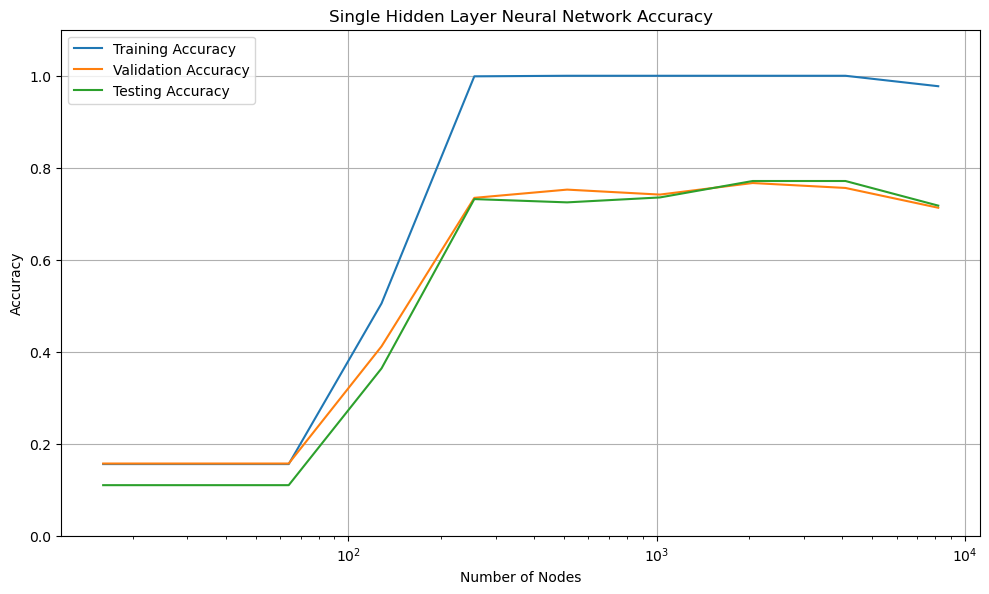

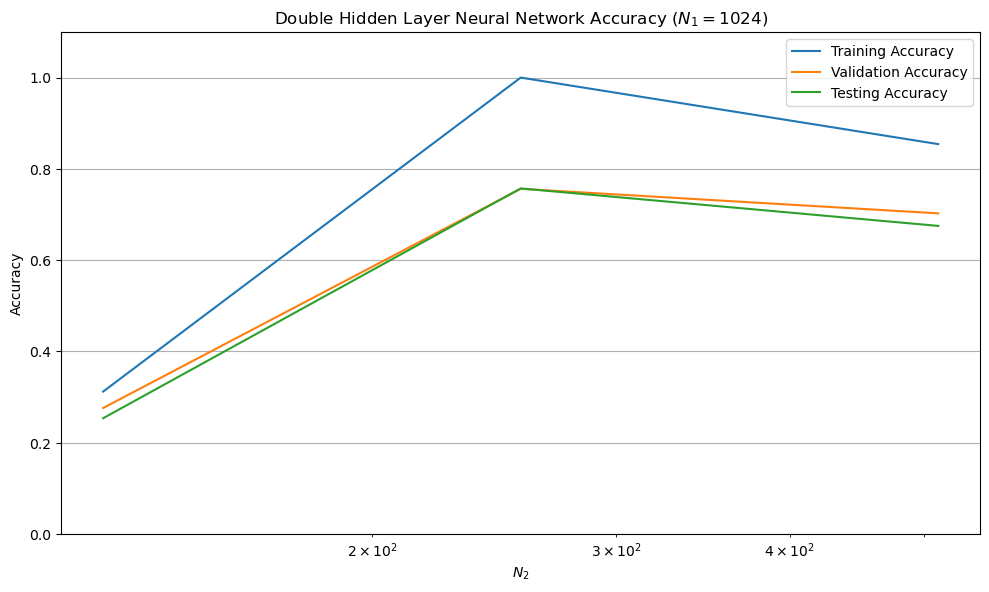

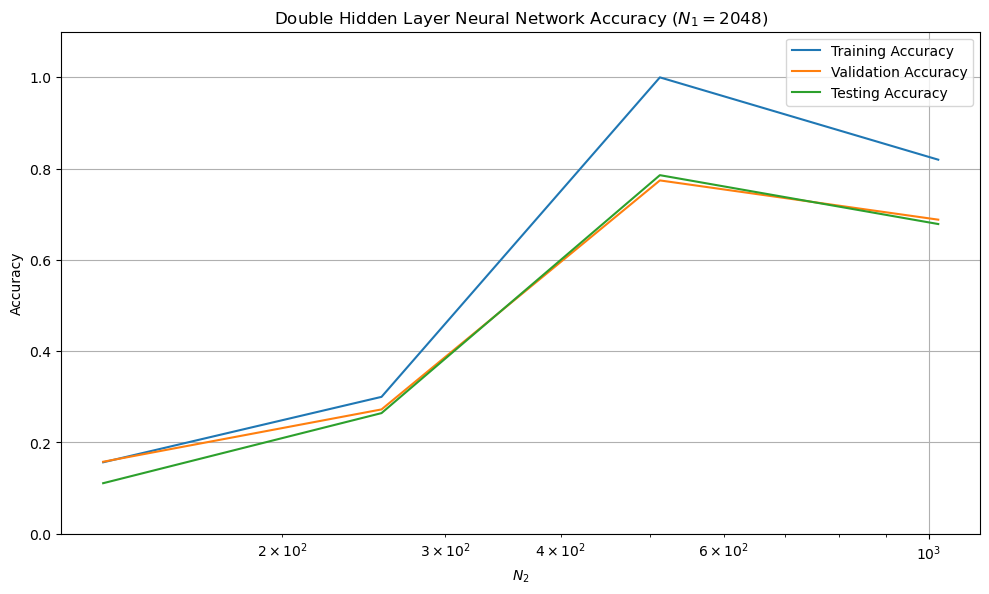

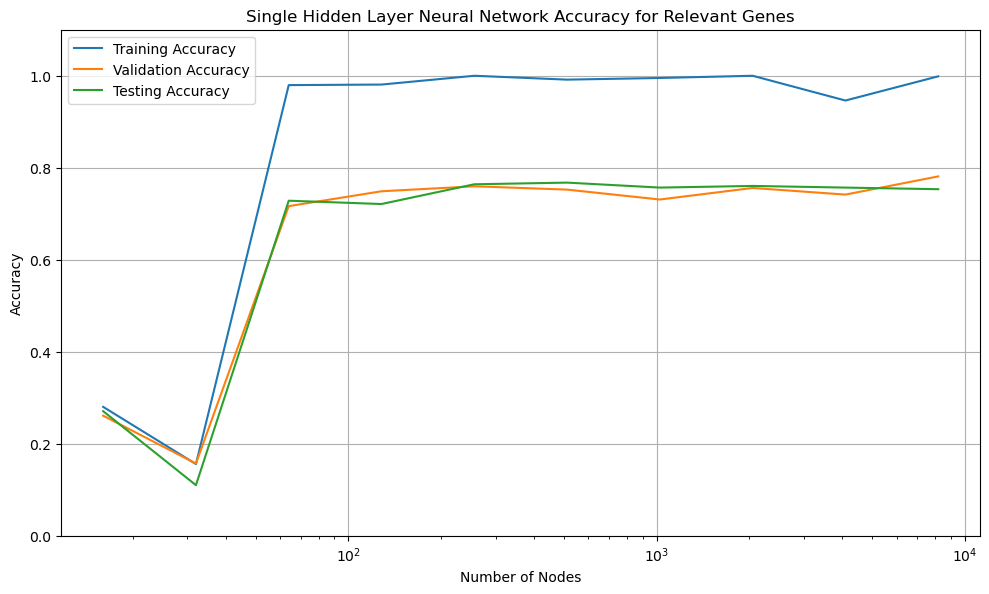

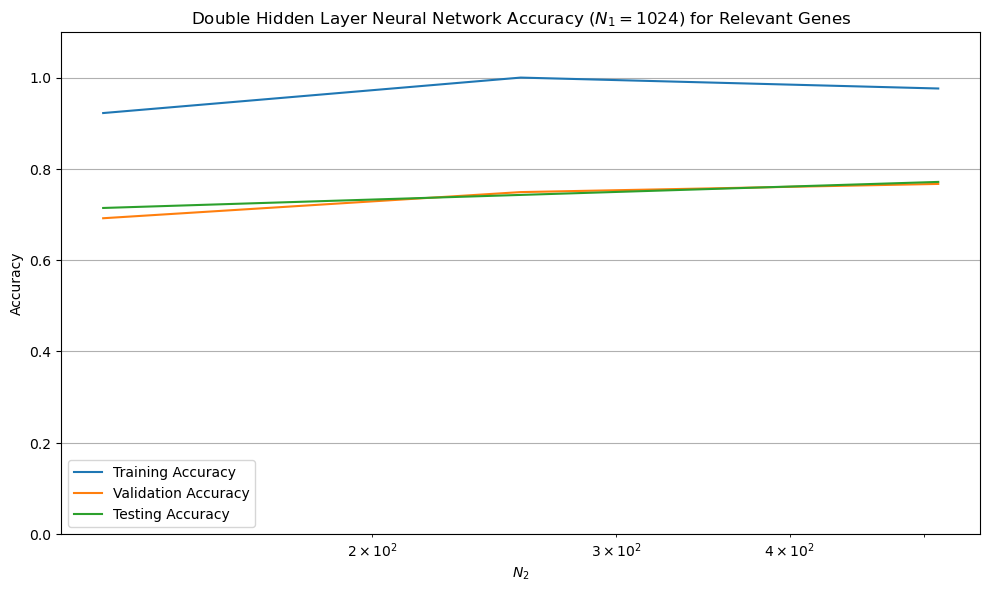

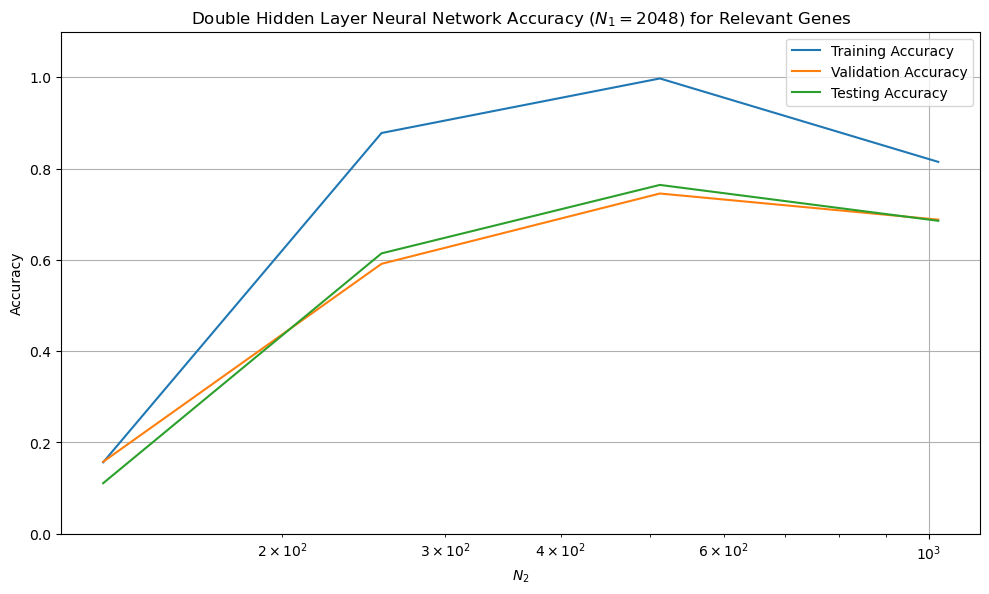

In [136]:
plot_accuracies([16,32,64,128,256,512,1024,2048,4096,8192],[0.1565,0.1565,0.1565,0.5054,0.9988,1,1,1,1,0.9773],[0.1577,0.1577,0.1577,0.4122,0.7348,0.7527,0.7419,0.767,0.7563,0.7133],[0.1107,0.1107,0.1107,0.3643,0.7321,0.725,0.7357,0.7714,0.7714,0.7179],"Number of Nodes", "Single Hidden Layer Neural Network Accuracy")
plot_accuracies([128,256,512],[0.312,1,0.8542], [0.276, 0.7563, 0.7025],[0.2536,0.7571,0.675],"$N_2$", "Double Hidden Layer Neural Network Accuracy ($N_1 = 1024$)")
plot_accuracies([128,256,512, 1024],[0.1565,0.2999,1,0.8196], [0.1577, 0.2724, 0.7742,0.6882],[0.1107,0.2643,0.7857,0.6786],"$N_2$", "Double Hidden Layer Neural Network Accuracy ($N_1 = 2048$)")
plot_accuracies([16,32,64,128,256,512,1024,2048,4096,8192],[0.2808,0.1565,0.9797,0.9809,1,0.9916,0.9952,1,0.9462,0.9988],[0.2616,0.1577,0.7168,0.7491,0.7599,0.7527,0.7312,0.7563,0.7419,0.7814],[0.2714,0.1107,0.7286,0.7214,0.7643,0.7679,0.7571,0.7607,0.7571,0.7536],"Number of Nodes", "Single Hidden Layer Neural Network Accuracy for Relevant Genes")
plot_accuracies([128,256,512],[0.9223,1,0.9761],[0.6918,0.7491,0.767],[0.7143,0.7429,0.7714],"$N_2$", "Double Hidden Layer Neural Network Accuracy ($N_1 = 1024$) for Relevant Genes")
plot_accuracies([128,256,512, 1024],[0.1565,0.8781,0.9976,0.8148], [0.1577,0.5914,0.7455,0.6882],[0.1107,0.6143,0.7643,0.6857],"$N_2$", "Double Hidden Layer Neural Network Accuracy ($N_1 = 2048$) for Relevant Genes")

9/9 [==============================] - 1s 62ms/step


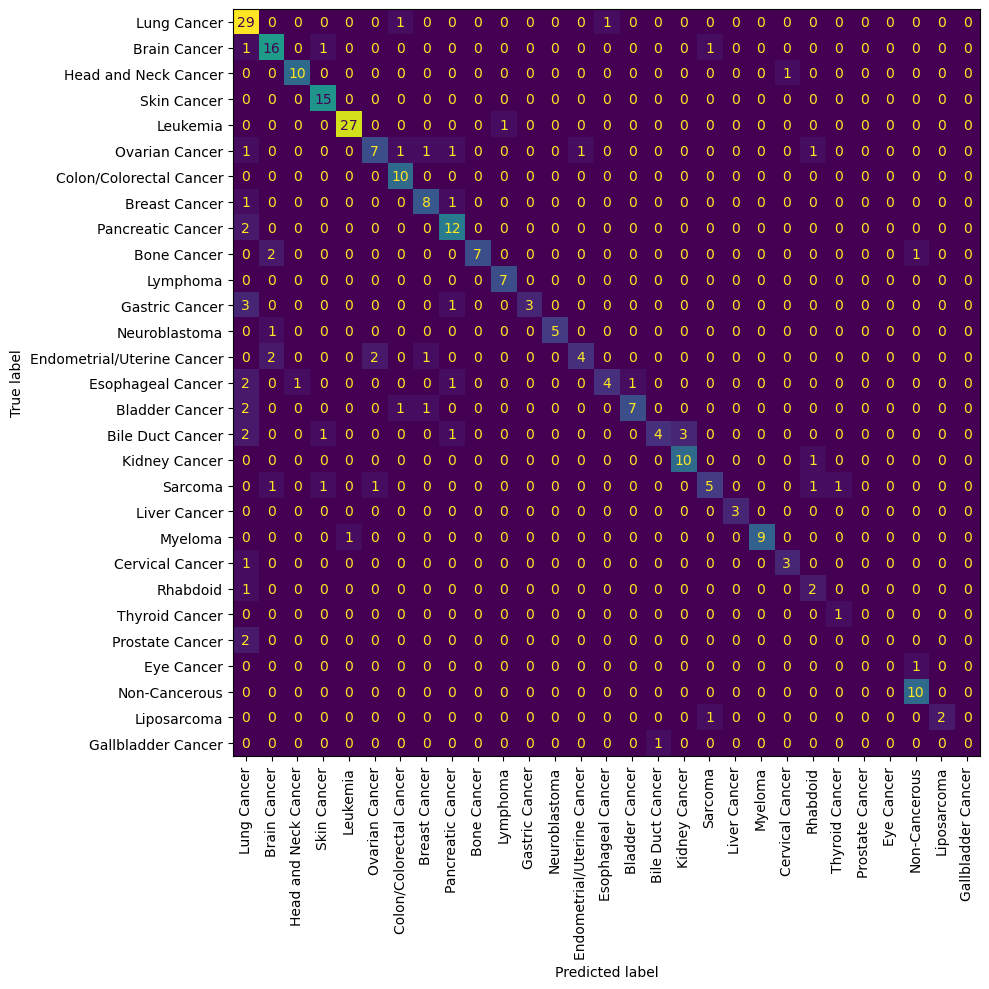

In [170]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disease_labels = [
'Lung Cancer',
'Brain Cancer',
'Head and Neck Cancer',
'Skin Cancer',
'Leukemia',
'Ovarian Cancer',
'Colon/Colorectal Cancer',
'Breast Cancer',
'Pancreatic Cancer',
'Bone Cancer',
'Lymphoma',
'Gastric Cancer',
'Neuroblastoma',
'Endometrial/Uterine Cancer',
'Esophageal Cancer',
'Bladder Cancer',
'Bile Duct Cancer',
'Kidney Cancer',
'Sarcoma',
'Liver Cancer',
'Myeloma',
'Cervical Cancer',
'Rhabdoid',
'Thyroid Cancer',
'Prostate Cancer',
'Eye Cancer',
'Non-Cancerous',
'Liposarcoma',
'Gallbladder Cancer'
    ]

X = X_exp
y = y_exp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X,y, seed=45) #split data into training, validation, testing

model = keras.models.load_model("NN_CCLE_expression_primary_disease_num_nodes=(2048,512)_optimizer=adam.h5")

y_predict_prob = model.predict(X_test)
y_predict = np.argmax(y_predict_prob, axis=1)

#y = y.replace(inv_mapping)
#y_predict = y_predict.replace(inv_mapping)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=disease_labels)
_, ax = plt.subplots(figsize=(10.0, 10.0))
disp.plot(ax = ax,colorbar = False, xticks_rotation = 'vertical')
plt.tight_layout()
plt.savefig('neural_network_confusion_matrix')

9/9 [==============================] - 0s 9ms/step


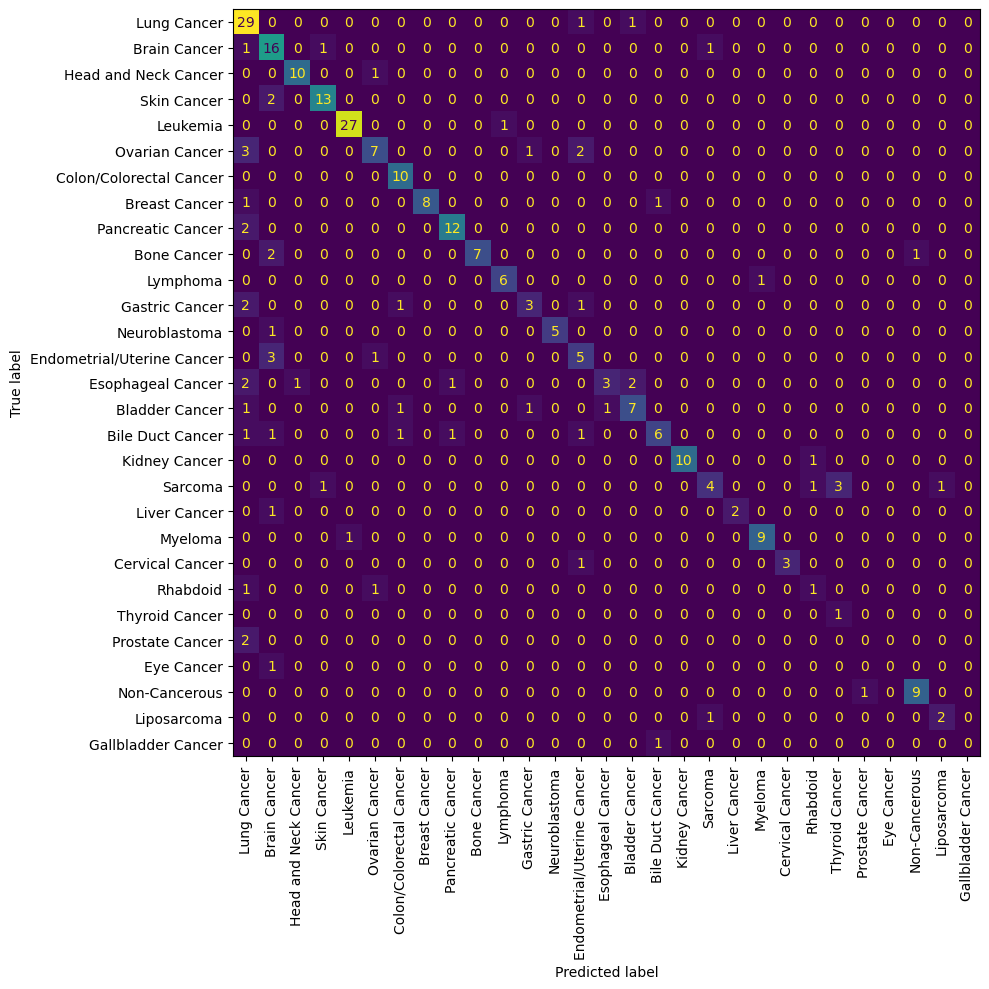

In [169]:
X = X_rel
y = y_exp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X,y, seed=45) #split data into training, validation, testing

model = keras.models.load_model("NN_CCLE_expression_primary_disease_relevant_genes_num_nodes=512_optimizer=adam.h5")

y_predict_prob = model.predict(X_test)
y_predict = np.argmax(y_predict_prob, axis=1)

#y = y.replace(inv_mapping)
#y_predict = y_predict.replace(inv_mapping)

cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=disease_labels)
_, ax = plt.subplots(figsize=(10.0, 10.0))
disp.plot(ax = ax,colorbar = False, xticks_rotation = 'vertical')
plt.tight_layout()
plt.savefig('neural_network_confusion_matrix_relevant_genes')